<a href="https://www.kaggle.com/code/dataranch/personality-feature-importance?scriptVersionId=112207337" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# <div style="text-align: center; background-color: blue; color: white; padding: 14px; line-height: 1;border-radius:20px">**Personality Dataset Model Comparison + Feature Importance 📊**</div>
- Preprocessing
    - Detect continuous and categorical variables.
    - Normalize and impute data.
    

- For every target variable in the dataset:
    - Compare performance on 27 models + a TabNet model.
    - Output model performance and processed data in CSV format for every dataset.
    - Save plots + CSVs of XGBoost Feature Importances.
    - Save best performing FastAI model.

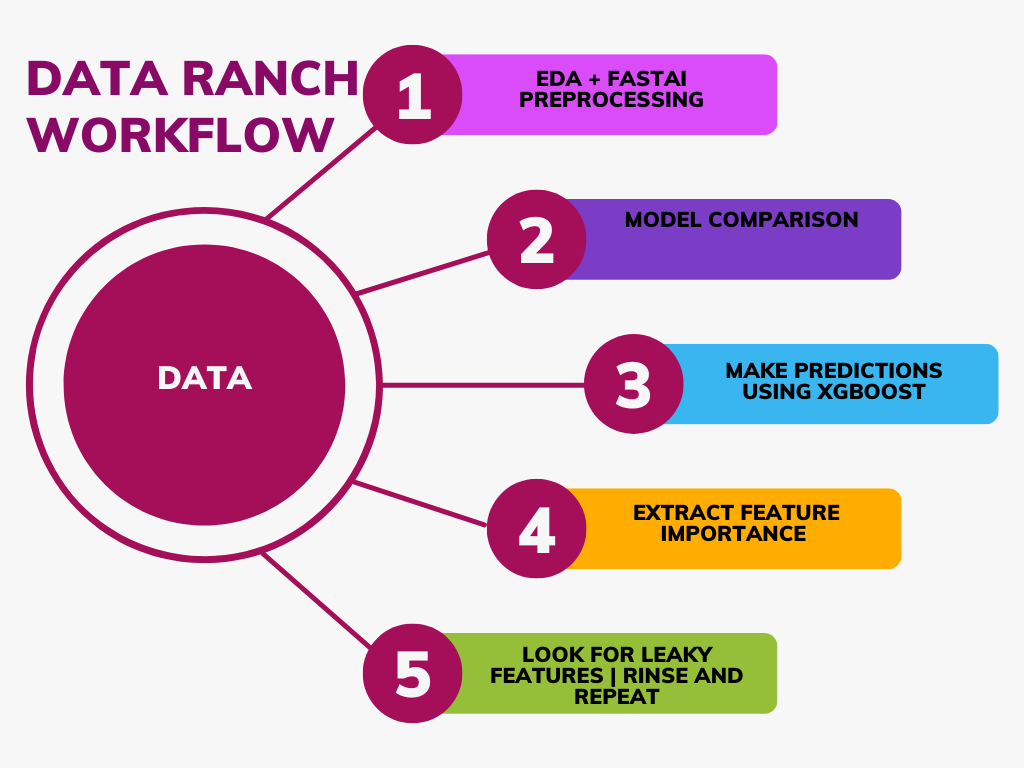

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install lazypredict

In [3]:
!pip install --upgrade pandas

In [4]:
!pip install fast-tabnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 1.3 MB/s eta 0:00:00


In [5]:
!pip install fastai

  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.4.0
    Uninstalling typing_extensions-4.4.0:
      Successfully uninstalled typing_extensions-4.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
tensorflow 2.6.4 requires h5py~=3.1.0, but you have h5py 3.7.0 which is incompatible.
tensorflow 2.6.4 requires numpy~=1.19.2, but you have numpy 1.21.6 which is incompatible.
tensorflow 2.6.4 requires tensorboard<2.7,>=2.6.0, but you have tensorboard 2.10.1 which is incompatible.
tensorflow 2.6.4 requires typing-extensions<3.11,>=3.7, but you have typing-extensions 4.1.1 which is incompatible.
tensorflow-transform 1.9.0 requires pyarrow<6,>=1, but you have pyarrow 8.0.0 which is incompatible.
tensorflow-transform 1.9.0 requires te

In [6]:
!pip install pandas-profiling

  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 2.1.1
    Uninstalling MarkupSafe-2.1.1:
      Successfully uninstalled MarkupSafe-2.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
beatrix-jupyterlab 3.1.7 requires google-cloud-bigquery-storage, which is not installed.
werkzeug 2.2.2 requires MarkupSafe>=2.1.1, but you have markupsafe 2.0.1 which is incompatible.


In [7]:
#A program that takes a csv and trains models on it. Streamlined model selection.
#==============================================================================

#LazyPredict
import lazypredict
from lazypredict.Supervised import LazyRegressor
from lazypredict.Supervised import LazyClassifier
#Baysian Optimization
from bayes_opt import BayesianOptimization
#Pandas stack
import pandas as pd
import pandas_profiling
import numpy as np
#FastAI
from fastai.tabular.all import *
from fastai.tabular.core import *
#Plots
import matplotlib.pyplot as plt
import seaborn as sns
#System
import os
import sys
import traceback
#Fit an xgboost model
from xgboost import XGBRegressor
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
#Random
import random

#TabNet
from fast_tabnet.core import *

import shutil

In [8]:
%matplotlib inline

In [9]:
# For Styling
plt.style.use('seaborn-bright')

In [10]:
#Project Variables
#===================================================================================================
PROJECT_NAME = 'personality-classification-type-dataset'
VARIABLE_FILES = False
#Maximum amount of rows to take
SAMPLE_COUNT = 20000
FASTAI_LEARNING_RATE = 1e-1
AUTO_ADJUST_LEARNING_RATE = False
#Set to True automatically infer if variables are categorical or continuous
ENABLE_BREAKPOINT = True
#When trying to declare a column a continuous variable, if it fails, convert it to a categorical variable
CONVERT_TO_CAT = False
REGRESSOR = True
SEP_DOLLAR = False
SEP_COMMA = True
SHUFFLE_DATA = True

In [11]:
input_dir = f'../input/{PROJECT_NAME}'
param_dir = f'/kaggle/working/{PROJECT_NAME}'
TARGET = ''
PARAM_DIR = param_dir
print(f'param_dir: {param_dir}')
if not os.path.exists(param_dir):
    os.makedirs(param_dir)
#rename any file in param_dir/file that ends with csv to data.csv
for file in os.listdir(input_dir):
    if file.endswith('.csv'):
        print('CSV!')
        if 'classification_results' not in file and 'regression_results' not in file:
            #os.rename(f'{input_dir}/{file}', f'{param_dir}/data.csv')
            shutil.copy(f'{input_dir}/{file}', f'{param_dir}/data.csv')
        #os.rename(f'{param_dir}/{file}', f'{param_dir}/data.csv')
try:
    df = pd.read_csv(f'{param_dir}/data.csv', nrows=SAMPLE_COUNT)
except:
    print(f'Please place a file named data.csv in {param_dir}')
    #sys.exit()

param_dir: /kaggle/working/personality-classification-type-dataset
CSV!


In [12]:
df

Worry about things.  Make friends easily.  Have a vivid imagination.  \
0                  -1.00                  0.00                       1.00   
1                   0.00                  1.00                       1.00   
2                  -1.00                  1.00                       1.00   
3                  -2.00                  1.00                       0.00   
4                  -1.00                  1.00                       1.00   
..                   ...                   ...                        ...   
117                  NaN                  1.00                       1.00   
118                -1.00                  1.00                       0.00   
119                -1.00                  1.00                       1.00   
120                -2.00                  0.00                       1.00   
121                -1.00                  1.00                       1.00   

     Trust others  Get angry easily.  Love large parties.  \
0               1              -1.00                    0   
1               2               0.00                    1   
2               1              -1.00                    1   
3               0              -2.00                    2   
4               1              -1.00                    1   
..            ...                ...                  ...   
117             1              -1.00                    1   
118             2              -1.00                    0   
119             0              -2.00                    1   
120             0              -2.00                    2   
121             1              -1.00                    1   

     Would never cheat to get ahead.  Like order.  Often feel unhappy.  \
0                              -1.00            1                 0.00   
1                              -2.00            2                -1.00   
2                              -1.00            1                 0.00   
3                              -1.00            0                 0.00   
4                              -2.00            1                 1.00   
..                               ...          ...                  ...   
117                            -2.00            1                 1.00   
118                            -2.00            2                -1.00   
119                            -1.00            0                 1.00   
120                            -2.00            0                 1.00   
121                            -1.00            1                 0.00   

     Take charge.  ...  Stick to the rules.  Try to lead others.  \
0               1  ...                 1.00                    1   
1               2  ...                 1.00                    1   
2               1  ...                 2.00                    1   
3               0  ...                 1.00                    1   
4               1  ...                 0.00                    1   
..            ...  ...                  ...                  ...   
117             1  ...                 1.00                    1   
118             2  ...                 0.00                    0   
119             0  ...                 2.00                    1   
120             0  ...                 2.00                    1   
121             1  ...                 1.00                    0   

     Keep my promises.  Feel others' emotions  Like to visit new places.  \
0                    2                   1.00                          2   
1                    1                   2.00                          2   
2                    0                   1.00                          2   
3                    1                   0.00                          1   
4                    2                   1.00                          2   
..                 ...                    ...                        ...   
117                  1                   2.00                          2   
118                  2           

In [13]:
if SEP_DOLLAR:
    #For every column in df, if the column contains a $, make a new column with the value without the $
    for col in df.columns:
        if '$' in df[col].to_string():
            df[col + '_no_dollar'] = df[col].str.replace('$', '').str.replace(',', '')
            #Try to convert this new column to a numeric type
            try:
                df[col + '_no_dollar'] = df[col + '_no_dollar'].apply(pd.to_numeric, errors='coerce').dropna()
            except Exception:
                print(f'{col} can not be converted to a float!')


if SEP_COMMA:
    #For every column in df, if the column contains a %, make a new column with the value without the %
    for col in df.columns:
        if '%' in df[col].to_string() or ',' in df[col].to_string():
            df[col + '_processed'] = df[col].str.replace('%', '').str.replace(',', '')
            #Try to convert this new column to a numeric type
            try:
                df[col + '_processed'] = df[col + '_processed'].apply(pd.to_numeric, errors='coerce').dropna()
            except Exception:
                print(f'{col} can not be converted to a float!')

In [14]:
df

Worry about things.  Make friends easily.  Have a vivid imagination.  \
0                  -1.00                  0.00                       1.00   
1                   0.00                  1.00                       1.00   
2                  -1.00                  1.00                       1.00   
3                  -2.00                  1.00                       0.00   
4                  -1.00                  1.00                       1.00   
..                   ...                   ...                        ...   
117                  NaN                  1.00                       1.00   
118                -1.00                  1.00                       0.00   
119                -1.00                  1.00                       1.00   
120                -2.00                  0.00                       1.00   
121                -1.00                  1.00                       1.00   

     Trust others  Get angry easily.  Love large parties.  \
0               1              -1.00                    0   
1               2               0.00                    1   
2               1              -1.00                    1   
3               0              -2.00                    2   
4               1              -1.00                    1   
..            ...                ...                  ...   
117             1              -1.00                    1   
118             2              -1.00                    0   
119             0              -2.00                    1   
120             0              -2.00                    2   
121             1              -1.00                    1   

     Would never cheat to get ahead.  Like order.  Often feel unhappy.  \
0                              -1.00            1                 0.00   
1                              -2.00            2                -1.00   
2                              -1.00            1                 0.00   
3                              -1.00            0                 0.00   
4                              -2.00            1                 1.00   
..                               ...          ...                  ...   
117                            -2.00            1                 1.00   
118                            -2.00            2                -1.00   
119                            -1.00            0                 1.00   
120                            -2.00            0                 1.00   
121                            -1.00            1                 0.00   

     Take charge.  ...  Stick to the rules.  Try to lead others.  \
0               1  ...                 1.00                    1   
1               2  ...                 1.00                    1   
2               1  ...                 2.00                    1   
3               0  ...                 1.00                    1   
4               1  ...                 0.00                    1   
..            ...  ...                  ...                  ...   
117             1  ...                 1.00                    1   
118             2  ...                 0.00                    0   
119             0  ...                 2.00                    1   
120             0  ...                 2.00                    1   
121             1  ...                 1.00                    0   

     Keep my promises.  Feel others' emotions  Like to visit new places.  \
0                    2                   1.00                          2   
1                    1                   2.00                          2   
2                    0                   1.00                          2   
3                    1                   0.00                          1   
4                    2                   1.00                          2   
..                 ...                    ...                        ...   
117                  1                   2.00                          2   
118                  2           

In [15]:
df.isna().sum()

Worry about things.                 5
Make friends easily.                5
Have a vivid imagination.           2
Trust others                        0
Get angry easily.                   2
Love large parties.                 0
Would never cheat to get ahead.     5
Like order.                         0
Often feel unhappy.                 2
Take charge.                        0
Make people feel welcome.           1
Try to follow the rules.            0
Am always busy.                     3
Am easy to satisfy.                 0
Go straight for the goal.           0
Often overindulge.                  3
Panic easily.                       7
Avoid mistakes.                     0
Warm up quickly to others.          4
Get irritated easily.               6
Stick to the rules.                 6
Try to lead others.                 0
Keep my promises.                   0
Feel others' emotions               2
Like to visit new places.           0
Work hard.                         13
Become overw

In [16]:
df.profile_report()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

<AxesSubplot:>

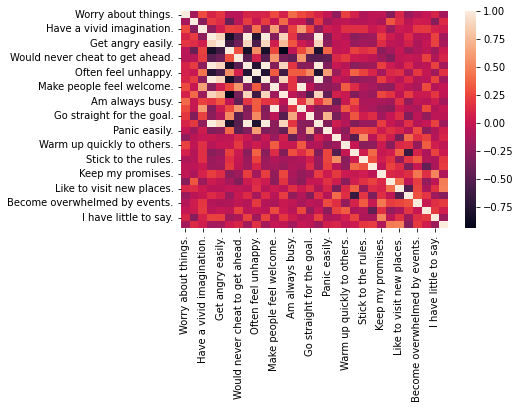

In [17]:
sns.heatmap(df.corr())

In [18]:
df.head().style.background_gradient(cmap = "inferno")

In [19]:
df.describe().T.style.background_gradient(cmap = "viridis")

In [20]:
df.columns

Index(['Worry about things.', 'Make friends easily.',
       'Have a vivid imagination.', 'Trust others', 'Get angry easily.',
       'Love large parties.', 'Would never cheat to get ahead.', 'Like order.',
       'Often feel unhappy.', 'Take charge.', 'Make people feel welcome.',
       'Try to follow the rules.', 'Am always busy.', 'Am easy to satisfy.',
       'Go straight for the goal.', 'Often overindulge.', 'Panic easily.',
       'Avoid mistakes.', 'Warm up quickly to others.',
       'Get irritated easily.', 'Stick to the rules.', 'Try to lead others.',
       'Keep my promises.', 'Feel others' emotions',
       'Like to visit new places.', 'Work hard.',
       'Become overwhelmed by events.', 'Choose my words with care.',
       'I have little to say.', 'I am quiet around strangers.'],
      dtype='object')

Target Variable: I am quiet around strangers.
CATS=====================
['Make friends easily.', 'Have a vivid imagination.', 'Trust others', 'Get angry easily.', 'Love large parties.', 'Would never cheat to get ahead.', 'Like order.', 'Often feel unhappy.', 'Take charge.', 'Make people feel welcome.', 'Try to follow the rules.', 'Am easy to satisfy.', 'Go straight for the goal.', 'Often overindulge.', 'Avoid mistakes.', 'Warm up quickly to others.', 'Get irritated easily.', 'Stick to the rules.', 'Try to lead others.', 'Keep my promises.', "Feel others' emotions", 'Like to visit new places.', 'Work hard.', 'Choose my words with care.', 'I have little to say.']
CONTS=====================
['Worry about things.', 'Am always busy.', 'Panic easily.', 'Become overwhelmed by events.']
29
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['Worry about things.', 'Am always busy.', 'Panic easily.', 'Become overwhelmed by events.']
Categorical varia

  5%|▍         | 2/42 [00:00<00:02, 18.74it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.20365443110370185, 'Adjusted R-Squared': 1.6470307747282422, 'RMSE': 3.3365529105285803, 'Time taken': 0.07760047912597656}
{'Model': 'BaggingRegressor', 'R-Squared': 0.42824813977569975, 'Adjusted R-Squared': 1.464548386432244, 'RMSE': 2.827164152089005, 'Time taken': 0.028949737548828125}
{'Model': 'BayesianRidge', 'R-Squared': 0.1705065479502118, 'Adjusted R-Squared': 1.6739634297904529, 'RMSE': 3.405286944267368, 'Time taken': 0.02923274040222168}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.9693430637949437, 'Adjusted R-Squared': 1.0249087606666083, 'RMSE': 0.6546536707079771, 'Time taken': 0.011584758758544922}
{'Model': 'DummyRegressor', 'R-Squared': -0.050387782890462196, 'Adjusted R-Squared': 1.8534400735985006, 'RMSE': 3.8319697, 'Time taken': 0.009589195251464844}
{'Model': 'ElasticNet', 'R-Squared': 0.029819403233567687, 'Adjusted R-Squared': 1.7882717348727262, 'RMSE': 3.6827609087229067, 'Time taken': 0.01176309585571289}

 21%|██▏       | 9/42 [00:00<00:01, 17.93it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.11941521566927671, 'Adjusted R-Squared': 1.7154751372687127, 'RMSE': 3.508591612064573, 'Time taken': 0.20239830017089844}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.8875912339147936, 'Adjusted R-Squared': 1.0913321224442303, 'RMSE': 1.2535663410560174, 'Time taken': 0.011846780776977539}
{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.8448171436746887, 'Adjusted R-Squared': 1.1260860707643154, 'RMSE': 1.472885894135339, 'Time taken': 0.10996603965759277}
GammaRegressor model failed to execute
Some value(s) of y are out of the valid range for family GammaDistribution
{'Model': 'GaussianProcessRegressor', 'R-Squared': 0.006657940959661102, 'Adjusted R-Squared': 1.8070904229702753, 'RMSE': 3.7264615494725777, 'Time taken': 0.015431880950927734}


 36%|███▌      | 15/42 [00:00<00:01, 22.12it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.43677315757170065, 'Adjusted R-Squared': 1.4576218094729931, 'RMSE': 2.806007997324377, 'Time taken': 0.08806228637695312}
{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.22054851173307843, 'Adjusted R-Squared': 1.6333043342168738, 'RMSE': 3.3009715217987834, 'Time taken': 0.07017898559570312}
{'Model': 'HuberRegressor', 'R-Squared': 0.14085024543403124, 'Adjusted R-Squared': 1.6980591755848495, 'RMSE': 3.4656257951035205, 'Time taken': 0.03555417060852051}
{'Model': 'KNeighborsRegressor', 'R-Squared': -0.13205847345210908, 'Adjusted R-Squared': 1.9197975096798388, 'RMSE': 3.9781547, 'Time taken': 0.010444402694702148}
{'Model': 'KernelRidge', 'R-Squared': 0.4778767728363428, 'Adjusted R-Squared': 1.4242251220704714, 'RMSE': 2.7016789506191095, 'Time taken': 0.015669822692871094}
{'Model': 'Lars', 'R-Squared': -5.5004791707483855, 'Adjusted R-Squared': 6.281639326233063, 'RMSE': 9.532787626015603, 'Time taken': 0.015072822

 48%|████▊     | 20/42 [00:01<00:01, 17.91it/s]

{'Model': 'LassoCV', 'R-Squared': 0.11595190328721483, 'Adjusted R-Squared': 1.7182890785791378, 'RMSE': 3.5154844318750698, 'Time taken': 0.2582838535308838}
{'Model': 'LassoLars', 'R-Squared': -0.050387838769820004, 'Adjusted R-Squared': 1.8534401190004788, 'RMSE': 3.831969773750672, 'Time taken': 0.01212000846862793}
{'Model': 'LassoLarsCV', 'R-Squared': 0.08150636297188252, 'Adjusted R-Squared': 1.7462760800853454, 'RMSE': 3.5833176464193355, 'Time taken': 0.03839302062988281}
{'Model': 'LassoLarsIC', 'R-Squared': 0.20812462062659487, 'Adjusted R-Squared': 1.6433987457408916, 'RMSE': 3.3271750635732626, 'Time taken': 0.016788482666015625}
{'Model': 'LinearRegression', 'R-Squared': 0.4579881887178636, 'Adjusted R-Squared': 1.440384596666736, 'RMSE': 2.7526538872854123, 'Time taken': 0.010802030563354492}
{'Model': 'LinearSVR', 'R-Squared': 0.16725345294736638, 'Adjusted R-Squared': 1.6766065694802648, 'RMSE': 3.411957811920811, 'Time taken': 0.0140380859375}


 76%|███████▌  | 32/42 [00:01<00:00, 25.41it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.5303686167359787, 'Adjusted R-Squared': 1.3815754989020173, 'RMSE': 2.5622752867689065, 'Time taken': 0.13467741012573242}
{'Model': 'NuSVR', 'R-Squared': 0.007053584873162988, 'Adjusted R-Squared': 1.8067689622905552, 'RMSE': 3.7257193586764736, 'Time taken': 0.012761116027832031}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.2222712249508978, 'Adjusted R-Squared': 1.6319046297273956, 'RMSE': 3.297321664863937, 'Time taken': 0.010857105255126953}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.12594215638504247, 'Adjusted R-Squared': 1.710171997937153, 'RMSE': 3.495564495006687, 'Time taken': 0.015779972076416016}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.18605506312763898, 'Adjusted R-Squared': 1.6613302612087932, 'RMSE': 3.3732206109904253, 'Time taken': 0.01192617416381836}
PoissonRegressor model failed to execute
Some value(s) of y are out of the valid range for family PoissonDistribution
{'Model': 'QuantileRegr

 83%|████████▎ | 35/42 [00:01<00:00, 18.90it/s]

{'Model': 'RANSACRegressor', 'R-Squared': -0.027351477668773327, 'Adjusted R-Squared': 1.8347230756058783, 'RMSE': 3.7897168022538783, 'Time taken': 0.15306687355041504}
{'Model': 'RandomForestRegressor', 'R-Squared': 0.5261045691933028, 'Adjusted R-Squared': 1.3850400375304415, 'RMSE': 2.5738811716383267, 'Time taken': 0.13878679275512695}
{'Model': 'Ridge', 'R-Squared': 0.41040435473374826, 'Adjusted R-Squared': 1.4790464617788295, 'RMSE': 2.8709416502462184, 'Time taken': 0.011142492294311523}
{'Model': 'RidgeCV', 'R-Squared': 0.338923067350302, 'Adjusted R-Squared': 1.5371250077778797, 'RMSE': 3.039997552436711, 'Time taken': 0.011089563369750977}
{'Model': 'SGDRegressor', 'R-Squared': 0.3964387274196941, 'Adjusted R-Squared': 1.4903935339714987, 'RMSE': 2.904744346172775, 'Time taken': 0.010616540908813477}
{'Model': 'SVR', 'R-Squared': 0.040074357083045076, 'Adjusted R-Squared': 1.779939584870026, 'RMSE': 3.6632455351198017, 'Time taken': 0.010212898254394531}
{'Model': 'Transfor

100%|██████████| 42/42 [00:02<00:00, 18.54it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.8858818196644105, 'Adjusted R-Squared': 1.0927210215226664, 'RMSE': 1.263062, 'Time taken': 0.38243937492370605}
{'Model': 'LGBMRegressor', 'R-Squared': 0.22054851173307843, 'Adjusted R-Squared': 1.6333043342168738, 'RMSE': 3.3009715217987834, 'Time taken': 0.0684349536895752}
Project: personality-classification-type-dataset
personality-classification-type-dataset
Target: I am quiet around strangers.
I am quiet around strangers.
Target Standard Deviation: 1.7104681730270386
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
Lars                                         6.28      -5.50  9.53        0.02
KNeighborsRegressor                          1.92      -0.13  3.98        0.01
QuantileRegressor                            1.89      -0.09  3.91        0.10
LassoLars                                    1.85      -0.05  3.83        0.01
Lasso 

Better model found at epoch 0 with _rmse value: 3.8859570026397705.
No improvement since epoch 0: early stopping


<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
   actual  predicted
0   -2.00      -1.94
1   -1.00       0.00
2    9.00       5.84
3    9.00       5.84
4   -2.00      -1.69
XGBoost RMSE:  1.2630862


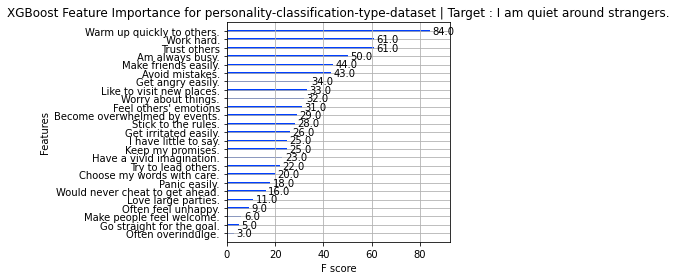

Target Variable: I have little to say.
CATS=====================
['Make friends easily.', 'Have a vivid imagination.', 'Trust others', 'Get angry easily.', 'Love large parties.', 'Would never cheat to get ahead.', 'Like order.', 'Often feel unhappy.', 'Take charge.', 'Make people feel welcome.', 'Try to follow the rules.', 'Am easy to satisfy.', 'Go straight for the goal.', 'Often overindulge.', 'Avoid mistakes.', 'Warm up quickly to others.', 'Get irritated easily.', 'Stick to the rules.', 'Try to lead others.', 'Keep my promises.', "Feel others' emotions", 'Like to visit new places.', 'Work hard.', 'Choose my words with care.', 'I have little to say.']
CONTS=====================
['Worry about things.', 'Am always busy.', 'Panic easily.', 'Become overwhelmed by events.', 'I am quiet around strangers.']
30
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['Worry about things.', 'Am always busy.', 'Panic easily.', 'Become overwhelmed by ev

  5%|▍         | 2/42 [00:00<00:02, 19.31it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.6847621819097272, 'Adjusted R-Squared': 1.2561307271983466, 'RMSE': 0.3132247261943471, 'Time taken': 0.076202392578125}
{'Model': 'BaggingRegressor', 'R-Squared': 0.5983606557377049, 'Adjusted R-Squared': 1.3263319672131146, 'RMSE': 0.3535533905932738, 'Time taken': 0.027203798294067383}
{'Model': 'BayesianRidge', 'R-Squared': 0.20764052291663282, 'Adjusted R-Squared': 1.6437920751302357, 'RMSE': 0.49659004620535, 'Time taken': 0.013262271881103516}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.3114754098360657, 'Adjusted R-Squared': 1.5594262295081966, 'RMSE': 0.4629100498862757, 'Time taken': 0.012253999710083008}
{'Model': 'DummyRegressor', 'R-Squared': -0.14754098360655754, 'Adjusted R-Squared': 1.932377049180328, 'RMSE': 0.5976143046671969, 'Time taken': 0.010554790496826172}
{'Model': 'ElasticNet', 'R-Squared': -0.14754098360655754, 'Adjusted R-Squared': 1.932377049180328, 'RMSE': 0.5976143046671969, 'Time taken': 0.0108468532562

 21%|██▏       | 9/42 [00:00<00:01, 17.79it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.12883170787309528, 'Adjusted R-Squared': 1.70782423735311, 'RMSE': 0.5207004006562483, 'Time taken': 0.2252669334411621}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.7704918032786885, 'Adjusted R-Squared': 1.1864754098360657, 'RMSE': 0.2672612419124244, 'Time taken': 0.01147603988647461}
{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.6770131147540984, 'Adjusted R-Squared': 1.262426844262295, 'RMSE': 0.3170511450403997, 'Time taken': 0.10746908187866211}
{'Model': 'GammaRegressor', 'R-Squared': 0.1658025600830173, 'Adjusted R-Squared': 1.6777854199325484, 'RMSE': 0.5095318170901835, 'Time taken': 0.012995719909667969}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -4.396923250420326, 'Adjusted R-Squared': 5.385000140966516, 'RMSE': 1.2960149247133674, 'Time taken': 0.017894983291625977}


 36%|███▌      | 15/42 [00:00<00:01, 21.54it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.510651390620122, 'Adjusted R-Squared': 1.397595745121151, 'RMSE': 0.39025282995334537, 'Time taken': 0.09042978286743164}
{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.2662192683525597, 'Adjusted R-Squared': 1.5961968444635453, 'RMSE': 0.4778812967976988, 'Time taken': 0.06933999061584473}
{'Model': 'HuberRegressor', 'R-Squared': -0.21524554538948992, 'Adjusted R-Squared': 1.9873870056289604, 'RMSE': 0.61499119899443, 'Time taken': 0.03692293167114258}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.09114754098360667, 'Adjusted R-Squared': 1.7384426229508196, 'RMSE': 0.531843156256751, 'Time taken': 0.010922670364379883}
{'Model': 'KernelRidge', 'R-Squared': -3.725177163272808, 'Adjusted R-Squared': 4.8392064451591565, 'RMSE': 1.2126792040085888, 'Time taken': 0.011908769607543945}
{'Model': 'Lars', 'R-Squared': -110.90323670817985, 'Adjusted R-Squared': 91.92137982539613, 'RMSE': 5.90144285332114, 'Time taken': 0.015532

 60%|█████▉    | 25/42 [00:01<00:00, 24.27it/s]

{'Model': 'LassoCV', 'R-Squared': 0.07841883615156842, 'Adjusted R-Squared': 1.7487846956268507, 'RMSE': 0.5355545047184803, 'Time taken': 0.24191904067993164}
{'Model': 'LassoLars', 'R-Squared': -0.14754098360655754, 'Adjusted R-Squared': 1.932377049180328, 'RMSE': 0.5976143046671969, 'Time taken': 0.012063980102539062}
{'Model': 'LassoLarsCV', 'R-Squared': 0.10506579138923078, 'Adjusted R-Squared': 1.72713404449625, 'RMSE': 0.5277550970628334, 'Time taken': 0.043413400650024414}
{'Model': 'LassoLarsIC', 'R-Squared': 0.11810377971261576, 'Adjusted R-Squared': 1.7165406789834998, 'RMSE': 0.5238966512699714, 'Time taken': 0.019803524017333984}
{'Model': 'LinearRegression', 'R-Squared': -0.601602241242827, 'Adjusted R-Squared': 2.3013018210097966, 'RMSE': 0.7060154675265963, 'Time taken': 0.011237859725952148}
{'Model': 'LinearSVR', 'R-Squared': -0.09412972573482747, 'Adjusted R-Squared': 1.8889804021595473, 'RMSE': 0.5835408860245954, 'Time taken': 0.015790224075317383}


 76%|███████▌  | 32/42 [00:01<00:00, 25.03it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.37241519046037097, 'Adjusted R-Squared': 1.5099126577509487, 'RMSE': 0.44194995435302364, 'Time taken': 0.10083627700805664}
{'Model': 'NuSVR', 'R-Squared': 0.34473655417133797, 'Adjusted R-Squared': 1.532401549735788, 'RMSE': 0.4515905574853628, 'Time taken': 0.012475967407226562}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.1690301775247547, 'Adjusted R-Squared': 1.6751629807611368, 'RMSE': 0.5085451396244616, 'Time taken': 0.010844230651855469}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.06852208687643802, 'Adjusted R-Squared': 1.7568258044128942, 'RMSE': 0.5384224533468561, 'Time taken': 0.017378568649291992}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.04226039738402243, 'Adjusted R-Squared': 1.7781634271254818, 'RMSE': 0.5459597230396243, 'Time taken': 0.010841131210327148}
{'Model': 'PoissonRegressor', 'R-Squared': 0.18551590940832152, 'Adjusted R-Squared': 1.6617683236057388, 'RMSE': 0.5034753177081154, 'Ti

 83%|████████▎ | 35/42 [00:01<00:00, 17.71it/s]

{'Model': 'RANSACRegressor', 'R-Squared': -1.983606557377049, 'Adjusted R-Squared': 3.4241803278688523, 'RMSE': 0.9636241116594315, 'Time taken': 0.16054153442382812}
{'Model': 'RandomForestRegressor', 'R-Squared': 0.5170918032786885, 'Adjusted R-Squared': 1.3923629098360655, 'RMSE': 0.3876762272088104, 'Time taken': 0.13692760467529297}
{'Model': 'Ridge', 'R-Squared': -0.09480173098158495, 'Adjusted R-Squared': 1.8895264064225379, 'RMSE': 0.5837200614613413, 'Time taken': 0.011058807373046875}
{'Model': 'RidgeCV', 'R-Squared': 0.2413665743832928, 'Adjusted R-Squared': 1.6163896583135746, 'RMSE': 0.4859066791367346, 'Time taken': 0.012437582015991211}
{'Model': 'SGDRegressor', 'R-Squared': 0.35291504720633415, 'Adjusted R-Squared': 1.5257565241448536, 'RMSE': 0.44876350596703446, 'Time taken': 0.010703325271606445}
{'Model': 'SVR', 'R-Squared': 0.34362294967336904, 'Adjusted R-Squared': 1.5333063533903877, 'RMSE': 0.4519741282437033, 'Time taken': 0.010673284530639648}
{'Model': 'Trans

100%|██████████| 42/42 [00:02<00:00, 19.01it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.4351032815264124, 'Adjusted R-Squared': 1.45897858375979, 'RMSE': 0.41929668, 'Time taken': 0.36469483375549316}
{'Model': 'LGBMRegressor', 'R-Squared': 0.2662192683525597, 'Adjusted R-Squared': 1.5961968444635453, 'RMSE': 0.4778812967976988, 'Time taken': 0.032851219177246094}
Project: personality-classification-type-dataset
personality-classification-type-dataset
Target: I have little to say.
I have little to say.
Target Standard Deviation: 0.4948716593053935
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
Lars                                        91.92    -110.90  5.90        0.02
GaussianProcessRegressor                     5.39      -4.40  1.30        0.02
KernelRidge                                  4.84      -3.73  1.21        0.01
RANSACRegressor                              3.42      -1.98  0.96        0.16
LinearRegression   

Better model found at epoch 0 with _rmse value: 1.3303182125091553.
No improvement since epoch 0: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       1       1.00
1       2       2.00
2       1       1.92
3       1       1.00
4       1       1.00
XGBoost RMSE:  0.41929668


<Figure size 432x288 with 0 Axes>

<Figure size 720x720 with 0 Axes>

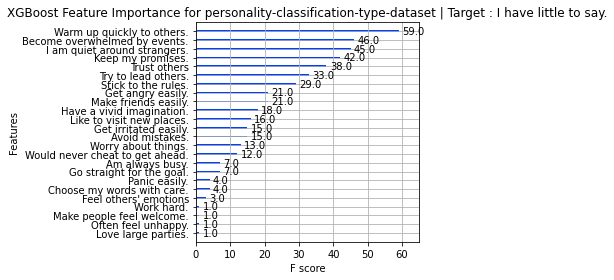

Target Variable: Choose my words with care.
CATS=====================
['Make friends easily.', 'Have a vivid imagination.', 'Trust others', 'Get angry easily.', 'Love large parties.', 'Would never cheat to get ahead.', 'Like order.', 'Often feel unhappy.', 'Take charge.', 'Make people feel welcome.', 'Try to follow the rules.', 'Am easy to satisfy.', 'Go straight for the goal.', 'Often overindulge.', 'Avoid mistakes.', 'Warm up quickly to others.', 'Get irritated easily.', 'Stick to the rules.', 'Try to lead others.', 'Keep my promises.', "Feel others' emotions", 'Like to visit new places.', 'Work hard.', 'Choose my words with care.', 'I have little to say.']
CONTS=====================
['Worry about things.', 'Am always busy.', 'Panic easily.', 'Become overwhelmed by events.', 'I am quiet around strangers.']
30
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['Worry about things.', 'Am always busy.', 'Panic easily.', 'Become overwhelmed 

 10%|▉         | 4/42 [00:00<00:01, 36.64it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.2656789262783452, 'Adjusted R-Squared': 1.5966358723988445, 'RMSE': 0.41060214815408264, 'Time taken': 0.06061911582946777}
{'Model': 'BaggingRegressor', 'R-Squared': 0.030024691358024103, 'Adjusted R-Squared': 1.7881049382716054, 'RMSE': 0.4719093267762492, 'Time taken': 0.026842832565307617}
{'Model': 'BayesianRidge', 'R-Squared': 0.03157267009740106, 'Adjusted R-Squared': 1.7868472055458615, 'RMSE': 0.47153261755303094, 'Time taken': 0.011445760726928711}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.06666666666666632, 'Adjusted R-Squared': 1.7583333333333337, 'RMSE': 0.4629100498862757, 'Time taken': 0.009993314743041992}
{'Model': 'DummyRegressor', 'R-Squared': -0.022222222222222587, 'Adjusted R-Squared': 1.8305555555555557, 'RMSE': 0.48445214165180484, 'Time taken': 0.0101470947265625}
{'Model': 'ElasticNet', 'R-Squared': -0.022222222222222587, 'Adjusted R-Squared': 1.8305555555555557, 'RMSE': 0.48445214165180484, 'Time taken': 0.

 26%|██▌       | 11/42 [00:00<00:01, 19.00it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.1214769494955591, 'Adjusted R-Squared': 1.7137999785348583, 'RMSE': 0.4491121472183543, 'Time taken': 0.2778325080871582}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.37777777777777755, 'Adjusted R-Squared': 1.5055555555555558, 'RMSE': 0.3779644730092272, 'Time taken': 0.011327743530273438}
{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.19916888888888862, 'Adjusted R-Squared': 1.650675277777778, 'RMSE': 0.4287939898299482, 'Time taken': 0.11059832572937012}
{'Model': 'GammaRegressor', 'R-Squared': -0.00704905911932352, 'Adjusted R-Squared': 1.8182273605344503, 'RMSE': 0.48084326257643534, 'Time taken': 0.012385845184326172}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -9.994804020395987, 'Adjusted R-Squared': 9.93327826657174, 'RMSE': 1.5888100105364111, 'Time taken': 0.012167692184448242}


 33%|███▎      | 14/42 [00:00<00:01, 17.11it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.15464971491345436, 'Adjusted R-Squared': 1.6868471066328183, 'RMSE': 0.44055138705628544, 'Time taken': 0.07892680168151855}
{'Model': 'HistGradientBoostingRegressor', 'R-Squared': -0.11854341904108368, 'Adjusted R-Squared': 1.9088165279708806, 'RMSE': 0.5067627038813597, 'Time taken': 0.08263587951660156}
{'Model': 'HuberRegressor', 'R-Squared': 0.0046756718745012416, 'Adjusted R-Squared': 1.8087010166019677, 'RMSE': 0.4780359198230383, 'Time taken': 0.040647268295288086}
{'Model': 'KNeighborsRegressor', 'R-Squared': -0.04533333333333389, 'Adjusted R-Squared': 1.849333333333334, 'RMSE': 0.48989794855663565, 'Time taken': 0.012816905975341797}
{'Model': 'KernelRidge', 'R-Squared': -9.7209599069373, 'Adjusted R-Squared': 9.710779924386555, 'RMSE': 1.56889925635547, 'Time taken': 0.01096653938293457}
{'Model': 'Lars', 'R-Squared': -934332.7313411526, 'Adjusted R-Squared': 759147.1567146864, 'RMSE': 463.15806967146233, 'Time taken': 0.

 48%|████▊     | 20/42 [00:01<00:01, 16.95it/s]

{'Model': 'LassoCV', 'R-Squared': 0.1377482661247873, 'Adjusted R-Squared': 1.7005795337736103, 'RMSE': 0.4449336571985586, 'Time taken': 0.26316213607788086}
{'Model': 'LassoLars', 'R-Squared': -0.022222222222222587, 'Adjusted R-Squared': 1.8305555555555557, 'RMSE': 0.48445214165180484, 'Time taken': 0.01230168342590332}
{'Model': 'LassoLarsCV', 'R-Squared': 0.15614734472287561, 'Adjusted R-Squared': 1.6856302824126637, 'RMSE': 0.44016097175751895, 'Time taken': 0.03795671463012695}
{'Model': 'LassoLarsIC', 'R-Squared': 0.20268765485663953, 'Adjusted R-Squared': 1.6478162804289804, 'RMSE': 0.4278509153580371, 'Time taken': 0.018137216567993164}
{'Model': 'LinearRegression', 'R-Squared': -0.3393003409480879, 'Adjusted R-Squared': 2.0881815270203212, 'RMSE': 0.5545199953271956, 'Time taken': 0.010854005813598633}
{'Model': 'LinearSVR', 'R-Squared': 0.05951079825182204, 'Adjusted R-Squared': 1.7641474764203946, 'RMSE': 0.4646812275727417, 'Time taken': 0.014356374740600586}


 76%|███████▌  | 32/42 [00:01<00:00, 25.58it/s]

{'Model': 'MLPRegressor', 'R-Squared': -1.116218398676693, 'Adjusted R-Squared': 2.719427448924813, 'RMSE': 0.6970412248095047, 'Time taken': 0.10860848426818848}
{'Model': 'NuSVR', 'R-Squared': -0.027198093097969833, 'Adjusted R-Squared': 1.8345984506421005, 'RMSE': 0.4856297940661568, 'Time taken': 0.012182235717773438}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.22117924032133185, 'Adjusted R-Squared': 1.632791867238918, 'RMSE': 0.4228603654892889, 'Time taken': 0.010942935943603516}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.1485616679373064, 'Adjusted R-Squared': 1.6917936448009385, 'RMSE': 0.4421349234392121, 'Time taken': 0.016213178634643555}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -0.26656145222346406, 'Adjusted R-Squared': 2.0290811799315644, 'RMSE': 0.5392514906361838, 'Time taken': 0.010603666305541992}
{'Model': 'PoissonRegressor', 'R-Squared': 0.017387527681011705, 'Adjusted R-Squared': 1.798372633759178, 'RMSE': 0.4749734753837681, 'Ti

 83%|████████▎ | 35/42 [00:01<00:00, 18.98it/s]

{'Model': 'RANSACRegressor', 'R-Squared': 0.001375392965912603, 'Adjusted R-Squared': 1.811382493215196, 'RMSE': 0.4788277954937641, 'Time taken': 0.15694475173950195}
{'Model': 'RandomForestRegressor', 'R-Squared': 0.22684827160493792, 'Adjusted R-Squared': 1.628185779320988, 'RMSE': 0.4213185557233688, 'Time taken': 0.14008641242980957}
{'Model': 'Ridge', 'R-Squared': -0.21066971154919512, 'Adjusted R-Squared': 1.983669140633721, 'RMSE': 0.5272190083386995, 'Time taken': 0.011185646057128906}
{'Model': 'RidgeCV', 'R-Squared': -0.03367851599023575, 'Adjusted R-Squared': 1.8398637942420666, 'RMSE': 0.48715926459361397, 'Time taken': 0.012397289276123047}
{'Model': 'SGDRegressor', 'R-Squared': -0.011433834814992938, 'Adjusted R-Squared': 1.8217899907871817, 'RMSE': 0.4818889414281979, 'Time taken': 0.010886907577514648}
{'Model': 'SVR', 'R-Squared': -0.06134499618750877, 'Adjusted R-Squared': 1.8623428094023509, 'RMSE': 0.49363564203151566, 'Time taken': 0.010815143585205078}
{'Model': 

100%|██████████| 42/42 [00:02<00:00, 18.65it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.3092841883319324, 'Adjusted R-Squared': 1.561206596980305, 'RMSE': 0.39822444, 'Time taken': 0.37082672119140625}
{'Model': 'LGBMRegressor', 'R-Squared': -0.11854341904108368, 'Adjusted R-Squared': 1.9088165279708806, 'RMSE': 0.5067627038813597, 'Time taken': 0.04157376289367676}
Project: personality-classification-type-dataset
personality-classification-type-dataset
Target: Choose my words with care.
Choose my words with care.
Target Standard Deviation: 0.4948716593053935
                               Adjusted R-Squared  R-Squared   RMSE  \
Model                                                                 
Lars                                    759147.16 -934332.73 463.16   
GaussianProcessRegressor                     9.93      -9.99   1.59   
KernelRidge                                  9.71      -9.72   1.57   
MLPRegressor                                 2.72      -1.12   0.70   
QuantileRegressor                            2.26      

Better model found at epoch 0 with _rmse value: 1.5165057182312012.
No improvement since epoch 0: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       1       1.09
1       1       1.51
2       2       2.03
3       2       1.00
4       2       2.03
XGBoost RMSE:  0.39752275


<Figure size 432x288 with 0 Axes>

<Figure size 720x720 with 0 Axes>

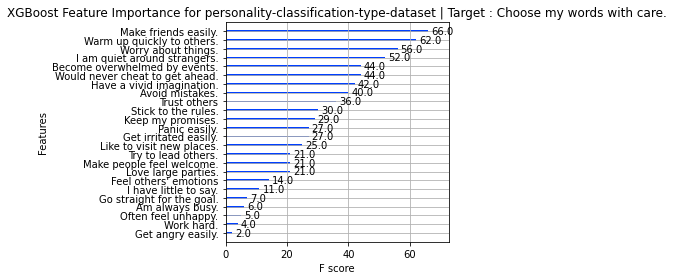

Target Variable: Become overwhelmed by events.
CATS=====================
['Make friends easily.', 'Have a vivid imagination.', 'Trust others', 'Get angry easily.', 'Love large parties.', 'Would never cheat to get ahead.', 'Like order.', 'Often feel unhappy.', 'Take charge.', 'Make people feel welcome.', 'Try to follow the rules.', 'Am easy to satisfy.', 'Go straight for the goal.', 'Often overindulge.', 'Avoid mistakes.', 'Warm up quickly to others.', 'Get irritated easily.', 'Stick to the rules.', 'Try to lead others.', 'Keep my promises.', "Feel others' emotions", 'Like to visit new places.', 'Work hard.', 'Choose my words with care.', 'I have little to say.']
CONTS=====================
['Worry about things.', 'Am always busy.', 'Panic easily.', 'I am quiet around strangers.']
29
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['Worry about things.', 'Am always busy.', 'Panic easily.', 'I am quiet around strangers.']
Categorical variab

  5%|▍         | 2/42 [00:00<00:02, 19.20it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.8543810326060604, 'Adjusted R-Squared': 1.118315411007576, 'RMSE': 0.38160053379671743, 'Time taken': 0.07659292221069336}
{'Model': 'BaggingRegressor', 'R-Squared': 0.7185714285714286, 'Adjusted R-Squared': 1.2286607142857142, 'RMSE': 0.530498417932204, 'Time taken': 0.027392864227294922}
{'Model': 'BayesianRidge', 'R-Squared': 0.5032013324631357, 'Adjusted R-Squared': 1.4036489173737023, 'RMSE': 0.7048394622443215, 'Time taken': 0.01325845718383789}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.9285714285714286, 'Adjusted R-Squared': 1.0580357142857142, 'RMSE': 0.2672612419124244, 'Time taken': 0.011383056640625}
{'Model': 'DummyRegressor', 'R-Squared': -0.007971938775510168, 'Adjusted R-Squared': 1.8189772002551021, 'RMSE': 1.0039780569193284, 'Time taken': 0.010909557342529297}
{'Model': 'ElasticNet', 'R-Squared': -0.007971877764378243, 'Adjusted R-Squared': 1.8189771506835575, 'RMSE': 1.003978, 'Time taken': 0.012715816497802734}


 21%|██▏       | 9/42 [00:00<00:02, 16.36it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.5238450151602072, 'Adjusted R-Squared': 1.3868759251823317, 'RMSE': 0.6900398, 'Time taken': 0.26879215240478516}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.9285714285714286, 'Adjusted R-Squared': 1.0580357142857142, 'RMSE': 0.2672612419124244, 'Time taken': 0.011297464370727539}
{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.9706428571428571, 'Adjusted R-Squared': 1.0238526785714286, 'RMSE': 0.1713392624506796, 'Time taken': 0.10922598838806152}
GammaRegressor model failed to execute
Some value(s) of y are out of the valid range for family GammaDistribution
{'Model': 'GaussianProcessRegressor', 'R-Squared': 0.025728921018809747, 'Adjusted R-Squared': 1.7915952516722171, 'RMSE': 0.9870517103886657, 'Time taken': 0.012145042419433594}


 36%|███▌      | 15/42 [00:00<00:01, 21.00it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.9854017016907601, 'Adjusted R-Squared': 1.0118611173762573, 'RMSE': 0.1208234178842819, 'Time taken': 0.08539843559265137}
{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.5779792786593119, 'Adjusted R-Squared': 1.3428918360893092, 'RMSE': 0.6496312194935586, 'Time taken': 0.07480263710021973}
{'Model': 'HuberRegressor', 'R-Squared': 0.7757957309534149, 'Adjusted R-Squared': 1.1821659686003505, 'RMSE': 0.47350213204016844, 'Time taken': 0.03745412826538086}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.27714285714285725, 'Adjusted R-Squared': 1.5873214285714283, 'RMSE': 0.8502100580780863, 'Time taken': 0.01063227653503418}
{'Model': 'KernelRidge', 'R-Squared': 0.5395687235120152, 'Adjusted R-Squared': 1.3741004121464875, 'RMSE': 0.6785509, 'Time taken': 0.020587682723999023}
{'Model': 'Lars', 'R-Squared': 0.5839075964966989, 'Adjusted R-Squared': 1.338075077846432, 'RMSE': 0.6450522, 'Time taken': 0.014849424362182617}


 43%|████▎     | 18/42 [00:00<00:01, 22.65it/s]

{'Model': 'LarsCV', 'R-Squared': 0.5334902081937929, 'Adjusted R-Squared': 1.3790392058425431, 'RMSE': 0.6830152, 'Time taken': 0.07522153854370117}
{'Model': 'Lasso', 'R-Squared': -0.007971877764378243, 'Adjusted R-Squared': 1.8189771506835575, 'RMSE': 1.003978, 'Time taken': 0.011148452758789062}


 50%|█████     | 21/42 [00:01<00:01, 16.77it/s]

{'Model': 'LassoCV', 'R-Squared': 0.5391211806729967, 'Adjusted R-Squared': 1.3744640407031903, 'RMSE': 0.6788806, 'Time taken': 0.2499082088470459}
{'Model': 'LassoLars', 'R-Squared': -0.007971877764378243, 'Adjusted R-Squared': 1.8189771506835575, 'RMSE': 1.003978, 'Time taken': 0.011667728424072266}
{'Model': 'LassoLarsCV', 'R-Squared': 0.5349054245660747, 'Adjusted R-Squared': 1.3778893425400642, 'RMSE': 0.6819784, 'Time taken': 0.0480046272277832}
{'Model': 'LassoLarsIC', 'R-Squared': 0.5364197879458256, 'Adjusted R-Squared': 1.3766589222940167, 'RMSE': 0.68086725, 'Time taken': 0.022840023040771484}
{'Model': 'LinearRegression', 'R-Squared': 0.38725596480071545, 'Adjusted R-Squared': 1.4978545285994187, 'RMSE': 0.7827797, 'Time taken': 0.010375738143920898}
{'Model': 'LinearSVR', 'R-Squared': 0.7482541551547448, 'Adjusted R-Squared': 1.2045434989367698, 'RMSE': 0.5017428074673868, 'Time taken': 0.013379096984863281}


 62%|██████▏   | 26/42 [00:01<00:00, 19.45it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.5296827356963019, 'Adjusted R-Squared': 1.3821327772467549, 'RMSE': 0.68579686, 'Time taken': 0.10822749137878418}
{'Model': 'NuSVR', 'R-Squared': 0.30517830033273596, 'Adjusted R-Squared': 1.564542630979652, 'RMSE': 0.8335596557339277, 'Time taken': 0.010828495025634766}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.37077053268302085, 'Adjusted R-Squared': 1.5112489421950457, 'RMSE': 0.7932398548465521, 'Time taken': 0.010018110275268555}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.26391754771905596, 'Adjusted R-Squared': 1.598066992478267, 'RMSE': 0.8579524767030771, 'Time taken': 0.015198707580566406}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -0.2808866845451854, 'Adjusted R-Squared': 2.0407204311929634, 'RMSE': 1.1317626449680982, 'Time taken': 0.010022640228271484}
PoissonRegressor model failed to execute
Some value(s) of y are out of the valid range for family PoissonDistribution


 76%|███████▌  | 32/42 [00:01<00:00, 22.14it/s]

{'Model': 'QuantileRegressor', 'R-Squared': 3.579558871535937e-11, 'Adjusted R-Squared': 1.8124999999709162, 'RMSE': 0.9999999999821022, 'Time taken': 0.16122031211853027}
{'Model': 'RANSACRegressor', 'R-Squared': -0.37840667832642794, 'Adjusted R-Squared': 2.1199554261402227, 'RMSE': 1.1740557, 'Time taken': 0.16318726539611816}


 83%|████████▎ | 35/42 [00:01<00:00, 16.75it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.853592857142857, 'Adjusted R-Squared': 1.1189558035714287, 'RMSE': 0.38263186335842825, 'Time taken': 0.14304232597351074}
{'Model': 'Ridge', 'R-Squared': 0.5571911782026291, 'Adjusted R-Squared': 1.3597821677103639, 'RMSE': 0.66543883, 'Time taken': 0.012334108352661133}
{'Model': 'RidgeCV', 'R-Squared': 0.5792829857123485, 'Adjusted R-Squared': 1.341832574108717, 'RMSE': 0.6486270224772103, 'Time taken': 0.01247859001159668}
{'Model': 'SGDRegressor', 'R-Squared': 0.5679125240815681, 'Adjusted R-Squared': 1.351071074183726, 'RMSE': 0.6573336108236304, 'Time taken': 0.010754108428955078}
{'Model': 'SVR', 'R-Squared': 0.30726685039992074, 'Adjusted R-Squared': 1.5628456840500644, 'RMSE': 0.8323059230836215, 'Time taken': 0.010618209838867188}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.38725596480071545, 'Adjusted R-Squared': 1.4978545285994187, 'RMSE': 0.7827797, 'Time taken': 0.010898828506469727}
{'Model': 'TweedieRegressor

100%|██████████| 42/42 [00:02<00:00, 17.72it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.8461734802727601, 'Adjusted R-Squared': 1.1249840472783825, 'RMSE': 0.39220724, 'Time taken': 0.36179256439208984}
{'Model': 'LGBMRegressor', 'R-Squared': 0.5779792786593119, 'Adjusted R-Squared': 1.3428918360893092, 'RMSE': 0.6496312194935586, 'Time taken': 0.03737473487854004}
Project: personality-classification-type-dataset
personality-classification-type-dataset
Target: Become overwhelmed by events.
Become overwhelmed by events.
Target Standard Deviation: 1.0049304473851077
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
RANSACRegressor                              2.12      -0.38  1.17        0.16
PassiveAggressiveRegressor                   2.04      -0.28  1.13        0.01
DummyRegressor                               1.82      -0.01  1.00        0.01
ElasticNet                                   1.82      -0.01  1.00        0.01
La

Better model found at epoch 0 with _rmse value: 9.465304374694824.
No improvement since epoch 0: early stopping


<Figure size 432x288 with 0 Axes>

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
   actual  predicted
0       1       1.00
1      -1      -1.00
2       1       0.49
3       0      -0.00
4       1       1.00
XGBoost RMSE:  0.39220724


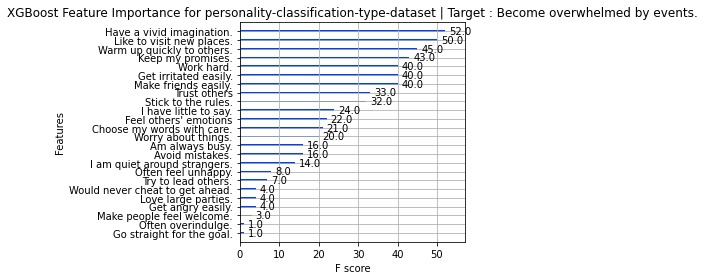

Target Variable: Work hard.
CATS=====================
['Make friends easily.', 'Have a vivid imagination.', 'Trust others', 'Get angry easily.', 'Love large parties.', 'Would never cheat to get ahead.', 'Like order.', 'Often feel unhappy.', 'Take charge.', 'Make people feel welcome.', 'Try to follow the rules.', 'Am easy to satisfy.', 'Go straight for the goal.', 'Often overindulge.', 'Avoid mistakes.', 'Warm up quickly to others.', 'Get irritated easily.', 'Stick to the rules.', 'Try to lead others.', 'Keep my promises.', "Feel others' emotions", 'Like to visit new places.', 'Work hard.', 'Choose my words with care.', 'I have little to say.']
CONTS=====================
['Worry about things.', 'Am always busy.', 'Panic easily.', 'Become overwhelmed by events.', 'I am quiet around strangers.']
30
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['Worry about things.', 'Am always busy.', 'Panic easily.', 'Become overwhelmed by events.', 'I 

  5%|▍         | 2/42 [00:00<00:02, 18.48it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.6958691237567955, 'Adjusted R-Squared': 1.2471063369476036, 'RMSE': 0.3879610160538095, 'Time taken': 0.07961273193359375}
{'Model': 'BaggingRegressor', 'R-Squared': 0.7582474226804123, 'Adjusted R-Squared': 1.196423969072165, 'RMSE': 0.3458942860800929, 'Time taken': 0.028402328491210938}
{'Model': 'BayesianRidge', 'R-Squared': 0.6826254156661251, 'Adjusted R-Squared': 1.2578668497712733, 'RMSE': 0.396318097093233, 'Time taken': 0.015189409255981445}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.2783505154639173, 'Adjusted R-Squared': 1.5863402061855671, 'RMSE': 0.5976143046671968, 'Time taken': 0.012219905853271484}
{'Model': 'DummyRegressor', 'R-Squared': -0.01030927835051565, 'Adjusted R-Squared': 1.820876288659794, 'RMSE': 0.7071067811865475, 'Time taken': 0.010076284408569336}
{'Model': 'ElasticNet', 'R-Squared': -0.01030927835051565, 'Adjusted R-Squared': 1.820876288659794, 'RMSE': 0.7071067811865475, 'Time taken': 0.010775566101

 21%|██▏       | 9/42 [00:00<00:01, 18.09it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.680508621181166, 'Adjusted R-Squared': 1.2595867452903027, 'RMSE': 0.39763756280590357, 'Time taken': 0.20794034004211426}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.8556701030927835, 'Adjusted R-Squared': 1.1172680412371134, 'RMSE': 0.2672612419124244, 'Time taken': 0.012559890747070312}
{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.8647592783505154, 'Adjusted R-Squared': 1.1098830863402063, 'RMSE': 0.25870902021935216, 'Time taken': 0.1107947826385498}
{'Model': 'GammaRegressor', 'R-Squared': 0.5913272494977972, 'Adjusted R-Squared': 1.3320466097830397, 'RMSE': 0.44972359310749827, 'Time taken': 0.014811038970947266}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -7.450929143932388, 'Adjusted R-Squared': 7.866379929445065, 'RMSE': 2.0450788704932545, 'Time taken': 0.013056516647338867}


 36%|███▌      | 15/42 [00:00<00:01, 21.70it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.8607987733550967, 'Adjusted R-Squared': 1.113100996648984, 'RMSE': 0.26246981346895226, 'Time taken': 0.08725619316101074}
{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.17237910908918408, 'Adjusted R-Squared': 1.672441973865038, 'RMSE': 0.6399905389062688, 'Time taken': 0.0742640495300293}
{'Model': 'HuberRegressor', 'R-Squared': 0.6033767831487635, 'Adjusted R-Squared': 1.3222563636916296, 'RMSE': 0.4430440391028193, 'Time taken': 0.0373077392578125}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.4804123711340206, 'Adjusted R-Squared': 1.4221649484536083, 'RMSE': 0.50709255283711, 'Time taken': 0.011299610137939453}
{'Model': 'KernelRidge', 'R-Squared': -7.976535324240674, 'Adjusted R-Squared': 8.293434950945548, 'RMSE': 2.10771653988549, 'Time taken': 0.011617898941040039}
{'Model': 'Lars', 'R-Squared': -2.3025191434872374, 'Adjusted R-Squared': 3.6832968040833802, 'RMSE': 1.27844045003154, 'Time taken': 0.01529788970

 60%|█████▉    | 25/42 [00:01<00:00, 25.74it/s]

{'Model': 'LassoCV', 'R-Squared': 0.6458833072579587, 'Adjusted R-Squared': 1.2877198128529086, 'RMSE': 0.41863065887594536, 'Time taken': 0.20629167556762695}
{'Model': 'LassoLars', 'R-Squared': -0.01030927835051565, 'Adjusted R-Squared': 1.820876288659794, 'RMSE': 0.7071067811865475, 'Time taken': 0.012476921081542969}
{'Model': 'LassoLarsCV', 'R-Squared': 0.6317369452275026, 'Adjusted R-Squared': 1.2992137320026542, 'RMSE': 0.4269105693815208, 'Time taken': 0.043784379959106445}
{'Model': 'LassoLarsIC', 'R-Squared': 0.6849072393531641, 'Adjusted R-Squared': 1.2560128680255542, 'RMSE': 0.3948908256691573, 'Time taken': 0.017073869705200195}
{'Model': 'LinearRegression', 'R-Squared': 0.32895482213980154, 'Adjusted R-Squared': 1.5452242070114113, 'RMSE': 0.5762802174663445, 'Time taken': 0.010711193084716797}
{'Model': 'LinearSVR', 'R-Squared': 0.5596493962906741, 'Adjusted R-Squared': 1.3577848655138274, 'RMSE': 0.466828250110299, 'Time taken': 0.015045404434204102}


 76%|███████▌  | 32/42 [00:01<00:00, 23.56it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.10206166715224974, 'Adjusted R-Squared': 1.729574895438797, 'RMSE': 0.6666242182812905, 'Time taken': 0.12057876586914062}
{'Model': 'NuSVR', 'R-Squared': 0.5646833411171459, 'Adjusted R-Squared': 1.353694785342319, 'RMSE': 0.46415226605046295, 'Time taken': 0.012127399444580078}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.2906765658568974, 'Adjusted R-Squared': 1.5763252902412708, 'RMSE': 0.5924885821335093, 'Time taken': 0.010853052139282227}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.44611465491608515, 'Adjusted R-Squared': 1.4500318428806809, 'RMSE': 0.5235615789033551, 'Time taken': 0.016386985778808594}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.5335985380518711, 'Adjusted R-Squared': 1.3789511878328549, 'RMSE': 0.4804384785572558, 'Time taken': 0.012689352035522461}
{'Model': 'PoissonRegressor', 'R-Squared': 0.6573827743466032, 'Adjusted R-Squared': 1.278376495843385, 'RMSE': 0.4117773254527721, 'Time ta

 83%|████████▎ | 35/42 [00:01<00:00, 17.22it/s]

{'Model': 'RANSACRegressor', 'R-Squared': -0.21390059407929307, 'Adjusted R-Squared': 1.9862942326894255, 'RMSE': 0.7750851093019985, 'Time taken': 0.15425682067871094}
{'Model': 'RandomForestRegressor', 'R-Squared': 0.801392029925544, 'Adjusted R-Squared': 1.1613689756854955, 'RMSE': 0.31351344320054336, 'Time taken': 0.1374063491821289}
{'Model': 'Ridge', 'R-Squared': 0.6758345791513858, 'Adjusted R-Squared': 1.263384404439499, 'RMSE': 0.4005356478715668, 'Time taken': 0.010947704315185547}
{'Model': 'RidgeCV', 'R-Squared': 0.7180773771181874, 'Adjusted R-Squared': 1.2290621310914727, 'RMSE': 0.37352768399667174, 'Time taken': 0.011966705322265625}
{'Model': 'SGDRegressor', 'R-Squared': 0.7577296726877834, 'Adjusted R-Squared': 1.1968446409411762, 'RMSE': 0.34626448064676885, 'Time taken': 0.010823726654052734}
{'Model': 'SVR', 'R-Squared': 0.5588519298138434, 'Adjusted R-Squared': 1.3584328070262524, 'RMSE': 0.46725076739684956, 'Time taken': 0.010448694229125977}
{'Model': 'Transfo

100%|██████████| 42/42 [00:02<00:00, 19.10it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.8997015964290317, 'Adjusted R-Squared': 1.0814924529014118, 'RMSE': 0.2227947, 'Time taken': 0.362637996673584}
{'Model': 'LGBMRegressor', 'R-Squared': 0.17237910908918408, 'Adjusted R-Squared': 1.672441973865038, 'RMSE': 0.6399905389062688, 'Time taken': 0.03168678283691406}
Project: personality-classification-type-dataset
personality-classification-type-dataset
Target: Work hard.
Work hard.
Target Standard Deviation: 0.6388765649999399
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
KernelRidge                                  8.29      -7.98  2.11        0.01
GaussianProcessRegressor                     7.87      -7.45  2.05        0.01
Lars                                         3.68      -2.30  1.28        0.02
RANSACRegressor                              1.99      -0.21  0.78        0.15
LassoLars                                  

Better model found at epoch 0 with _rmse value: 1.9912939071655273.
No improvement since epoch 0: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       2       2.90
1       3       2.72
2       1       1.23
3       3       2.97
4       2       2.01
XGBoost RMSE:  0.26533973


<Figure size 432x288 with 0 Axes>

<Figure size 720x720 with 0 Axes>

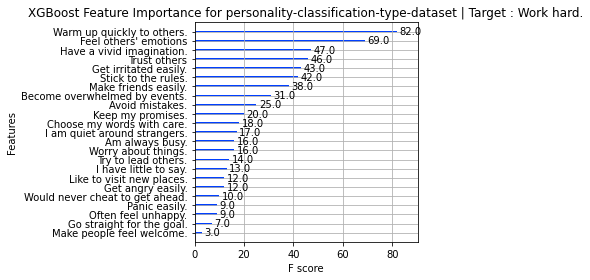

Target Variable: Like to visit new places.
CATS=====================
['Make friends easily.', 'Have a vivid imagination.', 'Trust others', 'Get angry easily.', 'Love large parties.', 'Would never cheat to get ahead.', 'Like order.', 'Often feel unhappy.', 'Take charge.', 'Make people feel welcome.', 'Try to follow the rules.', 'Am easy to satisfy.', 'Go straight for the goal.', 'Often overindulge.', 'Avoid mistakes.', 'Warm up quickly to others.', 'Get irritated easily.', 'Stick to the rules.', 'Try to lead others.', 'Keep my promises.', "Feel others' emotions", 'Like to visit new places.', 'Work hard.', 'Choose my words with care.', 'I have little to say.']
CONTS=====================
['Worry about things.', 'Am always busy.', 'Panic easily.', 'Become overwhelmed by events.', 'I am quiet around strangers.']
30
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['Worry about things.', 'Am always busy.', 'Panic easily.', 'Become overwhelmed b

  5%|▍         | 2/42 [00:00<00:02, 19.50it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.985326278659612, 'Adjusted R-Squared': 1.0119223985890653, 'RMSE': 0.09673800003492762, 'Time taken': 0.07633757591247559}
{'Model': 'BaggingRegressor', 'R-Squared': 0.9339200000000001, 'Adjusted R-Squared': 1.05369, 'RMSE': 0.2052872551885701, 'Time taken': 0.026047945022583008}
{'Model': 'BayesianRidge', 'R-Squared': 0.4679505648730221, 'Adjusted R-Squared': 1.4322901660406695, 'RMSE': 0.5825094349366063, 'Time taken': 0.012599945068359375}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.01172327995300293}
{'Model': 'DummyRegressor', 'R-Squared': -0.0844999999999998, 'Adjusted R-Squared': 1.8811562499999999, 'RMSE': 0.8316522158710726, 'Time taken': 0.009828329086303711}
{'Model': 'ElasticNet', 'R-Squared': -0.0844999999999998, 'Adjusted R-Squared': 1.8811562499999999, 'RMSE': 0.8316522158710726, 'Time taken': 0.010248184204101562}


 21%|██▏       | 9/42 [00:00<00:01, 18.80it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.2940786990428914, 'Adjusted R-Squared': 1.5735610570276508, 'RMSE': 0.6709731077507403, 'Time taken': 0.20264577865600586}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.01230168342590332}
{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.8924015999999999, 'Adjusted R-Squared': 1.0874237, 'RMSE': 0.26195692121306624, 'Time taken': 0.10708451271057129}
{'Model': 'GammaRegressor', 'R-Squared': 0.38917143223010053, 'Adjusted R-Squared': 1.4962982113130434, 'RMSE': 0.6241466458834317, 'Time taken': 0.013971805572509766}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -6.5882984789466565, 'Adjusted R-Squared': 7.165492514144159, 'RMSE': 2.1998809219493665, 'Time taken': 0.014097452163696289}


 36%|███▌      | 15/42 [00:00<00:01, 21.34it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.9999999992348767, 'Adjusted R-Squared': 1.0000000006216627, 'RMSE': 2.208984624172286e-05, 'Time taken': 0.0903010368347168}
{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.7496046429902607, 'Adjusted R-Squared': 1.2034462275704132, 'RMSE': 0.3996134588077495, 'Time taken': 0.07985663414001465}
{'Model': 'HuberRegressor', 'R-Squared': -0.003487454145007618, 'Adjusted R-Squared': 1.8153335564928188, 'RMSE': 0.7999870272166469, 'Time taken': 0.04152035713195801}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.20255999999999985, 'Adjusted R-Squared': 1.64792, 'RMSE': 0.7131419413913535, 'Time taken': 0.011220216751098633}
{'Model': 'KernelRidge', 'R-Squared': -9.038138826939363, 'Adjusted R-Squared': 9.155987796888233, 'RMSE': 2.5301925325703167, 'Time taken': 0.011556863784790039}
{'Model': 'Lars', 'R-Squared': -0.8224629753589241, 'Adjusted R-Squared': 2.480751167479126, 'RMSE': 1.0780932523745987, 'Time taken': 0.015827417

 48%|████▊     | 20/42 [00:00<00:01, 20.28it/s]

{'Model': 'LarsCV', 'R-Squared': 0.2890846836741727, 'Adjusted R-Squared': 1.5776186945147348, 'RMSE': 0.6733423127249298, 'Time taken': 0.04357171058654785}
{'Model': 'Lasso', 'R-Squared': -0.0844999999999998, 'Adjusted R-Squared': 1.8811562499999999, 'RMSE': 0.8316522158710726, 'Time taken': 0.011626958847045898}
{'Model': 'LassoCV', 'R-Squared': 0.2807389768188182, 'Adjusted R-Squared': 1.5843995813347103, 'RMSE': 0.6772830923867039, 'Time taken': 0.17648100852966309}
{'Model': 'LassoLars', 'R-Squared': -0.0844999999999998, 'Adjusted R-Squared': 1.8811562499999999, 'RMSE': 0.8316522158710726, 'Time taken': 0.01235651969909668}


 67%|██████▋   | 28/42 [00:01<00:00, 23.87it/s]

{'Model': 'LassoLarsCV', 'R-Squared': 0.2890846836741727, 'Adjusted R-Squared': 1.5776186945147348, 'RMSE': 0.6733423127249298, 'Time taken': 0.04548382759094238}
{'Model': 'LassoLarsIC', 'R-Squared': 0.2741391033249764, 'Adjusted R-Squared': 1.5897619785484567, 'RMSE': 0.6803833406443885, 'Time taken': 0.01878643035888672}
{'Model': 'LinearRegression', 'R-Squared': -0.028620013852231452, 'Adjusted R-Squared': 1.8357537612549382, 'RMSE': 0.8099429991644818, 'Time taken': 0.010406970977783203}
{'Model': 'LinearSVR', 'R-Squared': 0.48606464712187025, 'Adjusted R-Squared': 1.4175724742134803, 'RMSE': 0.5725075487861925, 'Time taken': 0.013749361038208008}
{'Model': 'MLPRegressor', 'R-Squared': 0.4803421828739851, 'Adjusted R-Squared': 1.4222219764148871, 'RMSE': 0.5756860465457796, 'Time taken': 0.13805055618286133}
{'Model': 'NuSVR', 'R-Squared': 0.48865222129444363, 'Adjusted R-Squared': 1.4154700701982645, 'RMSE': 0.5710644926684786, 'Time taken': 0.011445045471191406}
{'Model': 'Ortho

 76%|███████▌  | 32/42 [00:01<00:00, 25.77it/s]

{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.20246940395648227, 'Adjusted R-Squared': 1.6479936092853582, 'RMSE': 0.7131824497703282, 'Time taken': 0.018880605697631836}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.2704034306951222, 'Adjusted R-Squared': 1.5927972125602132, 'RMSE': 0.6821319040373803, 'Time taken': 0.011773347854614258}
{'Model': 'PoissonRegressor', 'R-Squared': 0.4216941201902823, 'Adjusted R-Squared': 1.4698735273453956, 'RMSE': 0.6073034870547431, 'Time taken': 0.01278996467590332}
{'Model': 'QuantileRegressor', 'R-Squared': -0.007999999890566212, 'Adjusted R-Squared': 1.818999999911085, 'RMSE': 0.8017837256937502, 'Time taken': 0.08472752571105957}


 83%|████████▎ | 35/42 [00:01<00:00, 19.16it/s]

{'Model': 'RANSACRegressor', 'R-Squared': -0.15276053606855977, 'Adjusted R-Squared': 1.936617935555705, 'RMSE': 0.8574257479858127, 'Time taken': 0.1192312240600586}
{'Model': 'RandomForestRegressor', 'R-Squared': 0.9518848000000001, 'Adjusted R-Squared': 1.0390936, 'RMSE': 0.17517338349679226, 'Time taken': 0.13761234283447266}
{'Model': 'Ridge', 'R-Squared': 0.2502077401673277, 'Adjusted R-Squared': 1.6092062111140462, 'RMSE': 0.6915083796882002, 'Time taken': 0.01153421401977539}
{'Model': 'RidgeCV', 'R-Squared': 0.4452699710256228, 'Adjusted R-Squared': 1.4507181485416814, 'RMSE': 0.5947956844443804, 'Time taken': 0.011326074600219727}
{'Model': 'SGDRegressor', 'R-Squared': 0.4504730206805153, 'Adjusted R-Squared': 1.4464906706970813, 'RMSE': 0.591999691528703, 'Time taken': 0.01070857048034668}
{'Model': 'SVR', 'R-Squared': 0.5064898308373693, 'Adjusted R-Squared': 1.4009770124446375, 'RMSE': 0.5610157112706328, 'Time taken': 0.010564804077148438}
{'Model': 'TransformedTargetRegr

100%|██████████| 42/42 [00:02<00:00, 19.97it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.9833890627712023, 'Adjusted R-Squared': 1.0134963864983981, 'RMSE': 0.10292575, 'Time taken': 0.3622112274169922}
{'Model': 'LGBMRegressor', 'R-Squared': 0.7496046429902607, 'Adjusted R-Squared': 1.2034462275704132, 'RMSE': 0.3996134588077495, 'Time taken': 0.023753643035888672}
Project: personality-classification-type-dataset
personality-classification-type-dataset
Target: Like to visit new places.
Like to visit new places.
Target Standard Deviation: 0.7299619084274891
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
KernelRidge                                  9.16      -9.04  2.53        0.01
GaussianProcessRegressor                     7.17      -6.59  2.20        0.01
Lars                                         2.48      -0.82  1.08        0.02
RANSACRegressor                              1.94      -0.15  0.86        0.12
DummyRegre

Better model found at epoch 0 with _rmse value: 2.326354503631592.
No improvement since epoch 0: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       2       2.10
1       1       1.01
2       3       2.78
3       2       2.00
4       2       2.01
XGBoost RMSE:  0.10292575


<Figure size 432x288 with 0 Axes>

<Figure size 720x720 with 0 Axes>

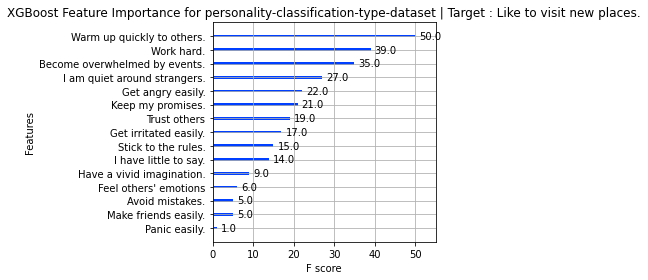

Target Variable: Feel others' emotions
CATS=====================
['Make friends easily.', 'Have a vivid imagination.', 'Trust others', 'Get angry easily.', 'Love large parties.', 'Would never cheat to get ahead.', 'Like order.', 'Often feel unhappy.', 'Take charge.', 'Make people feel welcome.', 'Try to follow the rules.', 'Am easy to satisfy.', 'Go straight for the goal.', 'Often overindulge.', 'Avoid mistakes.', 'Warm up quickly to others.', 'Get irritated easily.', 'Stick to the rules.', 'Try to lead others.', 'Keep my promises.', "Feel others' emotions", 'Like to visit new places.', 'Work hard.', 'Choose my words with care.', 'I have little to say.']
CONTS=====================
['Worry about things.', 'Am always busy.', 'Panic easily.', 'Become overwhelmed by events.', 'I am quiet around strangers.']
30
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['Worry about things.', 'Am always busy.', 'Panic easily.', 'Become overwhelmed by ev

  5%|▍         | 2/42 [00:00<00:02, 18.54it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.6785757643280391, 'Adjusted R-Squared': 1.2611571914834683, 'RMSE': 0.43803035244298266, 'Time taken': 0.07978677749633789}
{'Model': 'BaggingRegressor', 'R-Squared': 0.5692307692307692, 'Adjusted R-Squared': 1.35, 'RMSE': 0.50709255283711, 'Time taken': 0.02791309356689453}
{'Model': 'BayesianRidge', 'R-Squared': -0.010379434759170136, 'Adjusted R-Squared': 1.8209332907418259, 'RMSE': 0.7766174493184088, 'Time taken': 0.013841390609741211}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.7606837606837606, 'Adjusted R-Squared': 1.1944444444444444, 'RMSE': 0.3779644730092272, 'Time taken': 0.012522697448730469}
{'Model': 'DummyRegressor', 'R-Squared': -0.04326923076923084, 'Adjusted R-Squared': 1.84765625, 'RMSE': 0.789156421213727, 'Time taken': 0.010517597198486328}
{'Model': 'ElasticNet', 'R-Squared': -0.04326923076923084, 'Adjusted R-Squared': 1.84765625, 'RMSE': 0.789156421213727, 'Time taken': 0.010516643524169922}


 21%|██▏       | 9/42 [00:00<00:02, 15.21it/s]

{'Model': 'ElasticNetCV', 'R-Squared': -0.05349267614455888, 'Adjusted R-Squared': 1.8559627993674541, 'RMSE': 0.793013636772219, 'Time taken': 0.3108997344970703}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.8803418803418803, 'Adjusted R-Squared': 1.0972222222222223, 'RMSE': 0.2672612419124244, 'Time taken': 0.011479377746582031}
{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.7968683760683761, 'Adjusted R-Squared': 1.1650444444444443, 'RMSE': 0.34821996332367683, 'Time taken': 0.10807061195373535}
{'Model': 'GammaRegressor', 'R-Squared': 0.032899808351510296, 'Adjusted R-Squared': 1.7857689057143977, 'RMSE': 0.759802345480937, 'Time taken': 0.01406407356262207}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -8.055941445443468, 'Adjusted R-Squared': 8.357952424422818, 'RMSE': 2.325046794697933, 'Time taken': 0.012627124786376953}


 36%|███▌      | 15/42 [00:00<00:01, 19.95it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.8671058061323197, 'Adjusted R-Squared': 1.1079765325174902, 'RMSE': 0.2816552810791745, 'Time taken': 0.08301138877868652}
{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.05643683698379354, 'Adjusted R-Squared': 1.7666450699506677, 'RMSE': 0.7504994597915641, 'Time taken': 0.0743556022644043}
{'Model': 'HuberRegressor', 'R-Squared': 0.09421116313532685, 'Adjusted R-Squared': 1.735953429952547, 'RMSE': 0.7353233840622846, 'Time taken': 0.0367436408996582}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.2772649572649576, 'Adjusted R-Squared': 1.587222222222222, 'RMSE': 0.6568322247184369, 'Time taken': 0.0107269287109375}
{'Model': 'KernelRidge', 'R-Squared': -8.057169455367868, 'Adjusted R-Squared': 8.358950182486392, 'RMSE': 2.325204430641684, 'Time taken': 0.01117253303527832}
{'Model': 'Lars', 'R-Squared': -0.39012387237065793, 'Adjusted R-Squared': 2.1294756463011595, 'RMSE': 0.9109439292187219, 'Time taken': 0.01486396

 60%|█████▉    | 25/42 [00:01<00:00, 22.07it/s]

{'Model': 'LassoCV', 'R-Squared': -0.047028717466411685, 'Adjusted R-Squared': 1.8507108329414594, 'RMSE': 0.7905770301042266, 'Time taken': 0.2906219959259033}
{'Model': 'LassoLars', 'R-Squared': -0.04326923076923084, 'Adjusted R-Squared': 1.84765625, 'RMSE': 0.789156421213727, 'Time taken': 0.01352071762084961}
{'Model': 'LassoLarsCV', 'R-Squared': -0.029110288539597073, 'Adjusted R-Squared': 1.8361521094384226, 'RMSE': 0.7837830283348701, 'Time taken': 0.04532933235168457}
{'Model': 'LassoLarsIC', 'R-Squared': -0.16752428481483617, 'Adjusted R-Squared': 1.9486134814120544, 'RMSE': 0.8348296334916454, 'Time taken': 0.019715309143066406}
{'Model': 'LinearRegression', 'R-Squared': -0.4288823071074692, 'Adjusted R-Squared': 2.160966874524819, 'RMSE': 0.9235557669967354, 'Time taken': 0.011476993560791016}
{'Model': 'LinearSVR', 'R-Squared': -0.040872932725072975, 'Adjusted R-Squared': 1.8457092578391219, 'RMSE': 0.7882495885965435, 'Time taken': 0.015432357788085938}


 67%|██████▋   | 28/42 [00:01<00:00, 21.67it/s]

{'Model': 'MLPRegressor', 'R-Squared': -0.3499852963010166, 'Adjusted R-Squared': 2.096863053244576, 'RMSE': 0.8976962569436886, 'Time taken': 0.12063193321228027}
{'Model': 'NuSVR', 'R-Squared': 0.21335240444493053, 'Adjusted R-Squared': 1.639151171388494, 'RMSE': 0.6852594052245393, 'Time taken': 0.011844873428344727}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': -0.13214050301390667, 'Adjusted R-Squared': 1.9198641586987992, 'RMSE': 0.8220818484643898, 'Time taken': 0.011443138122558594}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.07777352128422499, 'Adjusted R-Squared': 1.7493090139565672, 'RMSE': 0.7419654607511605, 'Time taken': 0.0188143253326416}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -0.6867494613219045, 'Adjusted R-Squared': 2.3704839373240474, 'RMSE': 1.0034371719415192, 'Time taken': 0.010925054550170898}
{'Model': 'PoissonRegressor', 'R-Squared': -0.03406584884647135, 'Adjusted R-Squared': 1.840178502187758, 'RMSE': 0.7856678697817115, 'Time

 76%|███████▌  | 32/42 [00:01<00:00, 21.67it/s]

{'Model': 'QuantileRegressor', 'R-Squared': -0.07692307692008882, 'Adjusted R-Squared': 1.8749999999975722, 'RMSE': 0.8017837257361607, 'Time taken': 0.14047789573669434}
{'Model': 'RANSACRegressor', 'R-Squared': -0.9599290840315506, 'Adjusted R-Squared': 2.592442380775635, 'RMSE': 1.0816458142611332, 'Time taken': 0.15505266189575195}


 83%|████████▎ | 35/42 [00:01<00:00, 16.26it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.5958427350427351, 'Adjusted R-Squared': 1.3283777777777777, 'RMSE': 0.4911793387930144, 'Time taken': 0.1459369659423828}
{'Model': 'Ridge', 'R-Squared': -0.3524287431593005, 'Adjusted R-Squared': 2.0988483538169316, 'RMSE': 0.8985082959585388, 'Time taken': 0.011563301086425781}
{'Model': 'RidgeCV', 'R-Squared': -0.21039842337942183, 'Adjusted R-Squared': 1.9834487189957803, 'RMSE': 0.8500198543161176, 'Time taken': 0.012874603271484375}
{'Model': 'SGDRegressor', 'R-Squared': -0.33531386348443526, 'Adjusted R-Squared': 2.0849425140811038, 'RMSE': 0.8928049185517509, 'Time taken': 0.011274576187133789}
{'Model': 'SVR', 'R-Squared': 0.21259486182063747, 'Adjusted R-Squared': 1.639766674770732, 'RMSE': 0.6855892786612344, 'Time taken': 0.010971307754516602}
{'Model': 'TransformedTargetRegressor', 'R-Squared': -0.4288823071074692, 'Adjusted R-Squared': 2.160966874524819, 'RMSE': 0.9235557669967354, 'Time taken': 0.011264324188232422}
{'Mod

100%|██████████| 42/42 [00:02<00:00, 17.35it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.4437626361452571, 'Adjusted R-Squared': 1.4519428581319787, 'RMSE': 0.5762288, 'Time taken': 0.36765480041503906}
{'Model': 'LGBMRegressor', 'R-Squared': 0.05643683698379354, 'Adjusted R-Squared': 1.7666450699506677, 'RMSE': 0.7504994597915641, 'Time taken': 0.039771080017089844}
Project: personality-classification-type-dataset
personality-classification-type-dataset
Target: Feel others' emotions
Feel others' emotions
Target Standard Deviation: 0.6922954276778618
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
KernelRidge                                  8.36      -8.06  2.33        0.01
GaussianProcessRegressor                     8.36      -8.06  2.33        0.01
RANSACRegressor                              2.59      -0.96  1.08        0.16
PassiveAggressiveRegressor                   2.37      -0.69  1.00        0.01
TransformedTarget

Better model found at epoch 0 with _rmse value: 2.4041595458984375.
No improvement since epoch 0: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       3       2.35
1       3       2.24
2       2       1.42
3       2       1.98
4       3       2.82
XGBoost RMSE:  0.5609573


<Figure size 432x288 with 0 Axes>

<Figure size 720x720 with 0 Axes>

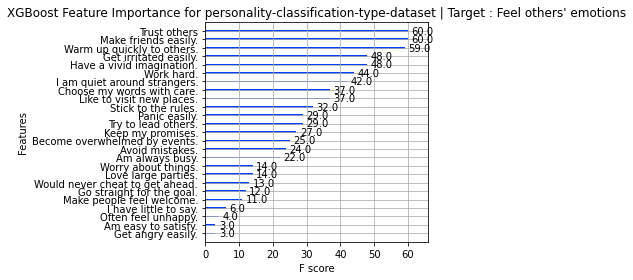

Target Variable: Keep my promises.
CATS=====================
['Make friends easily.', 'Have a vivid imagination.', 'Trust others', 'Get angry easily.', 'Love large parties.', 'Would never cheat to get ahead.', 'Like order.', 'Often feel unhappy.', 'Take charge.', 'Make people feel welcome.', 'Try to follow the rules.', 'Am easy to satisfy.', 'Go straight for the goal.', 'Often overindulge.', 'Avoid mistakes.', 'Warm up quickly to others.', 'Get irritated easily.', 'Stick to the rules.', 'Try to lead others.', 'Keep my promises.', "Feel others' emotions", 'Like to visit new places.', 'Work hard.', 'Choose my words with care.', 'I have little to say.']
CONTS=====================
['Worry about things.', 'Am always busy.', 'Panic easily.', 'Become overwhelmed by events.', 'I am quiet around strangers.']
30
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['Worry about things.', 'Am always busy.', 'Panic easily.', 'Become overwhelmed by events

  5%|▍         | 2/42 [00:00<00:02, 18.82it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.3001712067952028, 'Adjusted R-Squared': 1.5686108944788977, 'RMSE': 0.60052149154257, 'Time taken': 0.07907319068908691}
{'Model': 'BaggingRegressor', 'R-Squared': 0.32079207920792097, 'Adjusted R-Squared': 1.5518564356435642, 'RMSE': 0.5916079783099616, 'Time taken': 0.027005672454833984}
{'Model': 'BayesianRidge', 'R-Squared': 0.12818966969912626, 'Adjusted R-Squared': 1.70834589336946, 'RMSE': 0.670260546965363, 'Time taken': 0.012951850891113281}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.3069306930693071, 'Adjusted R-Squared': 1.5631188118811878, 'RMSE': 0.5976143046671968, 'Time taken': 0.012451887130737305}
{'Model': 'DummyRegressor', 'R-Squared': -0.015470297029702484, 'Adjusted R-Squared': 1.8250696163366333, 'RMSE': 0.7233796107331818, 'Time taken': 0.010772705078125}
{'Model': 'ElasticNet', 'R-Squared': -0.015470297029702484, 'Adjusted R-Squared': 1.8250696163366333, 'RMSE': 0.7233796107331818, 'Time taken': 0.010370492935

 21%|██▏       | 9/42 [00:00<00:01, 18.62it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.20111389314071604, 'Adjusted R-Squared': 1.649094961823168, 'RMSE': 0.6416158523634051, 'Time taken': 0.20377087593078613}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.16831683168316858, 'Adjusted R-Squared': 1.6757425742574257, 'RMSE': 0.6546536707079771, 'Time taken': 0.013063669204711914}
{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.4442138613861386, 'Adjusted R-Squared': 1.4515762376237624, 'RMSE': 0.5351635264103861, 'Time taken': 0.10553646087646484}
{'Model': 'GammaRegressor', 'R-Squared': 0.17947557951757032, 'Adjusted R-Squared': 1.6666760916419743, 'RMSE': 0.6502470741906472, 'Time taken': 0.01415562629699707}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -9.684046144041297, 'Adjusted R-Squared': 9.680787492033554, 'RMSE': 2.346391781129463, 'Time taken': 0.012585878372192383}


 36%|███▌      | 15/42 [00:00<00:01, 22.20it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.41299949436892425, 'Adjusted R-Squared': 1.476937910825249, 'RMSE': 0.5499863220411396, 'Time taken': 0.08805990219116211}
{'Model': 'HistGradientBoostingRegressor', 'R-Squared': -0.10934468101171069, 'Adjusted R-Squared': 1.901342553322015, 'RMSE': 0.7560767858038924, 'Time taken': 0.0722951889038086}
{'Model': 'HuberRegressor', 'R-Squared': -0.5604832523211882, 'Adjusted R-Squared': 2.267892642510965, 'RMSE': 0.8967310488101794, 'Time taken': 0.03636026382446289}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.4122772277227724, 'Adjusted R-Squared': 1.4775247524752473, 'RMSE': 0.550324579550235, 'Time taken': 0.010760307312011719}
{'Model': 'KernelRidge', 'R-Squared': -10.997376895650923, 'Adjusted R-Squared': 10.747868727716375, 'RMSE': 2.4864275110400573, 'Time taken': 0.01134800910949707}
{'Model': 'Lars', 'R-Squared': -0.008685512661875672, 'Adjusted R-Squared': 1.819556979037774, 'RMSE': 0.7209589588182204, 'Time taken': 0.01

 48%|████▊     | 20/42 [00:00<00:01, 20.56it/s]

{'Model': 'LassoCV', 'R-Squared': 0.20155926751767594, 'Adjusted R-Squared': 1.6487330951418881, 'RMSE': 0.6414369788691556, 'Time taken': 0.1831357479095459}
{'Model': 'LassoLars', 'R-Squared': -0.015470297029702484, 'Adjusted R-Squared': 1.8250696163366333, 'RMSE': 0.7233796107331818, 'Time taken': 0.012693643569946289}
{'Model': 'LassoLarsCV', 'R-Squared': 0.1991693685615007, 'Adjusted R-Squared': 1.6506748880437807, 'RMSE': 0.6423962386447644, 'Time taken': 0.04019021987915039}
{'Model': 'LassoLarsIC', 'R-Squared': 0.20148341831163397, 'Adjusted R-Squared': 1.6487947226217974, 'RMSE': 0.641467445332221, 'Time taken': 0.017276287078857422}
{'Model': 'LinearRegression', 'R-Squared': -0.203742793142891, 'Adjusted R-Squared': 1.978041019428599, 'RMSE': 0.7875887449426683, 'Time taken': 0.010545730590820312}
{'Model': 'LinearSVR', 'R-Squared': -0.1291680670102484, 'Adjusted R-Squared': 1.917449054445827, 'RMSE': 0.7628022143414771, 'Time taken': 0.01421499252319336}


 76%|███████▌  | 32/42 [00:01<00:00, 27.60it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.19793582822678701, 'Adjusted R-Squared': 1.6516771395657357, 'RMSE': 0.6428907981233725, 'Time taken': 0.12762689590454102}
{'Model': 'NuSVR', 'R-Squared': 0.3596598341292929, 'Adjusted R-Squared': 1.5202763847699496, 'RMSE': 0.5744312038209367, 'Time taken': 0.011921882629394531}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.1716907736661627, 'Adjusted R-Squared': 1.6730012463962427, 'RMSE': 0.6533244336551358, 'Time taken': 0.010776042938232422}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.1716907736661627, 'Adjusted R-Squared': 1.6730012463962427, 'RMSE': 0.6533244336551358, 'Time taken': 0.016207218170166016}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -0.273045980853889, 'Adjusted R-Squared': 2.0343498594437848, 'RMSE': 0.8099434474659793, 'Time taken': 0.010711193084716797}
{'Model': 'PoissonRegressor', 'R-Squared': 0.11082213737966329, 'Adjusted R-Squared': 1.7224570133790236, 'RMSE': 0.6769038310974147, 'Time 

 83%|████████▎ | 35/42 [00:01<00:00, 21.20it/s]

{'Model': 'RANSACRegressor', 'R-Squared': -1.540509380122114, 'Adjusted R-Squared': 3.0641638713492174, 'RMSE': 1.144176576283568, 'Time taken': 0.10386538505554199}
{'Model': 'RandomForestRegressor', 'R-Squared': 0.42489108910891105, 'Adjusted R-Squared': 1.4672759900990098, 'RMSE': 0.544386942217705, 'Time taken': 0.1431727409362793}
{'Model': 'Ridge', 'R-Squared': -0.17694826286374865, 'Adjusted R-Squared': 1.9562704635767958, 'RMSE': 0.7787738090481606, 'Time taken': 0.011001348495483398}
{'Model': 'RidgeCV', 'R-Squared': 0.0246009307129178, 'Adjusted R-Squared': 1.7925117437957543, 'RMSE': 0.708963406837525, 'Time taken': 0.013075590133666992}
{'Model': 'SGDRegressor', 'R-Squared': -0.06820011630119382, 'Adjusted R-Squared': 1.8679125944947201, 'RMSE': 0.7419232170047769, 'Time taken': 0.011292695999145508}
{'Model': 'SVR', 'R-Squared': 0.3618304052582242, 'Adjusted R-Squared': 1.518512795727693, 'RMSE': 0.573456798138466, 'Time taken': 0.011056900024414062}
{'Model': 'Transformed

100%|██████████| 42/42 [00:02<00:00, 20.22it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.34207075248637164, 'Adjusted R-Squared': 1.5345675136048231, 'RMSE': 0.5822671, 'Time taken': 0.376079797744751}
{'Model': 'LGBMRegressor', 'R-Squared': -0.10934468101171069, 'Adjusted R-Squared': 1.901342553322015, 'RMSE': 0.7560767858038924, 'Time taken': 0.023831844329833984}
Project: personality-classification-type-dataset
personality-classification-type-dataset
Target: Keep my promises.
Keep my promises.
Target Standard Deviation: 0.6941354187706004
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
KernelRidge                                 10.75     -11.00  2.49        0.01
GaussianProcessRegressor                     9.68      -9.68  2.35        0.01
RANSACRegressor                              3.06      -1.54  1.14        0.10
HuberRegressor                               2.27      -0.56  0.90        0.04
PassiveAggressiveRegressor

Better model found at epoch 0 with _rmse value: 2.482905387878418.
No improvement since epoch 0: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       2       2.29
1       3       2.74
2       1       3.03
3       2       1.97
4       1       1.03
XGBoost RMSE:  0.5822671


<Figure size 432x288 with 0 Axes>

<Figure size 720x720 with 0 Axes>

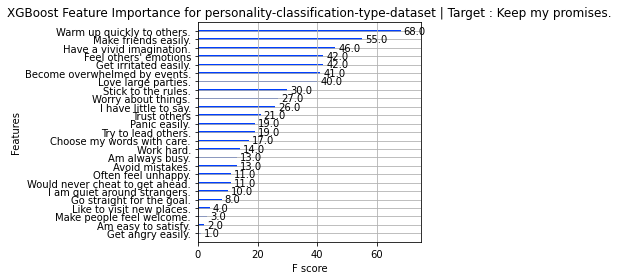

Target Variable: Try to lead others.
CATS=====================
['Make friends easily.', 'Have a vivid imagination.', 'Trust others', 'Get angry easily.', 'Love large parties.', 'Would never cheat to get ahead.', 'Like order.', 'Often feel unhappy.', 'Take charge.', 'Make people feel welcome.', 'Try to follow the rules.', 'Am easy to satisfy.', 'Go straight for the goal.', 'Often overindulge.', 'Avoid mistakes.', 'Warm up quickly to others.', 'Get irritated easily.', 'Stick to the rules.', 'Try to lead others.', 'Keep my promises.', "Feel others' emotions", 'Like to visit new places.', 'Work hard.', 'Choose my words with care.', 'I have little to say.']
CONTS=====================
['Worry about things.', 'Am always busy.', 'Panic easily.', 'Become overwhelmed by events.', 'I am quiet around strangers.']
30
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['Worry about things.', 'Am always busy.', 'Panic easily.', 'Become overwhelmed by even

  5%|▍         | 2/42 [00:00<00:02, 19.00it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.0018250478953171223, 'Adjusted R-Squared': 1.8110171485850548, 'RMSE': 0.4099513001157634, 'Time taken': 0.0770111083984375}
{'Model': 'BaggingRegressor', 'R-Squared': -0.03090909090909144, 'Adjusted R-Squared': 1.8376136363636368, 'RMSE': 0.41661904489764817, 'Time taken': 0.028046369552612305}
{'Model': 'BayesianRidge', 'R-Squared': 0.11688940242171686, 'Adjusted R-Squared': 1.717527360532355, 'RMSE': 0.38559951811143656, 'Time taken': 0.013639688491821289}
{'Model': 'DecisionTreeRegressor', 'R-Squared': -0.6969696969696975, 'Adjusted R-Squared': 2.378787878787879, 'RMSE': 0.5345224838248488, 'Time taken': 0.012115240097045898}
{'Model': 'DummyRegressor', 'R-Squared': -0.09280303030303072, 'Adjusted R-Squared': 1.8879024621212124, 'RMSE': 0.4289432910522969, 'Time taken': 0.009951353073120117}
{'Model': 'ElasticNet', 'R-Squared': -0.09280303030303072, 'Adjusted R-Squared': 1.8879024621212124, 'RMSE': 0.4289432910522969, 'Time taken': 0.01

 21%|██▏       | 9/42 [00:00<00:02, 13.36it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.24185555364019096, 'Adjusted R-Squared': 1.615992362667345, 'RMSE': 0.35727688006638186, 'Time taken': 0.4013087749481201}
{'Model': 'ExtraTreeRegressor', 'R-Squared': -0.27272727272727315, 'Adjusted R-Squared': 2.034090909090909, 'RMSE': 0.4629100498862757, 'Time taken': 0.011629343032836914}
{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.20242424242424206, 'Adjusted R-Squared': 1.6480303030303034, 'RMSE': 0.3664501525251617, 'Time taken': 0.10582518577575684}
{'Model': 'GammaRegressor', 'R-Squared': 0.1172459904905595, 'Adjusted R-Squared': 1.7172376327264205, 'RMSE': 0.38552166032620144, 'Time taken': 0.013379812240600586}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -17.629459502584734, 'Adjusted R-Squared': 16.136435845850094, 'RMSE': 1.7710428203049047, 'Time taken': 0.015411138534545898}


 33%|███▎      | 14/42 [00:00<00:01, 16.79it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': -0.28133587645335667, 'Adjusted R-Squared': 2.0410853996183524, 'RMSE': 0.464472950833439, 'Time taken': 0.08232259750366211}
{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.10758955941794779, 'Adjusted R-Squared': 1.7250834829729174, 'RMSE': 0.38762453258438617, 'Time taken': 0.07788705825805664}
{'Model': 'HuberRegressor', 'R-Squared': -1.7127335498016514, 'Adjusted R-Squared': 3.204096009213842, 'RMSE': 0.6758222774753068, 'Time taken': 0.03669452667236328}
{'Model': 'KNeighborsRegressor', 'R-Squared': -0.018181818181818743, 'Adjusted R-Squared': 1.8272727272727276, 'RMSE': 0.41403933560541256, 'Time taken': 0.012026309967041016}
{'Model': 'KernelRidge', 'R-Squared': -18.480533983564115, 'Adjusted R-Squared': 16.827933861645842, 'RMSE': 1.8110455057130246, 'Time taken': 0.010353326797485352}
{'Model': 'Lars', 'R-Squared': -0.5079883987676204, 'Adjusted R-Squared': 2.2252405739986916, 'RMSE': 0.5038809441871724, 'Time take

 62%|██████▏   | 26/42 [00:01<00:00, 20.76it/s]

{'Model': 'LassoCV', 'R-Squared': 0.24383065285260153, 'Adjusted R-Squared': 1.6143875945572612, 'RMSE': 0.35681119211094453, 'Time taken': 0.27942728996276855}
{'Model': 'LassoLars', 'R-Squared': -0.09280303030303072, 'Adjusted R-Squared': 1.8879024621212124, 'RMSE': 0.4289432910522969, 'Time taken': 0.012404680252075195}
{'Model': 'LassoLarsCV', 'R-Squared': 0.26803090767346804, 'Adjusted R-Squared': 1.5947248875153073, 'RMSE': 0.3510551154964157, 'Time taken': 0.03780651092529297}
{'Model': 'LassoLarsIC', 'R-Squared': 0.09850308205945157, 'Adjusted R-Squared': 1.7324662458266955, 'RMSE': 0.38959292132575135, 'Time taken': 0.01679253578186035}
{'Model': 'LinearRegression', 'R-Squared': -1.2057909617657563, 'Adjusted R-Squared': 2.792205156434677, 'RMSE': 0.609412152926105, 'Time taken': 0.01123046875}
{'Model': 'LinearSVR', 'R-Squared': -1.3406439772092207, 'Adjusted R-Squared': 2.9017732314824918, 'RMSE': 0.6277643001723976, 'Time taken': 0.014280557632446289}
{'Model': 'MLPRegresso

 76%|███████▌  | 32/42 [00:01<00:00, 25.92it/s]

{'Model': 'NuSVR', 'R-Squared': -0.019096902709796693, 'Adjusted R-Squared': 1.8280162334517098, 'RMSE': 0.4142253514486672, 'Time taken': 0.013318061828613281}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.3099935325370323, 'Adjusted R-Squared': 1.5606302548136612, 'RMSE': 0.3408438913892053, 'Time taken': 0.010667085647583008}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.023123351666892944, 'Adjusted R-Squared': 1.7937122767706495, 'RMSE': 0.40555410189799385, 'Time taken': 0.0150604248046875}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -2.39906059849802, 'Adjusted R-Squared': 3.7617367362796412, 'RMSE': 0.756499051587798, 'Time taken': 0.009986162185668945}
{'Model': 'PoissonRegressor', 'R-Squared': 0.07856380622743664, 'Adjusted R-Squared': 1.7486669074402077, 'RMSE': 0.3938778583759817, 'Time taken': 0.01173543930053711}
{'Model': 'QuantileRegressor', 'R-Squared': -0.27272727283795417, 'Adjusted R-Squared': 2.0340909091808377, 'RMSE': 0.4629100499064039

 83%|████████▎ | 35/42 [00:01<00:00, 19.43it/s]

{'Model': 'RANSACRegressor', 'R-Squared': -3.6666666666666687, 'Adjusted R-Squared': 4.791666666666668, 'RMSE': 0.8864052604279183, 'Time taken': 0.14374971389770508}
{'Model': 'RandomForestRegressor', 'R-Squared': 0.31111515151515123, 'Adjusted R-Squared': 1.5597189393939397, 'RMSE': 0.340566754522097, 'Time taken': 0.1385021209716797}
{'Model': 'Ridge', 'R-Squared': -0.6057284350822287, 'Adjusted R-Squared': 2.304654353504311, 'RMSE': 0.5199540715476191, 'Time taken': 0.010781049728393555}
{'Model': 'RidgeCV', 'R-Squared': -0.1488446983081526, 'Adjusted R-Squared': 1.933436317375374, 'RMSE': 0.4398044268749708, 'Time taken': 0.010698795318603516}
{'Model': 'SGDRegressor', 'R-Squared': -0.23415149909684763, 'Adjusted R-Squared': 2.002748093016189, 'RMSE': 0.4558407766133354, 'Time taken': 0.010239601135253906}
{'Model': 'SVR', 'R-Squared': -0.02365720631036128, 'Adjusted R-Squared': 1.8317214801271686, 'RMSE': 0.4151511146573429, 'Time taken': 0.010038375854492188}
{'Model': 'Transfor

100%|██████████| 42/42 [00:02<00:00, 17.88it/s]

{'Model': 'XGBRegressor', 'R-Squared': -0.5179113209237451, 'Adjusted R-Squared': 2.233302948250543, 'RMSE': 0.505536, 'Time taken': 0.36498355865478516}
{'Model': 'LGBMRegressor', 'R-Squared': 0.10758955941794779, 'Adjusted R-Squared': 1.7250834829729174, 'RMSE': 0.38762453258438617, 'Time taken': 0.027470827102661133}
Project: personality-classification-type-dataset
personality-classification-type-dataset
Target: Try to lead others.
Try to lead others.
Target Standard Deviation: 0.47346691369867333
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
KernelRidge                                 16.83     -18.48  1.81        0.01
GaussianProcessRegressor                    16.14     -17.63  1.77        0.02
RANSACRegressor                              4.79      -3.67  0.89        0.14
MLPRegressor                                 3.85      -2.50  0.77        0.10
PassiveAggressiveReg

Better model found at epoch 0 with _rmse value: 1.8762967586517334.
No improvement since epoch 0: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       1       1.30
1       2       1.91
2       1       0.99
3       2       2.14
4       2       1.09
XGBoost RMSE:  0.5052613


<Figure size 432x288 with 0 Axes>

<Figure size 720x720 with 0 Axes>

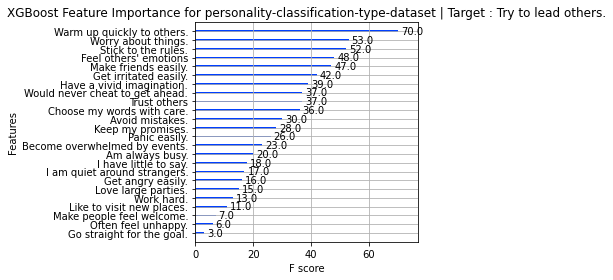

Target Variable: Stick to the rules.
CATS=====================
['Make friends easily.', 'Have a vivid imagination.', 'Trust others', 'Get angry easily.', 'Love large parties.', 'Would never cheat to get ahead.', 'Like order.', 'Often feel unhappy.', 'Take charge.', 'Make people feel welcome.', 'Try to follow the rules.', 'Am easy to satisfy.', 'Go straight for the goal.', 'Often overindulge.', 'Avoid mistakes.', 'Warm up quickly to others.', 'Get irritated easily.', 'Stick to the rules.', 'Try to lead others.', 'Keep my promises.', "Feel others' emotions", 'Like to visit new places.', 'Work hard.', 'Choose my words with care.', 'I have little to say.']
CONTS=====================
['Worry about things.', 'Am always busy.', 'Panic easily.', 'Become overwhelmed by events.', 'I am quiet around strangers.']
30
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['Worry about things.', 'Am always busy.', 'Panic easily.', 'Become overwhelmed by even

  5%|▍         | 2/42 [00:00<00:02, 18.34it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.29550913395848155, 'Adjusted R-Squared': 1.5723988286587338, 'RMSE': 0.6143336398844447, 'Time taken': 0.08057165145874023}
{'Model': 'BaggingRegressor', 'R-Squared': 0.3506666666666667, 'Adjusted R-Squared': 1.5275833333333333, 'RMSE': 0.5897941529526576, 'Time taken': 0.02832174301147461}
{'Model': 'BayesianRidge', 'R-Squared': -0.06177115255358845, 'Adjusted R-Squared': 1.8626890614497906, 'RMSE': 0.7541922663235678, 'Time taken': 0.01419973373413086}
{'Model': 'DecisionTreeRegressor', 'R-Squared': -0.06666666666666665, 'Adjusted R-Squared': 1.8666666666666667, 'RMSE': 0.7559289460184544, 'Time taken': 0.012794733047485352}
{'Model': 'DummyRegressor', 'R-Squared': -0.26249999999999996, 'Adjusted R-Squared': 2.0257812499999996, 'RMSE': 0.8223984956906754, 'Time taken': 0.011620044708251953}
{'Model': 'ElasticNet', 'R-Squared': -0.26249999999999996, 'Adjusted R-Squared': 2.0257812499999996, 'RMSE': 0.8223984956906754, 'Time taken': 0.01066

 21%|██▏       | 9/42 [00:00<00:02, 16.33it/s]

{'Model': 'ElasticNetCV', 'R-Squared': -0.03329158396191456, 'Adjusted R-Squared': 1.8395494119690556, 'RMSE': 0.7440087787363399, 'Time taken': 0.2613847255706787}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.06666666666666665, 'Adjusted R-Squared': 1.7583333333333333, 'RMSE': 0.7071067811865476, 'Time taken': 0.013274669647216797}
{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.3712, 'Adjusted R-Squared': 1.5109, 'RMSE': 0.580393954876464, 'Time taken': 0.11041450500488281}
{'Model': 'GammaRegressor', 'R-Squared': -0.12496140862334904, 'Adjusted R-Squared': 1.914031144506471, 'RMSE': 0.7763104388559993, 'Time taken': 0.01352834701538086}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -11.268453865946903, 'Adjusted R-Squared': 10.968118766081858, 'RMSE': 2.563666514899005, 'Time taken': 0.016716718673706055}


 36%|███▌      | 15/42 [00:00<00:01, 20.89it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.3549012940102886, 'Adjusted R-Squared': 1.5241426986166404, 'RMSE': 0.5878678359074327, 'Time taken': 0.10229659080505371}
{'Model': 'HistGradientBoostingRegressor', 'R-Squared': -0.03424522505246008, 'Adjusted R-Squared': 1.8403242453551238, 'RMSE': 0.7443520282718314, 'Time taken': 0.058371543884277344}
{'Model': 'HuberRegressor', 'R-Squared': -0.7499013829728987, 'Adjusted R-Squared': 2.42179487366548, 'RMSE': 0.9682185545886668, 'Time taken': 0.03649544715881348}
{'Model': 'KNeighborsRegressor', 'R-Squared': -0.5306666666666671, 'Adjusted R-Squared': 2.243666666666667, 'RMSE': 0.9055385138137417, 'Time taken': 0.010328054428100586}
{'Model': 'KernelRidge', 'R-Squared': -11.530606377346219, 'Adjusted R-Squared': 11.181117681593802, 'RMSE': 2.590911971682346, 'Time taken': 0.012203693389892578}
{'Model': 'Lars', 'R-Squared': -7.0832034811162785, 'Adjusted R-Squared': 7.567602828406976, 'RMSE': 2.080934304385757, 'Time taken': 0.01

 60%|█████▉    | 25/42 [00:01<00:00, 24.53it/s]

{'Model': 'LassoCV', 'R-Squared': -0.02688147915851502, 'Adjusted R-Squared': 1.8343412018162935, 'RMSE': 0.7416974303047255, 'Time taken': 0.225250244140625}
{'Model': 'LassoLars', 'R-Squared': -0.26249999999999996, 'Adjusted R-Squared': 2.0257812499999996, 'RMSE': 0.8223984956906754, 'Time taken': 0.012081623077392578}
{'Model': 'LassoLarsCV', 'R-Squared': -0.018210444015223537, 'Adjusted R-Squared': 1.8272959857623692, 'RMSE': 0.7385593278284699, 'Time taken': 0.04789090156555176}
{'Model': 'LassoLarsIC', 'R-Squared': 0.05047695212825931, 'Adjusted R-Squared': 1.7714874763957893, 'RMSE': 0.7132131948862563, 'Time taken': 0.018962860107421875}
{'Model': 'LinearRegression', 'R-Squared': -0.7434177229121439, 'Adjusted R-Squared': 2.416526899866117, 'RMSE': 0.9664231889454565, 'Time taken': 0.011000394821166992}
{'Model': 'LinearSVR', 'R-Squared': -0.2326619190558905, 'Adjusted R-Squared': 2.001537809232911, 'RMSE': 0.8126220520600134, 'Time taken': 0.014637470245361328}


 76%|███████▌  | 32/42 [00:01<00:00, 25.75it/s]

{'Model': 'MLPRegressor', 'R-Squared': -0.9528832913571141, 'Adjusted R-Squared': 2.586717674227655, 'RMSE': 1.0228330643427304, 'Time taken': 0.12711524963378906}
{'Model': 'NuSVR', 'R-Squared': -0.16759587742488913, 'Adjusted R-Squared': 1.9486716504077224, 'RMSE': 0.790884183352796, 'Time taken': 0.011092662811279297}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': -0.03791322314049528, 'Adjusted R-Squared': 1.8433044938016523, 'RMSE': 0.7456707993264337, 'Time taken': 0.010230302810668945}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': -0.015335790041589803, 'Adjusted R-Squared': 1.8249603294087917, 'RMSE': 0.7375160252647261, 'Time taken': 0.01763439178466797}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -0.7926841813074397, 'Adjusted R-Squared': 2.4565558973122945, 'RMSE': 0.9799829211269011, 'Time taken': 0.010317802429199219}
{'Model': 'PoissonRegressor', 'R-Squared': -0.03472758520539854, 'Adjusted R-Squared': 1.8407161629793864, 'RMSE': 0.7445255866773001, 

 83%|████████▎ | 35/42 [00:01<00:00, 18.72it/s]

{'Model': 'RANSACRegressor', 'R-Squared': -0.8367842378928727, 'Adjusted R-Squared': 2.492387193287959, 'RMSE': 0.9919634852221321, 'Time taken': 0.13269877433776855}
{'Model': 'RandomForestRegressor', 'R-Squared': 0.2582133333333334, 'Adjusted R-Squared': 1.6027016666666665, 'RMSE': 0.6303853696634419, 'Time taken': 0.13842415809631348}
{'Model': 'Ridge', 'R-Squared': -0.4077150890059358, 'Adjusted R-Squared': 2.143768509817323, 'RMSE': 0.8684083621177522, 'Time taken': 0.010367155075073242}
{'Model': 'RidgeCV', 'R-Squared': -0.07233101169067302, 'Adjusted R-Squared': 1.8712689469986719, 'RMSE': 0.7579334020724685, 'Time taken': 0.013045072555541992}
{'Model': 'SGDRegressor', 'R-Squared': -0.11245766245235234, 'Adjusted R-Squared': 1.9038718507425363, 'RMSE': 0.7719841073675324, 'Time taken': 0.01078486442565918}
{'Model': 'SVR', 'R-Squared': -0.15565055413916018, 'Adjusted R-Squared': 1.9389660752380675, 'RMSE': 0.7868281331688507, 'Time taken': 0.010071277618408203}
{'Model': 'Trans

100%|██████████| 42/42 [00:02<00:00, 19.05it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.2293169981968366, 'Adjusted R-Squared': 1.6261799389650702, 'RMSE': 0.6425464, 'Time taken': 0.3638896942138672}
{'Model': 'LGBMRegressor', 'R-Squared': -0.03424522505246008, 'Adjusted R-Squared': 1.8403242453551238, 'RMSE': 0.7443520282718314, 'Time taken': 0.027128219604492188}
Project: personality-classification-type-dataset
personality-classification-type-dataset
Target: Stick to the rules.
Stick to the rules.
Target Standard Deviation: 0.7574039307303034
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
KernelRidge                                 11.18     -11.53  2.59        0.01
GaussianProcessRegressor                    10.97     -11.27  2.56        0.02
Lars                                         7.57      -7.08  2.08        0.01
MLPRegressor                                 2.59      -0.95  1.02        0.13
RANSACRegressor      

Better model found at epoch 0 with _rmse value: 2.656907558441162.
No improvement since epoch 0: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       3       2.94
1       2       2.00
2       3       1.92
3       1       1.00
4       1       2.20
XGBoost RMSE:  0.6513269


<Figure size 432x288 with 0 Axes>

<Figure size 720x720 with 0 Axes>

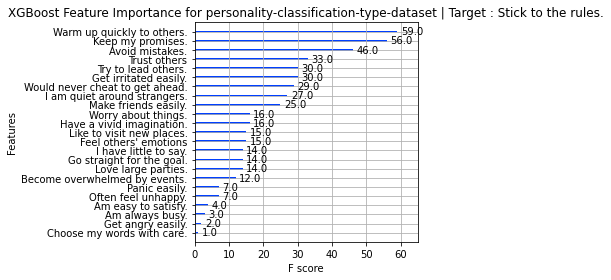

Target Variable: Get irritated easily.
CATS=====================
['Make friends easily.', 'Have a vivid imagination.', 'Trust others', 'Get angry easily.', 'Love large parties.', 'Would never cheat to get ahead.', 'Like order.', 'Often feel unhappy.', 'Take charge.', 'Make people feel welcome.', 'Try to follow the rules.', 'Am easy to satisfy.', 'Go straight for the goal.', 'Often overindulge.', 'Avoid mistakes.', 'Warm up quickly to others.', 'Get irritated easily.', 'Stick to the rules.', 'Try to lead others.', 'Keep my promises.', "Feel others' emotions", 'Like to visit new places.', 'Work hard.', 'Choose my words with care.', 'I have little to say.']
CONTS=====================
['Worry about things.', 'Am always busy.', 'Panic easily.', 'Become overwhelmed by events.', 'I am quiet around strangers.']
30
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['Worry about things.', 'Am always busy.', 'Panic easily.', 'Become overwhelmed by ev

  5%|▍         | 2/42 [00:00<00:02, 19.41it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.5789632101883223, 'Adjusted R-Squared': 1.3420923917219882, 'RMSE': 0.5483981802953019, 'Time taken': 0.07661724090576172}
{'Model': 'BaggingRegressor', 'R-Squared': 0.512, 'Adjusted R-Squared': 1.3965, 'RMSE': 0.5903993805649093, 'Time taken': 0.026265382766723633}
{'Model': 'BayesianRidge', 'R-Squared': 0.3282523595554345, 'Adjusted R-Squared': 1.5457949578612094, 'RMSE': 0.6926902216537272, 'Time taken': 0.011997461318969727}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.5, 'Adjusted R-Squared': 1.40625, 'RMSE': 0.5976143046671968, 'Time taken': 0.011844158172607422}
{'Model': 'DummyRegressor', 'R-Squared': -0.0642857142857145, 'Adjusted R-Squared': 1.864732142857143, 'RMSE': 0.8718968296952646, 'Time taken': 0.009653091430664062}
{'Model': 'ElasticNet', 'R-Squared': -0.0642857142857145, 'Adjusted R-Squared': 1.864732142857143, 'RMSE': 0.8718968296952646, 'Time taken': 0.01014566421508789}


 21%|██▏       | 9/42 [00:00<00:01, 17.25it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.3320859183109742, 'Adjusted R-Squared': 1.5426801913723334, 'RMSE': 0.6907108562348885, 'Time taken': 0.24848437309265137}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.4, 'Adjusted R-Squared': 1.4875, 'RMSE': 0.6546536707079771, 'Time taken': 0.011279821395874023}
{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.68858, 'Adjusted R-Squared': 1.25302875, 'RMSE': 0.4716384814058933, 'Time taken': 0.1073763370513916}
{'Model': 'GammaRegressor', 'R-Squared': 0.34045082257149273, 'Adjusted R-Squared': 1.535883706660662, 'RMSE': 0.686372023982677, 'Time taken': 0.013447046279907227}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -5.084350663763286, 'Adjusted R-Squared': 5.94353491430767, 'RMSE': 2.0846977622261984, 'Time taken': 0.014201879501342773}


 36%|███▌      | 15/42 [00:00<00:01, 21.42it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.6635683031066317, 'Adjusted R-Squared': 1.2733507537258617, 'RMSE': 0.49021256096089016, 'Time taken': 0.08896470069885254}
{'Model': 'HistGradientBoostingRegressor', 'R-Squared': -0.1862873339995026, 'Adjusted R-Squared': 1.9638584588745958, 'RMSE': 0.9205151251956322, 'Time taken': 0.06966757774353027}
{'Model': 'HuberRegressor', 'R-Squared': -0.6578003644232286, 'Adjusted R-Squared': 2.346962796093873, 'RMSE': 1.0881834024856119, 'Time taken': 0.03719305992126465}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.4279999999999998, 'Adjusted R-Squared': 1.4647500000000002, 'RMSE': 0.6391959234627742, 'Time taken': 0.010389566421508789}
{'Model': 'KernelRidge', 'R-Squared': -6.306533547676875, 'Adjusted R-Squared': 6.936558507487462, 'RMSE': 2.2845026885637303, 'Time taken': 0.011372566223144531}
{'Model': 'Lars', 'R-Squared': -1732.838260988415, 'Adjusted R-Squared': 1409.7435870530871, 'RMSE': 35.19170215698597, 'Time taken': 0.015

 48%|████▊     | 20/42 [00:01<00:01, 17.15it/s]

{'Model': 'LassoCV', 'R-Squared': 0.3546148530445036, 'Adjusted R-Squared': 1.524375431901341, 'RMSE': 0.6789619950207062, 'Time taken': 0.27470850944519043}
{'Model': 'LassoLars', 'R-Squared': -0.0642857142857145, 'Adjusted R-Squared': 1.864732142857143, 'RMSE': 0.8718968296952646, 'Time taken': 0.013013362884521484}
{'Model': 'LassoLarsCV', 'R-Squared': 0.32096890099200004, 'Adjusted R-Squared': 1.551712767944, 'RMSE': 0.6964353620955378, 'Time taken': 0.0438227653503418}
{'Model': 'LassoLarsIC', 'R-Squared': 0.3908538388362929, 'Adjusted R-Squared': 1.4949312559455121, 'RMSE': 0.6596244392313094, 'Time taken': 0.015905380249023438}
{'Model': 'LinearRegression', 'R-Squared': -0.24560190748598854, 'Adjusted R-Squared': 2.012051549832366, 'RMSE': 0.943247395015898, 'Time taken': 0.010123968124389648}
{'Model': 'LinearSVR', 'R-Squared': 0.20529280811763884, 'Adjusted R-Squared': 1.6456995934044185, 'RMSE': 0.7534241794644545, 'Time taken': 0.013403892517089844}


 76%|███████▌  | 32/42 [00:01<00:00, 25.01it/s]

{'Model': 'MLPRegressor', 'R-Squared': -0.1527282550652329, 'Adjusted R-Squared': 1.9365917072405017, 'RMSE': 0.9074014134034589, 'Time taken': 0.13609075546264648}
{'Model': 'NuSVR', 'R-Squared': 0.47261158547496485, 'Adjusted R-Squared': 1.428503086801591, 'RMSE': 0.6137638066675365, 'Time taken': 0.012809991836547852}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.41216232606881564, 'Adjusted R-Squared': 1.4776181100690873, 'RMSE': 0.6479846084653468, 'Time taken': 0.010541677474975586}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.41216232606881564, 'Adjusted R-Squared': 1.4776181100690873, 'RMSE': 0.6479846084653468, 'Time taken': 0.015771150588989258}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.058165887196903854, 'Adjusted R-Squared': 1.7652402166525156, 'RMSE': 0.8202064691297012, 'Time taken': 0.010307550430297852}
{'Model': 'PoissonRegressor', 'R-Squared': 0.34685584052343477, 'Adjusted R-Squared': 1.5306796295747094, 'RMSE': 0.6830311431283795, 'T

 83%|████████▎ | 35/42 [00:01<00:00, 18.71it/s]

{'Model': 'RANSACRegressor', 'R-Squared': -1.829512200910738, 'Adjusted R-Squared': 3.298978663239975, 'RMSE': 1.4216469827308291, 'Time taken': 0.1554546356201172}
{'Model': 'RandomForestRegressor', 'R-Squared': 0.5708099999999999, 'Adjusted R-Squared': 1.348716875, 'RMSE': 0.5536824773408364, 'Time taken': 0.13797879219055176}
{'Model': 'Ridge', 'R-Squared': 0.12337644203302955, 'Adjusted R-Squared': 1.7122566408481634, 'RMSE': 0.7913025238567875, 'Time taken': 0.010829448699951172}
{'Model': 'RidgeCV', 'R-Squared': 0.3144646212597887, 'Adjusted R-Squared': 1.5569974952264216, 'RMSE': 0.6997629081850363, 'Time taken': 0.011247873306274414}
{'Model': 'SGDRegressor', 'R-Squared': 0.32735603689265313, 'Adjusted R-Squared': 1.5465232200247194, 'RMSE': 0.6931522009256732, 'Time taken': 0.01073455810546875}
{'Model': 'SVR', 'R-Squared': 0.46649651132083947, 'Adjusted R-Squared': 1.433471584551818, 'RMSE': 0.6173118502710884, 'Time taken': 0.011090993881225586}
{'Model': 'TransformedTargetR

100%|██████████| 42/42 [00:02<00:00, 18.51it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.6358809801412917, 'Adjusted R-Squared': 1.2958467036352004, 'RMSE': 0.5099853, 'Time taken': 0.3645138740539551}
{'Model': 'LGBMRegressor', 'R-Squared': -0.1862873339995026, 'Adjusted R-Squared': 1.9638584588745958, 'RMSE': 0.9205151251956322, 'Time taken': 0.039388179779052734}
Project: personality-classification-type-dataset
personality-classification-type-dataset
Target: Get irritated easily.
Get irritated easily.
Target Standard Deviation: 0.7953949089757174
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
Lars                                      1409.74   -1732.84 35.19        0.02
KernelRidge                                  6.94      -6.31  2.28        0.01
GaussianProcessRegressor                     5.94      -5.08  2.08        0.01
RANSACRegressor                              3.30      -1.83  1.42        0.16
HuberRegressor    

Better model found at epoch 0 with _rmse value: 2.243192672729492.
No improvement since epoch 0: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       2       2.95
1       1       2.44
2       3       2.20
3       1       1.04
4       1       1.01
XGBoost RMSE:  0.5099853


<Figure size 432x288 with 0 Axes>

<Figure size 720x720 with 0 Axes>

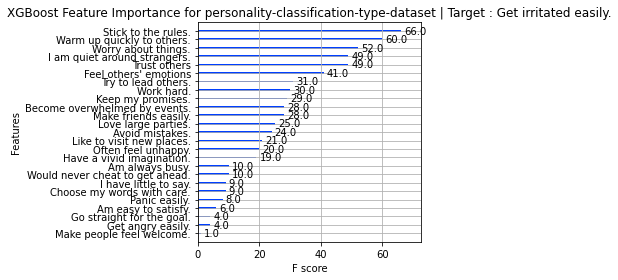

Target Variable: Warm up quickly to others.
CATS=====================
['Make friends easily.', 'Have a vivid imagination.', 'Trust others', 'Get angry easily.', 'Love large parties.', 'Would never cheat to get ahead.', 'Like order.', 'Often feel unhappy.', 'Take charge.', 'Make people feel welcome.', 'Try to follow the rules.', 'Am easy to satisfy.', 'Go straight for the goal.', 'Often overindulge.', 'Avoid mistakes.', 'Warm up quickly to others.', 'Get irritated easily.', 'Stick to the rules.', 'Try to lead others.', 'Keep my promises.', "Feel others' emotions", 'Like to visit new places.', 'Work hard.', 'Choose my words with care.', 'I have little to say.']
CONTS=====================
['Worry about things.', 'Am always busy.', 'Panic easily.', 'Become overwhelmed by events.', 'I am quiet around strangers.']
30
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['Worry about things.', 'Am always busy.', 'Panic easily.', 'Become overwhelmed 

  5%|▍         | 2/42 [00:00<00:02, 18.73it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.8662978235068403, 'Adjusted R-Squared': 1.1086330184006923, 'RMSE': 0.30903325814218, 'Time taken': 0.07932615280151367}
{'Model': 'BaggingRegressor', 'R-Squared': 0.6349999999999999, 'Adjusted R-Squared': 1.2965625, 'RMSE': 0.5106018857331862, 'Time taken': 0.0272676944732666}
{'Model': 'BayesianRidge', 'R-Squared': 0.026303507618647748, 'Adjusted R-Squared': 1.7911284000598489, 'RMSE': 0.8339649240574263, 'Time taken': 0.01378321647644043}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.5, 'Adjusted R-Squared': 1.40625, 'RMSE': 0.5976143046671968, 'Time taken': 0.011467218399047852}
{'Model': 'DummyRegressor', 'R-Squared': -0.0071428571428568954, 'Adjusted R-Squared': 1.8183035714285714, 'RMSE': 0.8481672919312797, 'Time taken': 0.010186195373535156}
{'Model': 'ElasticNet', 'R-Squared': -0.0071428571428568954, 'Adjusted R-Squared': 1.8183035714285714, 'RMSE': 0.8481672919312797, 'Time taken': 0.010527849197387695}


 21%|██▏       | 9/42 [00:00<00:01, 17.96it/s]

{'Model': 'ElasticNetCV', 'R-Squared': -0.0071428571428568954, 'Adjusted R-Squared': 1.8183035714285714, 'RMSE': 0.8481672919312797, 'Time taken': 0.21374797821044922}
{'Model': 'ExtraTreeRegressor', 'R-Squared': -0.30000000000000004, 'Adjusted R-Squared': 2.0562500000000004, 'RMSE': 0.9636241116594315, 'Time taken': 0.011105775833129883}
{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.6791175, 'Adjusted R-Squared': 1.26071703125, 'RMSE': 0.4787502331219126, 'Time taken': 0.1129915714263916}
{'Model': 'GammaRegressor', 'R-Squared': 0.2050078019756839, 'Adjusted R-Squared': 1.6459311608947567, 'RMSE': 0.7535592677536178, 'Time taken': 0.01437997817993164}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -5.462620421662844, 'Adjusted R-Squared': 6.2508790926010604, 'RMSE': 2.1485244806715347, 'Time taken': 0.015820026397705078}


 36%|███▌      | 15/42 [00:00<00:01, 21.55it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.8537551520482403, 'Adjusted R-Squared': 1.1188239389608048, 'RMSE': 0.3232036597562416, 'Time taken': 0.08085227012634277}
{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.552578339397197, 'Adjusted R-Squared': 1.3635300992397774, 'RMSE': 0.5653201751490685, 'Time taken': 0.07987093925476074}
{'Model': 'HuberRegressor', 'R-Squared': -0.17685024568704644, 'Adjusted R-Squared': 1.9561908246207254, 'RMSE': 0.9168463984484481, 'Time taken': 0.03644847869873047}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.21199999999999997, 'Adjusted R-Squared': 1.64025, 'RMSE': 0.7502380574571933, 'Time taken': 0.010481595993041992}
{'Model': 'KernelRidge', 'R-Squared': -4.453793119463767, 'Adjusted R-Squared': 5.4312069095643105, 'RMSE': 1.9737189551460184, 'Time taken': 0.010918855667114258}
{'Model': 'Lars', 'R-Squared': -12.567673039769023, 'Adjusted R-Squared': 12.02373434481233, 'RMSE': 3.113068426553847, 'Time taken': 0.0143487453460

 60%|█████▉    | 25/42 [00:01<00:00, 24.34it/s]

{'Model': 'LassoCV', 'R-Squared': -0.0071428571428568954, 'Adjusted R-Squared': 1.8183035714285714, 'RMSE': 0.8481672919312797, 'Time taken': 0.2471776008605957}
{'Model': 'LassoLars', 'R-Squared': -0.0071428571428568954, 'Adjusted R-Squared': 1.8183035714285714, 'RMSE': 0.8481672919312797, 'Time taken': 0.012291431427001953}
{'Model': 'LassoLarsCV', 'R-Squared': -0.0071428571428568954, 'Adjusted R-Squared': 1.8183035714285714, 'RMSE': 0.8481672919312797, 'Time taken': 0.04646706581115723}
{'Model': 'LassoLarsIC', 'R-Squared': -0.0071428571428568954, 'Adjusted R-Squared': 1.8183035714285714, 'RMSE': 0.8481672919312797, 'Time taken': 0.018724918365478516}
{'Model': 'LinearRegression', 'R-Squared': 0.3416185275218876, 'Adjusted R-Squared': 1.5349349463884663, 'RMSE': 0.6857641579592133, 'Time taken': 0.011111021041870117}
{'Model': 'LinearSVR', 'R-Squared': 0.21689093262776438, 'Adjusted R-Squared': 1.6362761172399414, 'RMSE': 0.7479061569151553, 'Time taken': 0.013694524765014648}


 67%|██████▋   | 28/42 [00:01<00:00, 22.52it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.35890123634092075, 'Adjusted R-Squared': 1.520892745473002, 'RMSE': 0.6767035453785607, 'Time taken': 0.13821005821228027}
{'Model': 'NuSVR', 'R-Squared': 0.3037140859864017, 'Adjusted R-Squared': 1.5657323051360486, 'RMSE': 0.7052283895577974, 'Time taken': 0.012237071990966797}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': -0.026377845642313602, 'Adjusted R-Squared': 1.83393199958438, 'RMSE': 0.8562283764286562, 'Time taken': 0.010695934295654297}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': -0.026143051154368546, 'Adjusted R-Squared': 1.8337412290629245, 'RMSE': 0.8561304353035935, 'Time taken': 0.017145633697509766}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.34382693571928824, 'Adjusted R-Squared': 1.5331406147280782, 'RMSE': 0.6846130629156839, 'Time taken': 0.010282516479492188}
{'Model': 'PoissonRegressor', 'R-Squared': 0.2653986695940913, 'Adjusted R-Squared': 1.5968635809548009, 'RMSE': 0.7243723048296508, 'Ti

 76%|███████▌  | 32/42 [00:01<00:00, 21.63it/s]

{'Model': 'QuantileRegressor', 'R-Squared': 8.548717289613705e-15, 'Adjusted R-Squared': 1.812499999999993, 'RMSE': 0.845154254728513, 'Time taken': 0.15873217582702637}
{'Model': 'RANSACRegressor', 'R-Squared': 0.0, 'Adjusted R-Squared': 1.8125, 'RMSE': 0.8451542547285166, 'Time taken': 0.1479959487915039}


 83%|████████▎ | 35/42 [00:01<00:00, 16.40it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.6992275000000001, 'Adjusted R-Squared': 1.24437765625, 'RMSE': 0.46350566339582083, 'Time taken': 0.1451857089996338}
{'Model': 'Ridge', 'R-Squared': 0.3790024575294054, 'Adjusted R-Squared': 1.5045605032573581, 'RMSE': 0.6660102650810135, 'Time taken': 0.01294398307800293}
{'Model': 'RidgeCV', 'R-Squared': 0.35029082543526413, 'Adjusted R-Squared': 1.527888704333848, 'RMSE': 0.6812326928678293, 'Time taken': 0.012984752655029297}
{'Model': 'SGDRegressor', 'R-Squared': 0.36170474068805625, 'Adjusted R-Squared': 1.5186148981909544, 'RMSE': 0.6752223228113959, 'Time taken': 0.01118922233581543}
{'Model': 'SVR', 'R-Squared': 0.2302417440544805, 'Adjusted R-Squared': 1.6254285829557347, 'RMSE': 0.7415034225648396, 'Time taken': 0.010782718658447266}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.3416185275218876, 'Adjusted R-Squared': 1.5349349463884663, 'RMSE': 0.6857641579592133, 'Time taken': 0.01121830940246582}
{'Model': 'Tweed

100%|██████████| 42/42 [00:02<00:00, 18.25it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.7047965478181141, 'Adjusted R-Squared': 1.2398528048977824, 'RMSE': 0.45919454, 'Time taken': 0.36943531036376953}
{'Model': 'LGBMRegressor', 'R-Squared': 0.552578339397197, 'Adjusted R-Squared': 1.3635300992397774, 'RMSE': 0.5653201751490685, 'Time taken': 0.040045976638793945}
Project: personality-classification-type-dataset
personality-classification-type-dataset
Target: Warm up quickly to others.
Warm up quickly to others.
Target Standard Deviation: 0.6776309271789384
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
Lars                                        12.02     -12.57  3.11        0.01
GaussianProcessRegressor                     6.25      -5.46  2.15        0.02
KernelRidge                                  5.43      -4.45  1.97        0.01
ExtraTreeRegressor                           2.06      -0.30  0.96        0.01
HuberReg

Better model found at epoch 0 with _rmse value: 2.125807762145996.
No improvement since epoch 0: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       1       2.34
1       2       2.23
2       2       2.12
3       1       1.02
4       2       1.88
XGBoost RMSE:  0.45919454


<Figure size 432x288 with 0 Axes>

<Figure size 720x720 with 0 Axes>

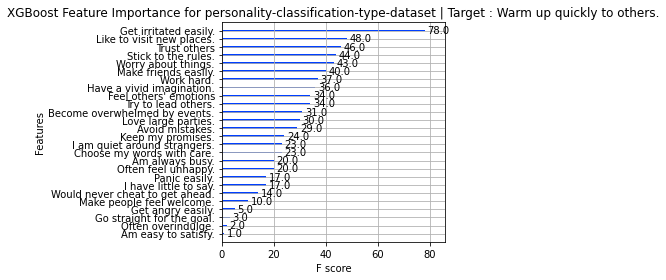

Target Variable: Avoid mistakes.
CATS=====================
['Make friends easily.', 'Have a vivid imagination.', 'Trust others', 'Get angry easily.', 'Love large parties.', 'Would never cheat to get ahead.', 'Like order.', 'Often feel unhappy.', 'Take charge.', 'Make people feel welcome.', 'Try to follow the rules.', 'Am easy to satisfy.', 'Go straight for the goal.', 'Often overindulge.', 'Avoid mistakes.', 'Warm up quickly to others.', 'Get irritated easily.', 'Stick to the rules.', 'Try to lead others.', 'Keep my promises.', "Feel others' emotions", 'Like to visit new places.', 'Work hard.', 'Choose my words with care.', 'I have little to say.']
CONTS=====================
['Worry about things.', 'Am always busy.', 'Panic easily.', 'Become overwhelmed by events.', 'I am quiet around strangers.']
30
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['Worry about things.', 'Am always busy.', 'Panic easily.', 'Become overwhelmed by events.'

 10%|▉         | 4/42 [00:00<00:00, 38.04it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.5757575757575757, 'Adjusted R-Squared': 1.3446969696969697, 'RMSE': 0.2672612419124244, 'Time taken': 0.055361032485961914}
{'Model': 'BaggingRegressor', 'R-Squared': 0.5163636363636364, 'Adjusted R-Squared': 1.3929545454545456, 'RMSE': 0.2853569193634025, 'Time taken': 0.027418136596679688}
{'Model': 'BayesianRidge', 'R-Squared': 0.4635531866726006, 'Adjusted R-Squared': 1.435863035828512, 'RMSE': 0.3005330709484312, 'Time taken': 0.011637687683105469}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.5757575757575757, 'Adjusted R-Squared': 1.3446969696969697, 'RMSE': 0.2672612419124244, 'Time taken': 0.010451316833496094}
{'Model': 'DummyRegressor', 'R-Squared': -0.017045454545454808, 'Adjusted R-Squared': 1.826349431818182, 'RMSE': 0.41380822236630244, 'Time taken': 0.012277841567993164}
{'Model': 'ElasticNet', 'R-Squared': -0.017045454545454808, 'Adjusted R-Squared': 1.826349431818182, 'RMSE': 0.41380822236630244, 'Time taken': 0.011914

 26%|██▌       | 11/42 [00:00<00:01, 20.23it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.40781677660378, 'Adjusted R-Squared': 1.4811488690094288, 'RMSE': 0.31575990598059434, 'Time taken': 0.2503800392150879}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.15151515151515138, 'Adjusted R-Squared': 1.6893939393939394, 'RMSE': 0.3779644730092272, 'Time taken': 0.010934591293334961}
{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.825, 'Adjusted R-Squared': 1.1421875, 'RMSE': 0.1716516405813988, 'Time taken': 0.1054697036743164}
{'Model': 'GammaRegressor', 'R-Squared': 0.42755234845389745, 'Adjusted R-Squared': 1.4651137168812083, 'RMSE': 0.310453687934529, 'Time taken': 0.012291193008422852}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -16.399039910873764, 'Adjusted R-Squared': 15.136719927584933, 'RMSE': 1.71155782522113, 'Time taken': 0.012371540069580078}


 33%|███▎      | 14/42 [00:00<00:01, 18.00it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.7215018912614184, 'Adjusted R-Squared': 1.2262797133500976, 'RMSE': 0.21654096078059135, 'Time taken': 0.0895540714263916}
{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.7195309822285613, 'Adjusted R-Squared': 1.227881076939294, 'RMSE': 0.21730583153864372, 'Time taken': 0.06742215156555176}
{'Model': 'HuberRegressor', 'R-Squared': -0.10658896358348446, 'Adjusted R-Squared': 1.899103532911581, 'RMSE': 0.4316404151029889, 'Time taken': 0.03621363639831543}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.06666666666666643, 'Adjusted R-Squared': 1.7583333333333335, 'RMSE': 0.39641248358604597, 'Time taken': 0.012194633483886719}
{'Model': 'KernelRidge', 'R-Squared': -14.29010112547186, 'Adjusted R-Squared': 13.423207164445886, 'RMSE': 1.6044792803028907, 'Time taken': 0.010405778884887695}
{'Model': 'Lars', 'R-Squared': -250.52885380072942, 'Adjusted R-Squared': 205.36719371309266, 'RMSE': 6.507629813763222, 'Time taken': 0.

 60%|█████▉    | 25/42 [00:01<00:00, 22.91it/s]

{'Model': 'LassoCV', 'R-Squared': 0.41756323170366927, 'Adjusted R-Squared': 1.4732298742407688, 'RMSE': 0.3131506561347868, 'Time taken': 0.26479005813598633}
{'Model': 'LassoLars', 'R-Squared': -0.017045454545454808, 'Adjusted R-Squared': 1.826349431818182, 'RMSE': 0.41380822236630244, 'Time taken': 0.012804269790649414}
{'Model': 'LassoLarsCV', 'R-Squared': 0.4141475171855633, 'Adjusted R-Squared': 1.4760051422867297, 'RMSE': 0.31406755360743854, 'Time taken': 0.04692506790161133}
{'Model': 'LassoLarsIC', 'R-Squared': 0.4794607621412402, 'Adjusted R-Squared': 1.4229381307602424, 'RMSE': 0.2960435955325019, 'Time taken': 0.0180511474609375}
{'Model': 'LinearRegression', 'R-Squared': 0.3170253811414072, 'Adjusted R-Squared': 1.5549168778226066, 'RMSE': 0.3391026756068767, 'Time taken': 0.010601520538330078}
{'Model': 'LinearSVR', 'R-Squared': 0.07124737136737513, 'Adjusted R-Squared': 1.7546115107640077, 'RMSE': 0.3954385110801537, 'Time taken': 0.014880657196044922}
{'Model': 'MLPReg

 76%|███████▌  | 32/42 [00:01<00:00, 26.08it/s]

{'Model': 'NuSVR', 'R-Squared': 0.3581686488439484, 'Adjusted R-Squared': 1.5214879728142918, 'RMSE': 0.3287300439209565, 'Time taken': 0.013524293899536133}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.5521141970881114, 'Adjusted R-Squared': 1.3639072148659095, 'RMSE': 0.2746076189180081, 'Time taken': 0.011782407760620117}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.5521141970881114, 'Adjusted R-Squared': 1.3639072148659095, 'RMSE': 0.2746076189180081, 'Time taken': 0.017536401748657227}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.0826232495207666, 'Adjusted R-Squared': 1.7453686097643772, 'RMSE': 0.39300927421818377, 'Time taken': 0.010654926300048828}
{'Model': 'PoissonRegressor', 'R-Squared': 0.45150163323836334, 'Adjusted R-Squared': 1.4456549229938298, 'RMSE': 0.30389013608853477, 'Time taken': 0.012108325958251953}
{'Model': 'QuantileRegressor', 'R-Squared': -0.27272727275848463, 'Adjusted R-Squared': 2.0340909091162684, 'RMSE': 0.462910049891951

 83%|████████▎ | 35/42 [00:01<00:00, 18.54it/s]

{'Model': 'RANSACRegressor', 'R-Squared': -0.27272727272727293, 'Adjusted R-Squared': 2.034090909090909, 'RMSE': 0.4629100498862757, 'Time taken': 0.148606538772583}
{'Model': 'RandomForestRegressor', 'R-Squared': 0.668581818181818, 'Adjusted R-Squared': 1.2692772727272728, 'RMSE': 0.23622023622035435, 'Time taken': 0.1374506950378418}
{'Model': 'Ridge', 'R-Squared': 0.35292807374280033, 'Adjusted R-Squared': 1.5257459400839748, 'RMSE': 0.33006936165371015, 'Time taken': 0.011040925979614258}
{'Model': 'RidgeCV', 'R-Squared': 0.45865990784354715, 'Adjusted R-Squared': 1.439838824877118, 'RMSE': 0.30190063780650445, 'Time taken': 0.011240720748901367}
{'Model': 'SGDRegressor', 'R-Squared': 0.5745926850252935, 'Adjusted R-Squared': 1.345643443416949, 'RMSE': 0.2676279151931639, 'Time taken': 0.010788679122924805}
{'Model': 'SVR', 'R-Squared': 0.4546933708997798, 'Adjusted R-Squared': 1.4430616361439288, 'RMSE': 0.3030046706071227, 'Time taken': 0.01056528091430664}
{'Model': 'Transformed

100%|██████████| 42/42 [00:02<00:00, 19.22it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.6315183899958943, 'Adjusted R-Squared': 1.299391308128336, 'RMSE': 0.24907884, 'Time taken': 0.3683445453643799}
{'Model': 'LGBMRegressor', 'R-Squared': 0.7195309822285613, 'Adjusted R-Squared': 1.227881076939294, 'RMSE': 0.21730583153864372, 'Time taken': 0.039267539978027344}
Project: personality-classification-type-dataset
personality-classification-type-dataset
Target: Avoid mistakes.
Avoid mistakes.
Target Standard Deviation: 0.4428427417013302
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
Lars                                       205.37    -250.53  6.51        0.02
GaussianProcessRegressor                    15.14     -16.40  1.71        0.01
KernelRidge                                 13.42     -14.29  1.60        0.01
QuantileRegressor                            2.03      -0.27  0.46        0.07
RANSACRegressor                

Better model found at epoch 0 with _rmse value: 2.5406723022460938.
No improvement since epoch 0: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       2       1.98
1       2       2.01
2       2       1.99
3       1       1.14
4       2       2.00
XGBoost RMSE:  0.24908227


<Figure size 432x288 with 0 Axes>

<Figure size 720x720 with 0 Axes>

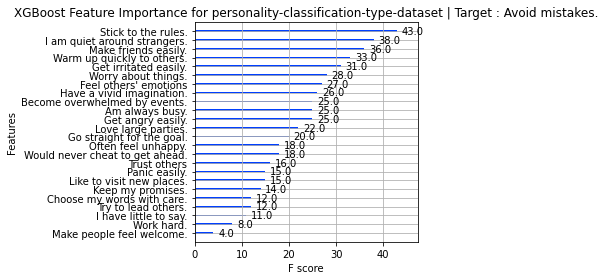

Target Variable: Panic easily.
CATS=====================
['Make friends easily.', 'Have a vivid imagination.', 'Trust others', 'Get angry easily.', 'Love large parties.', 'Would never cheat to get ahead.', 'Like order.', 'Often feel unhappy.', 'Take charge.', 'Make people feel welcome.', 'Try to follow the rules.', 'Am easy to satisfy.', 'Go straight for the goal.', 'Often overindulge.', 'Avoid mistakes.', 'Warm up quickly to others.', 'Get irritated easily.', 'Stick to the rules.', 'Try to lead others.', 'Keep my promises.', "Feel others' emotions", 'Like to visit new places.', 'Work hard.', 'Choose my words with care.', 'I have little to say.']
CONTS=====================
['Worry about things.', 'Am always busy.', 'Become overwhelmed by events.', 'I am quiet around strangers.']
29
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['Worry about things.', 'Am always busy.', 'Become overwhelmed by events.', 'I am quiet around strangers.']
Ca

  5%|▍         | 2/42 [00:00<00:02, 18.62it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.3956715622626593, 'Adjusted R-Squared': 1.4910168556615893, 'RMSE': 1.1922269659335174, 'Time taken': 0.07971882820129395}
{'Model': 'BaggingRegressor', 'R-Squared': 0.6164425125650949, 'Adjusted R-Squared': 1.3116404585408605, 'RMSE': 0.9498120114753537, 'Time taken': 0.027492761611938477}


 17%|█▋        | 7/42 [00:00<00:01, 25.55it/s]

{'Model': 'BayesianRidge', 'R-Squared': 0.5867586714930755, 'Adjusted R-Squared': 1.335758579411876, 'RMSE': 0.9858805517177989, 'Time taken': 0.013640642166137695}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.5748373060895746, 'Adjusted R-Squared': 1.3454446888022207, 'RMSE': 1.0, 'Time taken': 0.011661052703857422}
{'Model': 'DummyRegressor', 'R-Squared': -0.059788500493745955, 'Adjusted R-Squared': 1.8610781566511685, 'RMSE': 1.5788178, 'Time taken': 0.009816408157348633}
{'Model': 'ElasticNet', 'R-Squared': 0.20919332584906591, 'Adjusted R-Squared': 1.642530422747634, 'RMSE': 1.3638216736307371, 'Time taken': 0.01056361198425293}
{'Model': 'ElasticNetCV', 'R-Squared': 0.6490422133727156, 'Adjusted R-Squared': 1.2851532016346685, 'RMSE': 0.9085521619498425, 'Time taken': 0.1283407211303711}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.39262472298510664, 'Adjusted R-Squared': 1.493492412574601, 'RMSE': 1.1952286093343936, 'Time taken': 0.012729883193969727}


 24%|██▍       | 10/42 [00:00<00:01, 24.27it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.4835882813472423, 'Adjusted R-Squared': 1.4195845214053655, 'RMSE': 1.102098647386625, 'Time taken': 0.11131024360656738}
GammaRegressor model failed to execute
Some value(s) of y are out of the valid range for family GammaDistribution
{'Model': 'GaussianProcessRegressor', 'R-Squared': -0.0005841559760695336, 'Adjusted R-Squared': 1.8129746267305564, 'RMSE': 1.5340843367622305, 'Time taken': 0.01446986198425293}


 31%|███       | 13/42 [00:00<00:01, 20.94it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.48952855318127986, 'Adjusted R-Squared': 1.4147580505402102, 'RMSE': 1.0957416058964895, 'Time taken': 0.08754563331604004}
{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.5485890598334684, 'Adjusted R-Squared': 1.366771388885307, 'RMSE': 1.0304062043462177, 'Time taken': 0.07386088371276855}


 43%|████▎     | 18/42 [00:00<00:00, 27.52it/s]

{'Model': 'HuberRegressor', 'R-Squared': 0.7421471278566714, 'Adjusted R-Squared': 1.2095054586164546, 'RMSE': 0.7787685625598644, 'Time taken': 0.040358781814575195}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.5748373256614905, 'Adjusted R-Squared': 1.3454446729000389, 'RMSE': 1.0, 'Time taken': 0.010549068450927734}
{'Model': 'KernelRidge', 'R-Squared': 0.5315125812288728, 'Adjusted R-Squared': 1.3806460277515409, 'RMSE': 1.0497149709537628, 'Time taken': 0.010254383087158203}
{'Model': 'Lars', 'R-Squared': -0.03036177193564793, 'Adjusted R-Squared': 1.837168939697714, 'RMSE': 1.5567443334641375, 'Time taken': 0.014932870864868164}
{'Model': 'LarsCV', 'R-Squared': 0.654015845749963, 'Adjusted R-Squared': 1.2811121253281552, 'RMSE': 0.9020913727223031, 'Time taken': 0.03784465789794922}
{'Model': 'Lasso', 'R-Squared': -0.05978851348781711, 'Adjusted R-Squared': 1.8610781672088514, 'RMSE': 1.5788178540688378, 'Time taken': 0.012718439102172852}


 50%|█████     | 21/42 [00:00<00:00, 24.01it/s]

{'Model': 'LassoCV', 'R-Squared': 0.6556301555164153, 'Adjusted R-Squared': 1.2798004986429126, 'RMSE': 0.8999844011513668, 'Time taken': 0.13871097564697266}
{'Model': 'LassoLars', 'R-Squared': -0.05978851348781711, 'Adjusted R-Squared': 1.8610781672088514, 'RMSE': 1.5788178540688378, 'Time taken': 0.011659860610961914}
{'Model': 'LassoLarsCV', 'R-Squared': 0.654015845749963, 'Adjusted R-Squared': 1.2811121253281552, 'RMSE': 0.9020913727223031, 'Time taken': 0.0462799072265625}
{'Model': 'LassoLarsIC', 'R-Squared': 0.6391334072364693, 'Adjusted R-Squared': 1.2932041066203688, 'RMSE': 0.9212887425949552, 'Time taken': 0.02056431770324707}
{'Model': 'LinearRegression', 'R-Squared': 0.6671372014658911, 'Adjusted R-Squared': 1.2704510238089635, 'RMSE': 0.8848202534010118, 'Time taken': 0.011785030364990234}
{'Model': 'LinearSVR', 'R-Squared': 0.7432928862054318, 'Adjusted R-Squared': 1.2085745299580868, 'RMSE': 0.7770364236351146, 'Time taken': 0.012518167495727539}


 62%|██████▏   | 26/42 [00:01<00:00, 22.89it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.29822756075134804, 'Adjusted R-Squared': 1.5701901068895299, 'RMSE': 1.2847557763818758, 'Time taken': 0.14078855514526367}
{'Model': 'NuSVR', 'R-Squared': 0.33929664359088396, 'Adjusted R-Squared': 1.5368214770824067, 'RMSE': 1.2465958634424024, 'Time taken': 0.011636734008789062}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.4047275069862949, 'Adjusted R-Squared': 1.4836589005736354, 'RMSE': 1.1832604053564622, 'Time taken': 0.010105133056640625}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.46756841851154984, 'Adjusted R-Squared': 1.4326006599593657, 'RMSE': 1.1190624645072644, 'Time taken': 0.01529383659362793}


 76%|███████▌  | 32/42 [00:01<00:00, 28.24it/s]

{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.35509699843807063, 'Adjusted R-Squared': 1.5239836887690676, 'RMSE': 1.2315998406940276, 'Time taken': 0.012329339981079102}
PoissonRegressor model failed to execute
Some value(s) of y are out of the valid range for family PoissonDistribution
{'Model': 'QuantileRegressor', 'R-Squared': -0.4880694286873377, 'Adjusted R-Squared': 2.209056410808462, 'RMSE': 1.8708286933875045, 'Time taken': 0.08263134956359863}


 83%|████████▎ | 35/42 [00:01<00:00, 19.58it/s]

{'Model': 'RANSACRegressor', 'R-Squared': -1.5813449273132965, 'Adjusted R-Squared': 3.0973427534420535, 'RMSE': 2.4640269015229057, 'Time taken': 0.16143345832824707}
{'Model': 'RandomForestRegressor', 'R-Squared': 0.6037180005116328, 'Adjusted R-Squared': 1.3219791245842982, 'RMSE': 0.9654384644147076, 'Time taken': 0.13866710662841797}
{'Model': 'Ridge', 'R-Squared': 0.5252456816349301, 'Adjusted R-Squared': 1.3857378836716192, 'RMSE': 1.0567126022428677, 'Time taken': 0.01122903823852539}
{'Model': 'RidgeCV', 'R-Squared': 0.5667478251762093, 'Adjusted R-Squared': 1.35201739204433, 'RMSE': 1.0094685676668662, 'Time taken': 0.011643171310424805}
{'Model': 'SGDRegressor', 'R-Squared': 0.5207459481210046, 'Adjusted R-Squared': 1.3893939171516838, 'RMSE': 1.0617085666622628, 'Time taken': 0.010710477828979492}
{'Model': 'SVR', 'R-Squared': 0.34261932709864473, 'Adjusted R-Squared': 1.534121796732351, 'RMSE': 1.2434573412856542, 'Time taken': 0.010335445404052734}
{'Model': 'TransformedT

100%|██████████| 42/42 [00:02<00:00, 20.79it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.42488354042889076, 'Adjusted R-Squared': 1.4672821234015263, 'RMSE': 1.1630552, 'Time taken': 0.369459867477417}
{'Model': 'LGBMRegressor', 'R-Squared': 0.5485890598334684, 'Adjusted R-Squared': 1.366771388885307, 'RMSE': 1.0304062043462177, 'Time taken': 0.026149511337280273}
Project: personality-classification-type-dataset
personality-classification-type-dataset
Target: Panic easily.
Panic easily.
Target Standard Deviation: 1.3082109689712524
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
RANSACRegressor                              3.10      -1.58  2.46        0.16
QuantileRegressor                            2.21      -0.49  1.87        0.08
LassoLars                                    1.86      -0.06  1.58        0.01
Lasso                                        1.86      -0.06  1.58        0.01
DummyRegressor                      

Better model found at epoch 0 with _rmse value: 1.4816968441009521.
No improvement since epoch 0: early stopping


<Figure size 432x288 with 0 Axes>

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
   actual  predicted
0   -1.00      -0.85
1    2.00       2.01
2    0.00      -0.84
3    2.00       2.01
4   -2.00      -1.82
XGBoost RMSE:  1.1630552


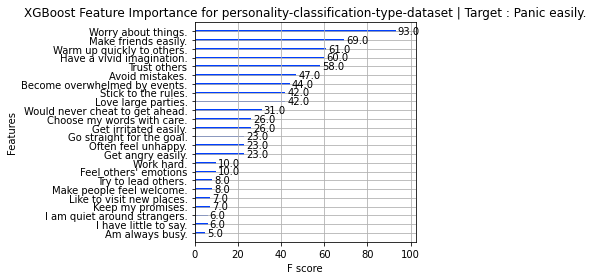

Target Variable: Often overindulge.
CATS=====================
['Make friends easily.', 'Have a vivid imagination.', 'Trust others', 'Get angry easily.', 'Love large parties.', 'Would never cheat to get ahead.', 'Like order.', 'Often feel unhappy.', 'Take charge.', 'Make people feel welcome.', 'Try to follow the rules.', 'Am easy to satisfy.', 'Go straight for the goal.', 'Often overindulge.', 'Avoid mistakes.', 'Warm up quickly to others.', 'Get irritated easily.', 'Stick to the rules.', 'Try to lead others.', 'Keep my promises.', "Feel others' emotions", 'Like to visit new places.', 'Work hard.', 'Choose my words with care.', 'I have little to say.']
CONTS=====================
['Worry about things.', 'Am always busy.', 'Panic easily.', 'Become overwhelmed by events.', 'I am quiet around strangers.']
30
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['Worry about things.', 'Am always busy.', 'Panic easily.', 'Become overwhelmed by event

  0%|          | 0/42 [00:00<?, ?it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.017555952072143555}
{'Model': 'BaggingRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.02641129493713379}
{'Model': 'BayesianRidge', 'R-Squared': 0.9980049097250451, 'Adjusted R-Squared': 1.001621010848401, 'RMSE': 0.0325364308056046, 'Time taken': 0.011176109313964844}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.010516643524169922}
{'Model': 'DummyRegressor', 'R-Squared': -0.10156249999999978, 'Adjusted R-Squared': 1.8950195312499998, 'RMSE': 0.7645276653074159, 'Time taken': 0.009441375732421875}
{'Model': 'ElasticNet', 'R-Squared': 0.47020840369241856, 'Adjusted R-Squared': 1.43045567199991, 'RMSE': 0.5302017618273624, 'Time taken': 0.010281085968017578}


 17%|█▋        | 7/42 [00:00<00:01, 34.45it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.9957645812501988, 'Adjusted R-Squared': 1.0034412777342134, 'RMSE': 0.047406381963981226, 'Time taken': 0.11733007431030273}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.01154637336730957}


 26%|██▌       | 11/42 [00:00<00:00, 31.46it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.10195541381835938}
{'Model': 'GammaRegressor', 'R-Squared': 0.9332744924285291, 'Adjusted R-Squared': 1.05421447490182, 'RMSE': 0.18816315092082708, 'Time taken': 0.013263940811157227}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -4.6043978439878, 'Adjusted R-Squared': 5.553573248240087, 'RMSE': 1.7244599506221214, 'Time taken': 0.012642621994018555}
{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.9999999992228389, 'Adjusted R-Squared': 1.0000000006314433, 'RMSE': 2.030692427879887e-05, 'Time taken': 0.07904219627380371}
{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.9940302116999549, 'Adjusted R-Squared': 1.0048504529937867, 'RMSE': 0.05628181563749091, 'Time taken': 0.07937097549438477}


 36%|███▌      | 15/42 [00:00<00:01, 24.90it/s]

{'Model': 'HuberRegressor', 'R-Squared': 0.9999986201870179, 'Adjusted R-Squared': 1.000001121098048, 'RMSE': 0.0008556551080837914, 'Time taken': 0.03977346420288086}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.8223076923076923, 'Adjusted R-Squared': 1.144375, 'RMSE': 0.3070597894314954, 'Time taken': 0.010656595230102539}
{'Model': 'KernelRidge', 'R-Squared': -5.273064271434756, 'Adjusted R-Squared': 6.096864720540739, 'RMSE': 1.8244354511615852, 'Time taken': 0.011122941970825195}
{'Model': 'Lars', 'R-Squared': 0.5909225212022662, 'Adjusted R-Squared': 1.3323754515231587, 'RMSE': 0.46589861489605533, 'Time taken': 0.015407323837280273}
{'Model': 'LarsCV', 'R-Squared': 0.9971840258131446, 'Adjusted R-Squared': 1.00228797902682, 'RMSE': 0.03865475889023281, 'Time taken': 0.03594970703125}


 48%|████▊     | 20/42 [00:00<00:00, 26.34it/s]

{'Model': 'Lasso', 'R-Squared': -0.10156249999999978, 'Adjusted R-Squared': 1.8950195312499998, 'RMSE': 0.7645276653074159, 'Time taken': 0.012239694595336914}
{'Model': 'LassoCV', 'R-Squared': 0.9977035789515353, 'Adjusted R-Squared': 1.0018658421018776, 'RMSE': 0.03490715009502775, 'Time taken': 0.09718441963195801}
{'Model': 'LassoLars', 'R-Squared': -0.10156249999999978, 'Adjusted R-Squared': 1.8950195312499998, 'RMSE': 0.7645276653074159, 'Time taken': 0.011146068572998047}
{'Model': 'LassoLarsCV', 'R-Squared': 0.9977408470978409, 'Adjusted R-Squared': 1.0018355617330041, 'RMSE': 0.034622740980204444, 'Time taken': 0.03701162338256836}
{'Model': 'LassoLarsIC', 'R-Squared': 0.9965858521904335, 'Adjusted R-Squared': 1.0027739950952728, 'RMSE': 0.042562761114001174, 'Time taken': 0.014842033386230469}
{'Model': 'LinearRegression', 'R-Squared': 0.997722650731267, 'Adjusted R-Squared': 1.0018503462808457, 'RMSE': 0.03476189591922646, 'Time taken': 0.010237932205200195}
{'Model': 'Linea

 62%|██████▏   | 26/42 [00:00<00:00, 28.86it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.4597951525601913, 'Adjusted R-Squared': 1.4389164385448445, 'RMSE': 0.5353870626049873, 'Time taken': 0.08938026428222656}
{'Model': 'NuSVR', 'R-Squared': 0.9196469358662671, 'Adjusted R-Squared': 1.065286864608658, 'RMSE': 0.2064856405284147, 'Time taken': 0.011988162994384766}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.9971046962746791, 'Adjusted R-Squared': 1.0023524342768233, 'RMSE': 0.03919545393733725, 'Time taken': 0.010658740997314453}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.9994564129608651, 'Adjusted R-Squared': 1.000441664469297, 'RMSE': 0.016983342990495424, 'Time taken': 0.015131473541259766}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.9869103244475071, 'Adjusted R-Squared': 1.0106353613864005, 'RMSE': 0.08333991918579098, 'Time taken': 0.010095357894897461}
{'Model': 'PoissonRegressor', 'R-Squared': 0.952108088024527, 'Adjusted R-Squared': 1.038912178480072, 'RMSE': 0.15941152695386002, 'Time t

 76%|███████▌  | 32/42 [00:01<00:00, 30.23it/s]

{'Model': 'QuantileRegressor', 'R-Squared': -0.3461538461551199, 'Adjusted R-Squared': 2.0937500000010347, 'RMSE': 0.8451542547289165, 'Time taken': 0.12137675285339355}
{'Model': 'RANSACRegressor', 'R-Squared': 0.997722650731267, 'Adjusted R-Squared': 1.0018503462808457, 'RMSE': 0.034761895919227036, 'Time taken': 0.0340576171875}
{'Model': 'RandomForestRegressor', 'R-Squared': 0.9999057692307692, 'Adjusted R-Squared': 1.0000765625, 'RMSE': 0.007071067811865459, 'Time taken': 0.18273425102233887}
{'Model': 'Ridge', 'R-Squared': 0.9957353176872632, 'Adjusted R-Squared': 1.0034650543790986, 'RMSE': 0.04756987130251574, 'Time taken': 0.01277923583984375}


 86%|████████▌ | 36/42 [00:01<00:00, 24.73it/s]

{'Model': 'RidgeCV', 'R-Squared': 0.9981497095623646, 'Adjusted R-Squared': 1.0015033609805788, 'RMSE': 0.03133347671144916, 'Time taken': 0.01271677017211914}
{'Model': 'SGDRegressor', 'R-Squared': 0.9701057584884366, 'Adjusted R-Squared': 1.0242890712281452, 'RMSE': 0.12594542706256723, 'Time taken': 0.012151718139648438}
{'Model': 'SVR', 'R-Squared': 0.871181259986921, 'Adjusted R-Squared': 1.1046652262606267, 'RMSE': 0.26144368575903004, 'Time taken': 0.010377645492553711}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.997722650731267, 'Adjusted R-Squared': 1.0018503462808457, 'RMSE': 0.03476189591922646, 'Time taken': 0.010782718658447266}
{'Model': 'TweedieRegressor', 'R-Squared': 0.9490647367629614, 'Adjusted R-Squared': 1.0413849013800938, 'RMSE': 0.16439852301852817, 'Time taken': 0.011806011199951172}


100%|██████████| 42/42 [00:01<00:00, 23.58it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.9999999627788113, 'Adjusted R-Squared': 1.0000000302422158, 'RMSE': 0.00014053476, 'Time taken': 0.3583674430847168}
{'Model': 'LGBMRegressor', 'R-Squared': 0.9940302116999549, 'Adjusted R-Squared': 1.0048504529937867, 'RMSE': 0.05628181563749091, 'Time taken': 0.034441471099853516}
Project: personality-classification-type-dataset
personality-classification-type-dataset
Target: Often overindulge.
Often overindulge.
Target Standard Deviation: 0.7887522437627776
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
KernelRidge                                  6.10      -5.27  1.82        0.01
GaussianProcessRegressor                     5.55      -4.60  1.72        0.01
QuantileRegressor                            2.09      -0.35  0.85        0.12
LassoLars                                    1.90      -0.10  0.76        0.01
DummyRegressor      

Better model found at epoch 0 with _rmse value: 3.3891782760620117.
No improvement since epoch 0: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       1       1.00
1       1       1.00
2       1       1.00
3       2       2.00
4       1       1.00
XGBoost RMSE:  0.00014053476


<Figure size 432x288 with 0 Axes>

<Figure size 720x720 with 0 Axes>

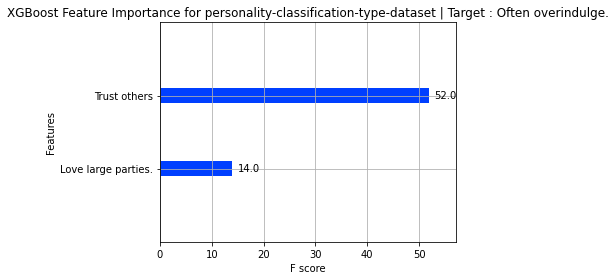

Target Variable: Go straight for the goal.
CATS=====================
['Make friends easily.', 'Have a vivid imagination.', 'Trust others', 'Get angry easily.', 'Love large parties.', 'Would never cheat to get ahead.', 'Like order.', 'Often feel unhappy.', 'Take charge.', 'Make people feel welcome.', 'Try to follow the rules.', 'Am easy to satisfy.', 'Go straight for the goal.', 'Often overindulge.', 'Avoid mistakes.', 'Warm up quickly to others.', 'Get irritated easily.', 'Stick to the rules.', 'Try to lead others.', 'Keep my promises.', "Feel others' emotions", 'Like to visit new places.', 'Work hard.', 'Choose my words with care.', 'I have little to say.']
CONTS=====================
['Worry about things.', 'Am always busy.', 'Panic easily.', 'Become overwhelmed by events.', 'I am quiet around strangers.']
30
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['Worry about things.', 'Am always busy.', 'Panic easily.', 'Become overwhelmed b

 14%|█▍        | 6/42 [00:00<00:00, 55.63it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.9996927297668038, 'Adjusted R-Squared': 1.0002496570644719, 'RMSE': 0.013998684185526912, 'Time taken': 0.038327932357788086}
{'Model': 'BaggingRegressor', 'R-Squared': 0.972, 'Adjusted R-Squared': 1.02275, 'RMSE': 0.1336306209562122, 'Time taken': 0.02764415740966797}
{'Model': 'BayesianRidge', 'R-Squared': 0.54372342391816, 'Adjusted R-Squared': 1.370724718066495, 'RMSE': 0.5394374053937195, 'Time taken': 0.01182413101196289}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.010137081146240234}
{'Model': 'DummyRegressor', 'R-Squared': -0.018000000000000016, 'Adjusted R-Squared': 1.827125, 'RMSE': 0.8057510123341769, 'Time taken': 0.009237527847290039}
{'Model': 'ElasticNet', 'R-Squared': 0.08766528925201211, 'Adjusted R-Squared': 1.74127195248274, 'RMSE': 0.7627883825468644, 'Time taken': 0.01031637191772461}
{'Model': 'ElasticNetCV', 'R-Squared': 0.7211538769115098, 'Adjusted R-S

 38%|███▊      | 16/42 [00:00<00:01, 24.74it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.8143525028656643, 'Adjusted R-Squared': 1.1508385914216477, 'RMSE': 0.3440895791484107, 'Time taken': 0.10159111022949219}
{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.6789250686786448, 'Adjusted R-Squared': 1.260873381698601, 'RMSE': 0.4525120723114456, 'Time taken': 0.06107187271118164}
{'Model': 'HuberRegressor', 'R-Squared': 0.9098929602734603, 'Adjusted R-Squared': 1.0732119697778135, 'RMSE': 0.23972113864946332, 'Time taken': 0.03748583793640137}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.7356799999999999, 'Adjusted R-Squared': 1.21476, 'RMSE': 0.41057451037714043, 'Time taken': 0.010468482971191406}
{'Model': 'KernelRidge', 'R-Squared': -4.886427216282523, 'Adjusted R-Squared': 5.78272211322955, 'RMSE': 1.9375497387102345, 'Time taken': 0.010207653045654297}
{'Model': 'Lars', 'R-Squared': -85.10294243524413, 'Adjusted R-Squared': 70.95864072863586, 'RMSE': 7.4103030193645685, 'Time taken': 0.0157341957092285

 60%|█████▉    | 25/42 [00:00<00:00, 26.41it/s]

{'Model': 'LassoCV', 'R-Squared': 0.7779841069819871, 'Adjusted R-Squared': 1.1803879130771355, 'RMSE': 0.3762868168118381, 'Time taken': 0.16892361640930176}
{'Model': 'LassoLars', 'R-Squared': -0.018000000000000016, 'Adjusted R-Squared': 1.827125, 'RMSE': 0.8057510123341769, 'Time taken': 0.015014886856079102}
{'Model': 'LassoLarsCV', 'R-Squared': 0.7927696470717223, 'Adjusted R-Squared': 1.1683746617542257, 'RMSE': 0.36354121482677604, 'Time taken': 0.05296897888183594}
{'Model': 'LassoLarsIC', 'R-Squared': 0.765621097808382, 'Adjusted R-Squared': 1.1904328580306895, 'RMSE': 0.38662170229234394, 'Time taken': 0.018958568572998047}
{'Model': 'LinearRegression', 'R-Squared': -0.7920000000000083, 'Adjusted R-Squared': 2.4560000000000066, 'RMSE': 1.0690449676496998, 'Time taken': 0.010873794555664062}
{'Model': 'LinearSVR', 'R-Squared': 0.45202669899388814, 'Adjusted R-Squared': 1.4452283070674659, 'RMSE': 0.5911622184297605, 'Time taken': 0.015496492385864258}


 69%|██████▉   | 29/42 [00:01<00:00, 26.07it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.783167238768724, 'Adjusted R-Squared': 1.1761766185004117, 'RMSE': 0.371868524837535, 'Time taken': 0.11249899864196777}
{'Model': 'NuSVR', 'R-Squared': 0.8722412896737434, 'Adjusted R-Squared': 1.1038039521400835, 'RMSE': 0.2854448621725829, 'Time taken': 0.014983177185058594}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.21064470016824033, 'Adjusted R-Squared': 1.6413511811133046, 'RMSE': 0.7095177022391077, 'Time taken': 0.011555194854736328}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.866698825157796, 'Adjusted R-Squared': 1.1083072045592908, 'RMSE': 0.291570753615054, 'Time taken': 0.017308950424194336}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.5159462447313012, 'Adjusted R-Squared': 1.3932936761558177, 'RMSE': 0.5556147515002002, 'Time taken': 0.012712240219116211}
{'Model': 'PoissonRegressor', 'R-Squared': 0.7499843559957264, 'Adjusted R-Squared': 1.2031377107534722, 'RMSE': 0.3993103461641657, 'Time taken

 79%|███████▊  | 33/42 [00:01<00:00, 22.72it/s]

{'Model': 'QuantileRegressor', 'R-Squared': -0.08550821924505425, 'Adjusted R-Squared': 1.8819754281366066, 'RMSE': 0.8320387041062297, 'Time taken': 0.17401647567749023}
{'Model': 'RANSACRegressor', 'R-Squared': -0.7919999999999796, 'Adjusted R-Squared': 2.4559999999999835, 'RMSE': 1.0690449676496914, 'Time taken': 0.02605152130126953}


 86%|████████▌ | 36/42 [00:01<00:00, 19.76it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.9681808, 'Adjusted R-Squared': 1.0258531, 'RMSE': 0.14245299976784323, 'Time taken': 0.18460512161254883}
{'Model': 'Ridge', 'R-Squared': 0.5421344648728679, 'Adjusted R-Squared': 1.3720157472907948, 'RMSE': 0.5403758701829469, 'Time taken': 0.011539220809936523}
{'Model': 'RidgeCV', 'R-Squared': 0.6703699770697029, 'Adjusted R-Squared': 1.2678243936308664, 'RMSE': 0.4585010675119832, 'Time taken': 0.011400222778320312}
{'Model': 'SGDRegressor', 'R-Squared': 0.6551397276703459, 'Adjusted R-Squared': 1.2801989712678439, 'RMSE': 0.46897377130221496, 'Time taken': 0.011732339859008789}
{'Model': 'SVR', 'R-Squared': 0.8521382786615138, 'Adjusted R-Squared': 1.12013764858752, 'RMSE': 0.3070823459272073, 'Time taken': 0.010509490966796875}
{'Model': 'TransformedTargetRegressor', 'R-Squared': -0.7920000000000083, 'Adjusted R-Squared': 2.4560000000000066, 'RMSE': 1.0690449676496998, 'Time taken': 0.010505914688110352}
{'Model': 'TweedieRegresso

100%|██████████| 42/42 [00:02<00:00, 17.76it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.9436150575659089, 'Adjusted R-Squared': 1.045812765727699, 'RMSE': 0.18963066, 'Time taken': 0.7010657787322998}
{'Model': 'LGBMRegressor', 'R-Squared': 0.6789250686786448, 'Adjusted R-Squared': 1.260873381698601, 'RMSE': 0.4525120723114456, 'Time taken': 0.03731870651245117}
Project: personality-classification-type-dataset
personality-classification-type-dataset
Target: Go straight for the goal.
Go straight for the goal.
Target Standard Deviation: 0.8885610931874806
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
Lars                                        70.96     -85.10  7.41        0.02
GaussianProcessRegressor                     6.43      -5.68  2.06        0.02
KernelRidge                                  5.78      -4.89  1.94        0.01
TransformedTargetRegressor                   2.46      -0.79  1.07        0.01
LinearRegress

Better model found at epoch 0 with _rmse value: 2.094668388366699.
No improvement since epoch 0: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       1       1.00
1       1       1.00
2       2       2.03
3       1       1.05
4       3       2.99
XGBoost RMSE:  0.18963066


<Figure size 432x288 with 0 Axes>

<Figure size 720x720 with 0 Axes>

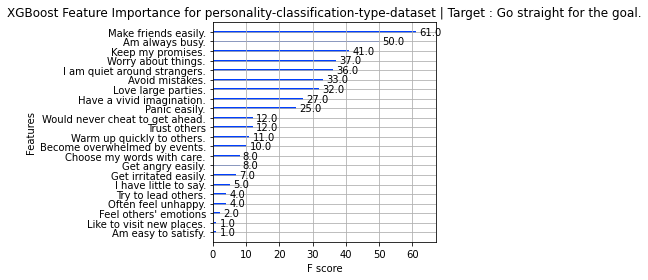

Target Variable: Am easy to satisfy.
CATS=====================
['Make friends easily.', 'Have a vivid imagination.', 'Trust others', 'Get angry easily.', 'Love large parties.', 'Would never cheat to get ahead.', 'Like order.', 'Often feel unhappy.', 'Take charge.', 'Make people feel welcome.', 'Try to follow the rules.', 'Am easy to satisfy.', 'Go straight for the goal.', 'Often overindulge.', 'Avoid mistakes.', 'Warm up quickly to others.', 'Get irritated easily.', 'Stick to the rules.', 'Try to lead others.', 'Keep my promises.', "Feel others' emotions", 'Like to visit new places.', 'Work hard.', 'Choose my words with care.', 'I have little to say.']
CONTS=====================
['Worry about things.', 'Am always busy.', 'Panic easily.', 'Become overwhelmed by events.', 'I am quiet around strangers.']
30
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['Worry about things.', 'Am always busy.', 'Panic easily.', 'Become overwhelmed by even

  0%|          | 0/42 [00:00<?, ?it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.0180816650390625}
{'Model': 'BaggingRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.02601146697998047}
{'Model': 'BayesianRidge', 'R-Squared': 0.9596153278748015, 'Adjusted R-Squared': 1.0328125461017237, 'RMSE': 0.09629117845967358, 'Time taken': 0.011456489562988281}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.010402679443359375}
{'Model': 'DummyRegressor', 'R-Squared': -0.02222222222222281, 'Adjusted R-Squared': 1.8305555555555562, 'RMSE': 0.4844521416518049, 'Time taken': 0.009257078170776367}
{'Model': 'ElasticNet', 'R-Squared': -0.02222222222222281, 'Adjusted R-Squared': 1.8305555555555562, 'RMSE': 0.4844521416518049, 'Time taken': 0.010526180267333984}
{'Model': 'ElasticNetCV', 'R-Squared': 0.9801848835125384, 'Adjusted R-Squared': 1.0160997821460624, 'RMSE': 0.0674491585527

 26%|██▌       | 11/42 [00:00<00:01, 29.76it/s]

{'Model': 'ExtraTreeRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.013919830322265625}
{'Model': 'ExtraTreesRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.10194110870361328}
{'Model': 'GammaRegressor', 'R-Squared': 0.8531943309177246, 'Adjusted R-Squared': 1.1192796061293488, 'RMSE': 0.18359025902172826, 'Time taken': 0.012605667114257812}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -11.330923018860581, 'Adjusted R-Squared': 11.018874952824222, 'RMSE': 1.6825811316350592, 'Time taken': 0.013757705688476562}
{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.9999999992788141, 'Adjusted R-Squared': 1.0000000005859635, 'RMSE': 1.2867726576306792e-05, 'Time taken': 0.07558274269104004}


 33%|███▎      | 14/42 [00:00<00:01, 22.18it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.7414653417580407, 'Adjusted R-Squared': 1.210059409821592, 'RMSE': 0.24363383805487238, 'Time taken': 0.08460855484008789}
{'Model': 'HuberRegressor', 'R-Squared': 0.9990432889653422, 'Adjusted R-Squared': 1.0007773277156595, 'RMSE': 0.01482069646377758, 'Time taken': 0.04386329650878906}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.8755555555555555, 'Adjusted R-Squared': 1.1011111111111112, 'RMSE': 0.16903085094570333, 'Time taken': 0.012539386749267578}
{'Model': 'KernelRidge', 'R-Squared': -11.110116706768224, 'Adjusted R-Squared': 10.839469824249182, 'RMSE': 1.6674483313669475, 'Time taken': 0.010405540466308594}
{'Model': 'Lars', 'R-Squared': 0.3671312875696914, 'Adjusted R-Squared': 1.5142058288496258, 'RMSE': 0.3811843256205524, 'Time taken': 0.014317989349365234}
{'Model': 'LarsCV', 'R-Squared': 0.9796304982030022, 'Adjusted R-Squared': 1.0165502202100607, 'RMSE': 0.06838619254603505, 'Time taken': 0.03388214111328125

 48%|████▊     | 20/42 [00:00<00:00, 24.11it/s]

{'Model': 'LassoCV', 'R-Squared': 0.9823996601768957, 'Adjusted R-Squared': 1.0143002761062723, 'RMSE': 0.0635680292847063, 'Time taken': 0.14018988609313965}
{'Model': 'LassoLars', 'R-Squared': -0.02222222222222281, 'Adjusted R-Squared': 1.8305555555555562, 'RMSE': 0.4844521416518049, 'Time taken': 0.011935234069824219}
{'Model': 'LassoLarsCV', 'R-Squared': 0.9796304982030022, 'Adjusted R-Squared': 1.0165502202100607, 'RMSE': 0.06838619254603505, 'Time taken': 0.04328513145446777}


 60%|█████▉    | 25/42 [00:00<00:00, 29.62it/s]

{'Model': 'LassoLarsIC', 'R-Squared': 0.9657081189453108, 'Adjusted R-Squared': 1.027862153356935, 'RMSE': 0.08873069342923978, 'Time taken': 0.018834352493286133}
{'Model': 'LinearRegression', 'R-Squared': 0.9581431983807266, 'Adjusted R-Squared': 1.0340086513156597, 'RMSE': 0.09803050527059776, 'Time taken': 0.010785579681396484}
{'Model': 'LinearSVR', 'R-Squared': 0.9998950494177044, 'Adjusted R-Squared': 1.0000852723481153, 'RMSE': 0.004908746984276551, 'Time taken': 0.015483856201171875}
{'Model': 'MLPRegressor', 'R-Squared': 0.5457930858446842, 'Adjusted R-Squared': 1.3690431177511941, 'RMSE': 0.32292754555552605, 'Time taken': 0.08711075782775879}
{'Model': 'NuSVR', 'R-Squared': 0.8844950604127073, 'Adjusted R-Squared': 1.0938477634146753, 'RMSE': 0.16284652661870427, 'Time taken': 0.011343717575073242}


 69%|██████▉   | 29/42 [00:01<00:00, 30.04it/s]

{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.9917020500840655, 'Adjusted R-Squared': 1.0067420843066968, 'RMSE': 0.0436479273543645, 'Time taken': 0.012270689010620117}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.9946174548250674, 'Adjusted R-Squared': 1.0043733179546328, 'RMSE': 0.03515378262748191, 'Time taken': 0.016515254974365234}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.9367613174959838, 'Adjusted R-Squared': 1.0513814295345132, 'RMSE': 0.12049516699344927, 'Time taken': 0.011355876922607422}
{'Model': 'PoissonRegressor', 'R-Squared': 0.8898906577032782, 'Adjusted R-Squared': 1.0894638406160864, 'RMSE': 0.15899750356390335, 'Time taken': 0.012099027633666992}
{'Model': 'QuantileRegressor', 'R-Squared': -0.5555555555309672, 'Adjusted R-Squared': 2.2638888888689106, 'RMSE': 0.5976143046624736, 'Time taken': 0.08514094352722168}


 79%|███████▊  | 33/42 [00:01<00:00, 23.54it/s]

{'Model': 'RANSACRegressor', 'R-Squared': -0.5555555555555562, 'Adjusted R-Squared': 2.2638888888888893, 'RMSE': 0.5976143046671968, 'Time taken': 0.14683866500854492}


 86%|████████▌ | 36/42 [00:01<00:00, 22.11it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.9996888888888888, 'Adjusted R-Squared': 1.0002527777777779, 'RMSE': 0.008451542547285173, 'Time taken': 0.13642573356628418}
{'Model': 'Ridge', 'R-Squared': 0.9594386231746516, 'Adjusted R-Squared': 1.0329561186705956, 'RMSE': 0.09650161141566387, 'Time taken': 0.011461734771728516}
{'Model': 'RidgeCV', 'R-Squared': 0.9594386231746982, 'Adjusted R-Squared': 1.0329561186705578, 'RMSE': 0.09650161141560837, 'Time taken': 0.011819124221801758}
{'Model': 'SGDRegressor', 'R-Squared': 0.9699404594998046, 'Adjusted R-Squared': 1.0244233766564088, 'RMSE': 0.08307481636958812, 'Time taken': 0.01127481460571289}
{'Model': 'SVR', 'R-Squared': 0.8348992406581794, 'Adjusted R-Squared': 1.1341443669652291, 'RMSE': 0.19469408461373763, 'Time taken': 0.010894298553466797}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.9581431983807266, 'Adjusted R-Squared': 1.0340086513156597, 'RMSE': 0.09803050527059776, 'Time taken': 0.010993242263793945}
{'M

100%|██████████| 42/42 [00:01<00:00, 22.30it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.9999995755704434, 'Adjusted R-Squared': 1.0000003448490147, 'RMSE': 0.0003121627, 'Time taken': 0.3543884754180908}
{'Model': 'LGBMRegressor', 'R-Squared': 0.7414653417580407, 'Adjusted R-Squared': 1.210059409821592, 'RMSE': 0.24363383805487238, 'Time taken': 0.031401634216308594}
Project: personality-classification-type-dataset
personality-classification-type-dataset
Target: Am easy to satisfy.
Am easy to satisfy.
Target Standard Deviation: 0.45175395145262565
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
GaussianProcessRegressor                    11.02     -11.33  1.68        0.01
KernelRidge                                 10.84     -11.11  1.67        0.01
RANSACRegressor                              2.26      -0.56  0.60        0.15
QuantileRegressor                            2.26      -0.56  0.60        0.09
LassoLars          

Better model found at epoch 0 with _rmse value: 1.6010936498641968.
No improvement since epoch 0: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       2       2.00
1       2       2.00
2       1       1.00
3       2       2.00
4       2       2.00
XGBoost RMSE:  0.0003121627


<Figure size 432x288 with 0 Axes>

<Figure size 720x720 with 0 Axes>

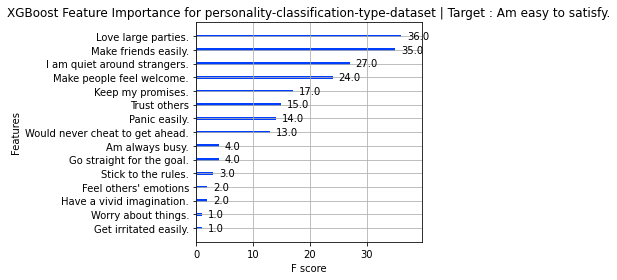

Target Variable: Am always busy.
CATS=====================
['Make friends easily.', 'Have a vivid imagination.', 'Trust others', 'Get angry easily.', 'Love large parties.', 'Would never cheat to get ahead.', 'Like order.', 'Often feel unhappy.', 'Take charge.', 'Make people feel welcome.', 'Try to follow the rules.', 'Am easy to satisfy.', 'Go straight for the goal.', 'Often overindulge.', 'Avoid mistakes.', 'Warm up quickly to others.', 'Get irritated easily.', 'Stick to the rules.', 'Try to lead others.', 'Keep my promises.', "Feel others' emotions", 'Like to visit new places.', 'Work hard.', 'Choose my words with care.', 'I have little to say.']
CONTS=====================
['Worry about things.', 'Panic easily.', 'Become overwhelmed by events.', 'I am quiet around strangers.']
29
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['Worry about things.', 'Panic easily.', 'Become overwhelmed by events.', 'I am quiet around strangers.']
Cate

  5%|▍         | 2/42 [00:00<00:02, 18.39it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.9471616664281289, 'Adjusted R-Squared': 1.0429311460271453, 'RMSE': 0.280567885626559, 'Time taken': 0.07991290092468262}
{'Model': 'BaggingRegressor', 'R-Squared': 0.5747260530927998, 'Adjusted R-Squared': 1.3455350818621001, 'RMSE': 0.7959720023791218, 'Time taken': 0.028668642044067383}
{'Model': 'BayesianRidge', 'R-Squared': 0.02443983995510135, 'Adjusted R-Squared': 1.7926426300364802, 'RMSE': 1.2055644455490162, 'Time taken': 0.012686729431152344}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.9041095948349042, 'Adjusted R-Squared': 1.0779109541966403, 'RMSE': 0.3779644730092272, 'Time taken': 0.012108802795410156}
{'Model': 'DummyRegressor', 'R-Squared': -0.001926230941291518, 'Adjusted R-Squared': 1.8140650626397994, 'RMSE': 1.2217469, 'Time taken': 0.010468482971191406}
{'Model': 'ElasticNet', 'R-Squared': 0.1736323285090028, 'Adjusted R-Squared': 1.6714237330864352, 'RMSE': 1.1095581365767406, 'Time taken': 0.01074528694152832}

 21%|██▏       | 9/42 [00:00<00:02, 15.50it/s]

{'Model': 'ElasticNetCV', 'R-Squared': -0.05145528892863149, 'Adjusted R-Squared': 1.854307422254513, 'RMSE': 1.2515805577103576, 'Time taken': 0.30567097663879395}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.5205479741745207, 'Adjusted R-Squared': 1.389554770983202, 'RMSE': 0.8451542547285166, 'Time taken': 0.012074470520019531}
{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.8891267190278579, 'Adjusted R-Squared': 1.0900845407898654, 'RMSE': 0.4064216670264658, 'Time taken': 0.10419583320617676}
GammaRegressor model failed to execute
Some value(s) of y are out of the valid range for family GammaDistribution
{'Model': 'GaussianProcessRegressor', 'R-Squared': -0.30845784181070846, 'Adjusted R-Squared': 2.0631219964712004, 'RMSE': 1.3961859725217147, 'Time taken': 0.01994919776916504}


 36%|███▌      | 15/42 [00:00<00:01, 20.44it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.5410709384657135, 'Adjusted R-Squared': 1.3728798624966077, 'RMSE': 0.8268679967228857, 'Time taken': 0.08750677108764648}
{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.5983736550270677, 'Adjusted R-Squared': 1.3263214052905075, 'RMSE': 0.7735252585416571, 'Time taken': 0.06585288047790527}
{'Model': 'HuberRegressor', 'R-Squared': 0.03489975330677586, 'Adjusted R-Squared': 1.7841439504382446, 'RMSE': 1.199084023416439, 'Time taken': 0.03932476043701172}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.7621917933615979, 'Adjusted R-Squared': 1.1932191678937016, 'RMSE': 0.595219, 'Time taken': 0.0106964111328125}
{'Model': 'KernelRidge', 'R-Squared': 0.16551131687095222, 'Adjusted R-Squared': 1.6780220550423515, 'RMSE': 1.1149968202492977, 'Time taken': 0.011878252029418945}
{'Model': 'Lars', 'R-Squared': -10.691828138684427, 'Adjusted R-Squared': 10.499610362681096, 'RMSE': 4.173540330667303, 'Time taken': 0.01626420021057

 60%|█████▉    | 25/42 [00:01<00:00, 28.04it/s]

{'Model': 'LassoCV', 'R-Squared': 0.12059085013552528, 'Adjusted R-Squared': 1.7145199342648856, 'RMSE': 1.144613577240443, 'Time taken': 0.1309196949005127}
{'Model': 'LassoLars', 'R-Squared': -0.0019263093254768826, 'Adjusted R-Squared': 1.81406512632695, 'RMSE': 1.2217470345069517, 'Time taken': 0.012748479843139648}
{'Model': 'LassoLarsCV', 'R-Squared': 0.2876119805031697, 'Adjusted R-Squared': 1.5788152658411745, 'RMSE': 1.0302003823848591, 'Time taken': 0.046352386474609375}
{'Model': 'LassoLarsIC', 'R-Squared': 0.2876119805031697, 'Adjusted R-Squared': 1.5788152658411745, 'RMSE': 1.0302003823848591, 'Time taken': 0.016690731048583984}
{'Model': 'LinearRegression', 'R-Squared': -0.09136435336862925, 'Adjusted R-Squared': 1.8867335371120113, 'RMSE': 1.2751118607163683, 'Time taken': 0.010683059692382812}
{'Model': 'LinearSVR', 'R-Squared': 0.4322774449536966, 'Adjusted R-Squared': 1.4612745759751216, 'RMSE': 0.9196688514768298, 'Time taken': 0.012584209442138672}
{'Model': 'MLPReg

 69%|██████▉   | 29/42 [00:01<00:00, 29.12it/s]

{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': -0.08361333462184262, 'Adjusted R-Squared': 1.880435834380247, 'RMSE': 1.2705757830801352, 'Time taken': 0.01221466064453125}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.15117715694290734, 'Adjusted R-Squared': 1.6896685599838879, 'RMSE': 1.124532295405678, 'Time taken': 0.016665220260620117}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.5404786908361016, 'Adjusted R-Squared': 1.3733610636956675, 'RMSE': 0.8274013609845515, 'Time taken': 0.01205754280090332}
PoissonRegressor model failed to execute
Some value(s) of y are out of the valid range for family PoissonDistribution
{'Model': 'QuantileRegressor', 'R-Squared': -0.0547944568161538, 'Adjusted R-Squared': 1.857020496163125, 'RMSE': 1.2535663410560764, 'Time taken': 0.07977294921875}


 86%|████████▌ | 36/42 [00:01<00:00, 21.84it/s]

{'Model': 'RANSACRegressor', 'R-Squared': 0.32563430593315323, 'Adjusted R-Squared': 1.547922126429313, 'RMSE': 1.002330942957913, 'Time taken': 0.15216064453125}
{'Model': 'RandomForestRegressor', 'R-Squared': 0.7845869993168705, 'Adjusted R-Squared': 1.1750230630550427, 'RMSE': 0.5664992749963838, 'Time taken': 0.13721346855163574}
{'Model': 'Ridge', 'R-Squared': 0.6480954489719086, 'Adjusted R-Squared': 1.2859224477103242, 'RMSE': 0.7240621488886813, 'Time taken': 0.011101961135864258}
{'Model': 'RidgeCV', 'R-Squared': 0.19793556996538364, 'Adjusted R-Squared': 1.6516773494031258, 'RMSE': 1.0931204811598656, 'Time taken': 0.011110544204711914}
{'Model': 'SGDRegressor', 'R-Squared': 0.5351018107589613, 'Adjusted R-Squared': 1.377729778758344, 'RMSE': 0.8322280136089887, 'Time taken': 0.012816429138183594}
{'Model': 'SVR', 'R-Squared': 0.7139218077595376, 'Adjusted R-Squared': 1.2324385311953756, 'RMSE': 0.6528385320162478, 'Time taken': 0.010457515716552734}
{'Model': 'TransformedTar

100%|██████████| 42/42 [00:02<00:00, 19.77it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.5024491273647336, 'Adjusted R-Squared': 1.4042600840161539, 'RMSE': 0.8609583, 'Time taken': 0.3707108497619629}
{'Model': 'LGBMRegressor', 'R-Squared': 0.5983736550270677, 'Adjusted R-Squared': 1.3263214052905075, 'RMSE': 0.7735252585416571, 'Time taken': 0.03171491622924805}
Project: personality-classification-type-dataset
personality-classification-type-dataset
Target: Am always busy.
Am always busy.
Target Standard Deviation: 1.3130768537521362
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
Lars                                        10.50     -10.69  4.17        0.02
GaussianProcessRegressor                     2.06      -0.31  1.40        0.02
LinearRegression                             1.89      -0.09  1.28        0.01
TransformedTargetRegressor                   1.89      -0.09  1.28        0.01
OrthogonalMatchingPursuit       

Better model found at epoch 0 with _rmse value: 1.6208730936050415.
No improvement since epoch 0: early stopping


<Figure size 432x288 with 0 Axes>

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
   actual  predicted
0    2.00       2.00
1    0.00      -0.96
2   -1.00      -0.85
3    2.00       2.04
4   -2.00      -2.00
XGBoost RMSE:  0.8609583


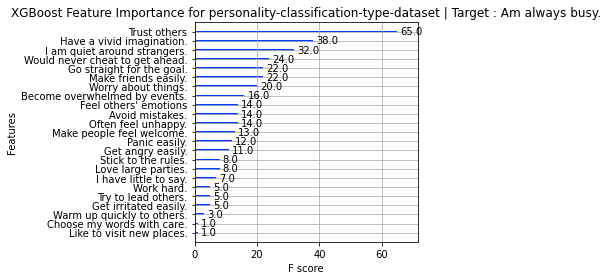

Target Variable: Try to follow the rules.
CATS=====================
['Make friends easily.', 'Have a vivid imagination.', 'Trust others', 'Get angry easily.', 'Love large parties.', 'Would never cheat to get ahead.', 'Like order.', 'Often feel unhappy.', 'Take charge.', 'Make people feel welcome.', 'Try to follow the rules.', 'Am easy to satisfy.', 'Go straight for the goal.', 'Often overindulge.', 'Avoid mistakes.', 'Warm up quickly to others.', 'Get irritated easily.', 'Stick to the rules.', 'Try to lead others.', 'Keep my promises.', "Feel others' emotions", 'Like to visit new places.', 'Work hard.', 'Choose my words with care.', 'I have little to say.']
CONTS=====================
['Worry about things.', 'Am always busy.', 'Panic easily.', 'Become overwhelmed by events.', 'I am quiet around strangers.']
30
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['Worry about things.', 'Am always busy.', 'Panic easily.', 'Become overwhelmed by

  0%|          | 0/42 [00:00<?, ?it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.013764142990112305}
{'Model': 'BaggingRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.026998043060302734}
{'Model': 'BayesianRidge', 'R-Squared': 0.9602425390543632, 'Adjusted R-Squared': 1.0323029370183299, 'RMSE': 0.1174453269307639, 'Time taken': 0.011800765991210938}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.010454177856445312}
{'Model': 'DummyRegressor', 'R-Squared': -0.2068014705882355, 'Adjusted R-Squared': 1.9805261948529413, 'RMSE': 0.6470596761426228, 'Time taken': 0.009722232818603516}
{'Model': 'ElasticNet', 'R-Squared': 0.16903908900638387, 'Adjusted R-Squared': 1.675155740182313, 'RMSE': 0.5369288229895736, 'Time taken': 0.010645151138305664}


 17%|█▋        | 7/42 [00:00<00:00, 40.14it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.9736214494656742, 'Adjusted R-Squared': 1.0214325723091398, 'RMSE': 0.0956647376106422, 'Time taken': 0.0904853343963623}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.011672019958496094}
{'Model': 'ExtraTreesRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.13897037506103516}
{'Model': 'GammaRegressor', 'R-Squared': 0.8294121864447963, 'Adjusted R-Squared': 1.138602598513603, 'RMSE': 0.243276647362227, 'Time taken': 0.015682458877563477}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -8.147570112331573, 'Adjusted R-Squared': 8.432400716269402, 'RMSE': 1.7814732031849527, 'Time taken': 0.014242172241210938}


 29%|██▊       | 12/42 [00:00<00:01, 25.55it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.9999999991485921, 'Adjusted R-Squared': 1.0000000006917689, 'RMSE': 1.718681016224368e-05, 'Time taken': 0.08230710029602051}
{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.816310615414849, 'Adjusted R-Squared': 1.1492476249754353, 'RMSE': 0.2524459747395376, 'Time taken': 0.06665611267089844}


 36%|███▌      | 15/42 [00:00<00:01, 25.03it/s]

{'Model': 'HuberRegressor', 'R-Squared': 0.9701426689038987, 'Adjusted R-Squared': 1.0242590815155823, 'RMSE': 0.10177753136367637, 'Time taken': 0.04396700859069824}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.8270588235294118, 'Adjusted R-Squared': 1.1405147058823528, 'RMSE': 0.2449489742783178, 'Time taken': 0.012435197830200195}
{'Model': 'KernelRidge', 'R-Squared': -10.281792978672833, 'Adjusted R-Squared': 10.166456795171676, 'RMSE': 1.9784062882988342, 'Time taken': 0.013316631317138672}
{'Model': 'Lars', 'R-Squared': -25.679998046931942, 'Adjusted R-Squared': 22.677498413132202, 'RMSE': 3.0424210512381755, 'Time taken': 0.016879558563232422}
{'Model': 'LarsCV', 'R-Squared': -0.2068014705882355, 'Adjusted R-Squared': 1.9805261948529413, 'RMSE': 0.6470596761426228, 'Time taken': 0.042693376541137695}


 48%|████▊     | 20/42 [00:00<00:00, 26.22it/s]

{'Model': 'Lasso', 'R-Squared': -0.2068014705882355, 'Adjusted R-Squared': 1.9805261948529413, 'RMSE': 0.6470596761426228, 'Time taken': 0.014434099197387695}
{'Model': 'LassoCV', 'R-Squared': 0.9608894085588165, 'Adjusted R-Squared': 1.0317773555459615, 'RMSE': 0.11648596784198546, 'Time taken': 0.08917355537414551}
{'Model': 'LassoLars', 'R-Squared': -0.2068014705882355, 'Adjusted R-Squared': 1.9805261948529413, 'RMSE': 0.6470596761426228, 'Time taken': 0.014421939849853516}
{'Model': 'LassoLarsCV', 'R-Squared': 0.7401274173214454, 'Adjusted R-Squared': 1.2111464734263255, 'RMSE': 0.3002663411426129, 'Time taken': 0.03140830993652344}
{'Model': 'LassoLarsIC', 'R-Squared': 0.946351779756411, 'Adjusted R-Squared': 1.043589178947916, 'RMSE': 0.13642817831962903, 'Time taken': 0.01971435546875}
{'Model': 'LinearRegression', 'R-Squared': -2.3455882352940645, 'Adjusted R-Squared': 3.7182904411764275, 'RMSE': 1.0773645092141597, 'Time taken': 0.01091909408569336}
{'Model': 'LinearSVR', 'R-S

 62%|██████▏   | 26/42 [00:00<00:00, 28.56it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.5925215480415595, 'Adjusted R-Squared': 1.3310762422162328, 'RMSE': 0.3759921211531631, 'Time taken': 0.09209680557250977}
{'Model': 'NuSVR', 'R-Squared': 0.9152544576257429, 'Adjusted R-Squared': 1.0688557531790839, 'RMSE': 0.17146869889654173, 'Time taken': 0.013291597366333008}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.8772544777162715, 'Adjusted R-Squared': 1.0997307368555294, 'RMSE': 0.2063617726238976, 'Time taken': 0.011873483657836914}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.9279017714722909, 'Adjusted R-Squared': 1.0585798106787636, 'RMSE': 0.15815710898299273, 'Time taken': 0.01689934730529785}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.9556205976698466, 'Adjusted R-Squared': 1.0360582643932497, 'RMSE': 0.12408438863248714, 'Time taken': 0.01310873031616211}
{'Model': 'PoissonRegressor', 'R-Squared': 0.8428474675435226, 'Adjusted R-Squared': 1.127686432620888, 'RMSE': 0.23350012243846444, 'Time t

 76%|███████▌  | 32/42 [00:01<00:00, 28.40it/s]

{'Model': 'QuantileRegressor', 'R-Squared': -0.23529411722253224, 'Adjusted R-Squared': 2.0036764702433074, 'RMSE': 0.6546536705954865, 'Time taken': 0.14256882667541504}
{'Model': 'RANSACRegressor', 'R-Squared': -2.3455882352941164, 'Adjusted R-Squared': 3.7182904411764697, 'RMSE': 1.077364509214168, 'Time taken': 0.06206321716308594}


 83%|████████▎ | 35/42 [00:01<00:00, 22.07it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.17183542251586914}
{'Model': 'Ridge', 'R-Squared': 0.9717265690415583, 'Adjusted R-Squared': 1.0229721626537338, 'RMSE': 0.09904115062030566, 'Time taken': 0.012042760848999023}
{'Model': 'RidgeCV', 'R-Squared': 0.9717265690415186, 'Adjusted R-Squared': 1.0229721626537662, 'RMSE': 0.09904115062037516, 'Time taken': 0.014111995697021484}
{'Model': 'SGDRegressor', 'R-Squared': 0.9128892135108438, 'Adjusted R-Squared': 1.0707775140224394, 'RMSE': 0.17384507355193776, 'Time taken': 0.012841224670410156}
{'Model': 'SVR', 'R-Squared': 0.869837758037987, 'Adjusted R-Squared': 1.1057568215941356, 'RMSE': 0.212504891341267, 'Time taken': 0.012089252471923828}
{'Model': 'TransformedTargetRegressor', 'R-Squared': -2.3455882352940645, 'Adjusted R-Squared': 3.7182904411764275, 'RMSE': 1.0773645092141597, 'Time taken': 0.011976003646850586}
{'Model': 'TweedieRegressor', 'R-Squared': 0.8161483

100%|██████████| 42/42 [00:01<00:00, 22.35it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.9999999484134844, 'Adjusted R-Squared': 1.000000041914044, 'RMSE': 0.00013378102, 'Time taken': 0.379727840423584}
{'Model': 'LGBMRegressor', 'R-Squared': 0.816310615414849, 'Adjusted R-Squared': 1.1492476249754353, 'RMSE': 0.2524459747395376, 'Time taken': 0.04272341728210449}
Project: personality-classification-type-dataset
personality-classification-type-dataset
Target: Try to follow the rules.
Try to follow the rules.
Target Standard Deviation: 0.7194013242315601
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
Lars                                        22.68     -25.68  3.04        0.02
KernelRidge                                 10.17     -10.28  1.98        0.01
GaussianProcessRegressor                     8.43      -8.15  1.78        0.01
RANSACRegressor                              3.72      -2.35  1.08        0.06
TransformedTa

Better model found at epoch 0 with _rmse value: 1.2726948261260986.
No improvement since epoch 0: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       2       2.00
1       2       2.00
2       2       2.00
3       2       2.00
4       1       1.00
XGBoost RMSE:  0.00013378102


<Figure size 432x288 with 0 Axes>

<Figure size 720x720 with 0 Axes>

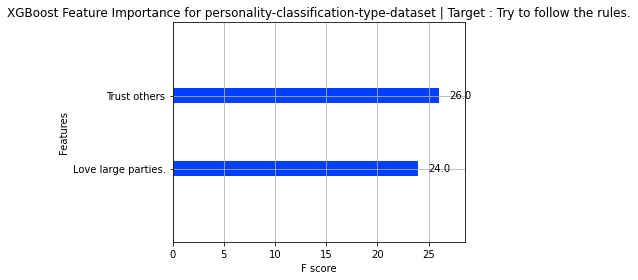

Target Variable: Make people feel welcome.
CATS=====================
['Make friends easily.', 'Have a vivid imagination.', 'Trust others', 'Get angry easily.', 'Love large parties.', 'Would never cheat to get ahead.', 'Like order.', 'Often feel unhappy.', 'Take charge.', 'Make people feel welcome.', 'Try to follow the rules.', 'Am easy to satisfy.', 'Go straight for the goal.', 'Often overindulge.', 'Avoid mistakes.', 'Warm up quickly to others.', 'Get irritated easily.', 'Stick to the rules.', 'Try to lead others.', 'Keep my promises.', "Feel others' emotions", 'Like to visit new places.', 'Work hard.', 'Choose my words with care.', 'I have little to say.']
CONTS=====================
['Worry about things.', 'Am always busy.', 'Panic easily.', 'Become overwhelmed by events.', 'I am quiet around strangers.']
30
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['Worry about things.', 'Am always busy.', 'Panic easily.', 'Become overwhelmed b

  0%|          | 0/42 [00:00<?, ?it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.7142857142857143, 'Adjusted R-Squared': 1.2321428571428572, 'RMSE': 0.2672612419124244, 'Time taken': 0.016475677490234375}
{'Model': 'BaggingRegressor', 'R-Squared': 0.9742857142857143, 'Adjusted R-Squared': 1.020892857142857, 'RMSE': 0.08017837257372731, 'Time taken': 0.030226707458496094}
{'Model': 'BayesianRidge', 'R-Squared': 0.9602077082862132, 'Adjusted R-Squared': 1.0323312370174518, 'RMSE': 0.09974002671168035, 'Time taken': 0.012669086456298828}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.01168370246887207}
{'Model': 'DummyRegressor', 'R-Squared': -0.21556122448979642, 'Adjusted R-Squared': 1.9876434948979596, 'RMSE': 0.5512624657297548, 'Time taken': 0.010925054550170898}
{'Model': 'ElasticNet', 'R-Squared': -0.21556122448979642, 'Adjusted R-Squared': 1.9876434948979596, 'RMSE': 0.5512624657297548, 'Time taken': 0.01166391372680664}


 17%|█▋        | 7/42 [00:00<00:00, 38.77it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.9848550918028528, 'Adjusted R-Squared': 1.012305237910182, 'RMSE': 0.06153232523874581, 'Time taken': 0.08615231513977051}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.012870550155639648}


 26%|██▌       | 11/42 [00:00<00:00, 32.37it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.9443142857142857, 'Adjusted R-Squared': 1.045244642857143, 'RMSE': 0.11798910361312427, 'Time taken': 0.10627627372741699}
{'Model': 'GammaRegressor', 'R-Squared': 0.8116584648880196, 'Adjusted R-Squared': 1.153027497278484, 'RMSE': 0.21699166753125593, 'Time taken': 0.014868497848510742}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -8.456978866284036, 'Adjusted R-Squared': 8.68379532885578, 'RMSE': 1.5376100664898786, 'Time taken': 0.012909650802612305}
{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.9404066091051059, 'Adjusted R-Squared': 1.0484196301021014, 'RMSE': 0.12205878798236337, 'Time taken': 0.08364367485046387}
{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.6812594276218475, 'Adjusted R-Squared': 1.2589767150572488, 'RMSE': 0.28228557011391514, 'Time taken': 0.07595157623291016}


 36%|███▌      | 15/42 [00:00<00:01, 24.83it/s]

{'Model': 'HuberRegressor', 'R-Squared': 0.999993915383763, 'Adjusted R-Squared': 1.0000049437506926, 'RMSE': 0.0012333507446128749, 'Time taken': 0.04274415969848633}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.8857142857142858, 'Adjusted R-Squared': 1.0928571428571427, 'RMSE': 0.16903085094570328, 'Time taken': 0.010906457901000977}
{'Model': 'KernelRidge', 'R-Squared': -11.316771958167278, 'Adjusted R-Squared': 11.007377216010914, 'RMSE': 1.7547629439732935, 'Time taken': 0.012192010879516602}
{'Model': 'Lars', 'R-Squared': -0.8483577572611054, 'Adjusted R-Squared': 2.501790677774648, 'RMSE': 0.6797716082003399, 'Time taken': 0.015645742416381836}


 43%|████▎     | 18/42 [00:00<00:00, 25.52it/s]

{'Model': 'LarsCV', 'R-Squared': 0.987029038204749, 'Adjusted R-Squared': 1.0105389064586414, 'RMSE': 0.056945065184024216, 'Time taken': 0.08039569854736328}
{'Model': 'Lasso', 'R-Squared': -0.21556122448979642, 'Adjusted R-Squared': 1.9876434948979596, 'RMSE': 0.5512624657297548, 'Time taken': 0.013602495193481445}


 50%|█████     | 21/42 [00:00<00:00, 25.85it/s]

{'Model': 'LassoCV', 'R-Squared': 0.9882461671464061, 'Adjusted R-Squared': 1.009549989193545, 'RMSE': 0.05420754756856721, 'Time taken': 0.08600401878356934}
{'Model': 'LassoLars', 'R-Squared': -0.21556122448979642, 'Adjusted R-Squared': 1.9876434948979596, 'RMSE': 0.5512624657297548, 'Time taken': 0.011569499969482422}
{'Model': 'LassoLarsCV', 'R-Squared': 0.987029038204749, 'Adjusted R-Squared': 1.0105389064586414, 'RMSE': 0.056945065184024216, 'Time taken': 0.04033064842224121}
{'Model': 'LassoLarsIC', 'R-Squared': 0.9893621144313699, 'Adjusted R-Squared': 1.008643282024512, 'RMSE': 0.05157006294506079, 'Time taken': 0.017748355865478516}
{'Model': 'LinearRegression', 'R-Squared': 0.9425370772051094, 'Adjusted R-Squared': 1.0466886247708487, 'RMSE': 0.11985712619082213, 'Time taken': 0.010731697082519531}
{'Model': 'LinearSVR', 'R-Squared': 0.9999880470612238, 'Adjusted R-Squared': 1.0000097117627558, 'RMSE': 0.0017286511198156313, 'Time taken': 0.017661333084106445}


 62%|██████▏   | 26/42 [00:00<00:00, 27.04it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.6682148854218751, 'Adjusted R-Squared': 1.2695754055947264, 'RMSE': 0.28800395595291955, 'Time taken': 0.08497262001037598}
{'Model': 'NuSVR', 'R-Squared': 0.7696348756142637, 'Adjusted R-Squared': 1.1871716635634106, 'RMSE': 0.23998183493013397, 'Time taken': 0.013246774673461914}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.9912116460122027, 'Adjusted R-Squared': 1.0071405376150853, 'RMSE': 0.04687311059604793, 'Time taken': 0.011448860168457031}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.9988662131519275, 'Adjusted R-Squared': 1.000921201814059, 'RMSE': 0.01683587574253663, 'Time taken': 0.017810583114624023}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.9158256452717437, 'Adjusted R-Squared': 1.0683916632167083, 'RMSE': 0.14506408474210314, 'Time taken': 0.012020111083984375}
{'Model': 'PoissonRegressor', 'R-Squared': 0.8587494882932905, 'Adjusted R-Squared': 1.1147660407617015, 'RMSE': 0.1879165451115931, 'Tim

 76%|███████▌  | 32/42 [00:01<00:00, 26.36it/s]


{'Model': 'RANSACRegressor', 'R-Squared': 0.9322625386127281, 'Adjusted R-Squared': 1.0550366873771584, 'RMSE': 0.13013210728647245, 'Time taken': 0.14378857612609863}


 83%|████████▎ | 35/42 [00:01<00:00, 19.40it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.9776857142857143, 'Adjusted R-Squared': 1.0181303571428573, 'RMSE': 0.07468983484097035, 'Time taken': 0.13414406776428223}
{'Model': 'Ridge', 'R-Squared': 0.9573485784735476, 'Adjusted R-Squared': 1.0346542799902425, 'RMSE': 0.1032611029459452, 'Time taken': 0.011964559555053711}
{'Model': 'RidgeCV', 'R-Squared': 0.9524543121010098, 'Adjusted R-Squared': 1.0386308714179295, 'RMSE': 0.10902486860688036, 'Time taken': 0.013827323913574219}
{'Model': 'SGDRegressor', 'R-Squared': 0.9338575783175702, 'Adjusted R-Squared': 1.0537407176169742, 'RMSE': 0.12859084501086168, 'Time taken': 0.012395858764648438}
{'Model': 'SVR', 'R-Squared': 0.7173818034055454, 'Adjusted R-Squared': 1.2296272847329943, 'RMSE': 0.2658092345059021, 'Time taken': 0.012008905410766602}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.9425370772051094, 'Adjusted R-Squared': 1.0466886247708487, 'RMSE': 0.11985712619082213, 'Time taken': 0.011682987213134766}
{'Mod

100%|██████████| 42/42 [00:01<00:00, 21.25it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.9988570275781561, 'Adjusted R-Squared': 1.0009286650927482, 'RMSE': 0.016903937, 'Time taken': 0.39640092849731445}
{'Model': 'LGBMRegressor', 'R-Squared': 0.6812594276218475, 'Adjusted R-Squared': 1.2589767150572488, 'RMSE': 0.28228557011391514, 'Time taken': 0.0424351692199707}
Project: personality-classification-type-dataset
personality-classification-type-dataset
Target: Make people feel welcome.
Make people feel welcome.
Target Standard Deviation: 0.4428427417013302
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
KernelRidge                                 11.01     -11.32  1.75        0.01
GaussianProcessRegressor                     8.68      -8.46  1.54        0.01
QuantileRegressor                            2.63      -1.00  0.71        0.16
Lars                                         2.50      -0.85  0.68        0.02
DummyRegr

Better model found at epoch 0 with _rmse value: 1.9906076192855835.
No improvement since epoch 0: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       2       1.98
1       1       1.02
2       2       1.96
3       1       1.00
4       2       2.00
XGBoost RMSE:  0.016903937


<Figure size 432x288 with 0 Axes>

<Figure size 720x720 with 0 Axes>

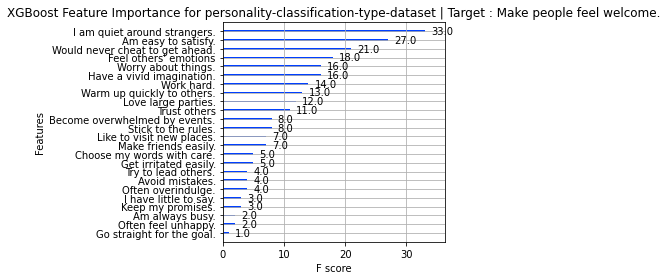

Target Variable: Take charge.
CATS=====================
['Make friends easily.', 'Have a vivid imagination.', 'Trust others', 'Get angry easily.', 'Love large parties.', 'Would never cheat to get ahead.', 'Like order.', 'Often feel unhappy.', 'Take charge.', 'Make people feel welcome.', 'Try to follow the rules.', 'Am easy to satisfy.', 'Go straight for the goal.', 'Often overindulge.', 'Avoid mistakes.', 'Warm up quickly to others.', 'Get irritated easily.', 'Stick to the rules.', 'Try to lead others.', 'Keep my promises.', "Feel others' emotions", 'Like to visit new places.', 'Work hard.', 'Choose my words with care.', 'I have little to say.']
CONTS=====================
['Worry about things.', 'Am always busy.', 'Panic easily.', 'Become overwhelmed by events.', 'I am quiet around strangers.']
30
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['Worry about things.', 'Am always busy.', 'Panic easily.', 'Become overwhelmed by events.', '

  0%|          | 0/42 [00:00<?, ?it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.014120101928710938}
{'Model': 'BaggingRegressor', 'R-Squared': 0.9986538461538461, 'Adjusted R-Squared': 1.0010937500000001, 'RMSE': 0.026726124191242463, 'Time taken': 0.02563953399658203}
{'Model': 'BayesianRidge', 'R-Squared': 0.9850418054926359, 'Adjusted R-Squared': 1.0121535330372333, 'RMSE': 0.0890898488447072, 'Time taken': 0.011414051055908203}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.01063084602355957}
{'Model': 'DummyRegressor', 'R-Squared': -0.11778846153846145, 'Adjusted R-Squared': 1.908203125, 'RMSE': 0.7701378090302795, 'Time taken': 0.01003575325012207}
{'Model': 'ElasticNet', 'R-Squared': 0.46119082475354845, 'Adjusted R-Squared': 1.4377824548877418, 'RMSE': 0.534695002827909, 'Time taken': 0.0106964111328125}


 17%|█▋        | 7/42 [00:00<00:00, 44.71it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.9974624127248293, 'Adjusted R-Squared': 1.0020617896610762, 'RMSE': 0.036694343987907024, 'Time taken': 0.07332801818847656}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.8653846153846154, 'Adjusted R-Squared': 1.109375, 'RMSE': 0.2672612419124244, 'Time taken': 0.011739730834960938}
{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.9951403846153846, 'Adjusted R-Squared': 1.0039484375, 'RMSE': 0.05077963596336062, 'Time taken': 0.10294699668884277}
{'Model': 'GammaRegressor', 'R-Squared': 0.9561386100892936, 'Adjusted R-Squared': 1.035637379302449, 'RMSE': 0.15255618822212577, 'Time taken': 0.014052867889404297}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -4.4819441275575995, 'Adjusted R-Squared': 5.454079603640549, 'RMSE': 1.705516543434429, 'Time taken': 0.013687372207641602}


 29%|██▊       | 12/42 [00:00<00:01, 29.85it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.9907587361367576, 'Adjusted R-Squared': 1.0075085268888844, 'RMSE': 0.07002519378173455, 'Time taken': 0.07749533653259277}
{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.9554710665203083, 'Adjusted R-Squared': 1.0361797584522494, 'RMSE': 0.15371271045873566, 'Time taken': 0.0835120677947998}


 38%|███▊      | 16/42 [00:00<00:00, 28.49it/s]

{'Model': 'HuberRegressor', 'R-Squared': 0.9995286355670537, 'Adjusted R-Squared': 1.0003829836017688, 'RMSE': 0.015814921432958283, 'Time taken': 0.04439854621887207}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.8115384615384615, 'Adjusted R-Squared': 1.153125, 'RMSE': 0.31622776601683794, 'Time taken': 0.011209249496459961}
{'Model': 'KernelRidge', 'R-Squared': -5.308707899354368, 'Adjusted R-Squared': 6.125825168225424, 'RMSE': 1.8296113414826412, 'Time taken': 0.010326385498046875}
{'Model': 'Lars', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 7.034695089393679e-15, 'Time taken': 0.011910676956176758}
{'Model': 'LarsCV', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 7.034695089393679e-15, 'Time taken': 0.016101360321044922}
{'Model': 'Lasso', 'R-Squared': -0.11778846153846145, 'Adjusted R-Squared': 1.908203125, 'RMSE': 0.7701378090302795, 'Time taken': 0.011689186096191406}


 48%|████▊     | 20/42 [00:00<00:00, 31.23it/s]

{'Model': 'LassoCV', 'R-Squared': 0.9999986649863719, 'Adjusted R-Squared': 1.0000010846985727, 'RMSE': 0.0008416499142561372, 'Time taken': 0.06352496147155762}
{'Model': 'LassoLars', 'R-Squared': -0.11778846153846145, 'Adjusted R-Squared': 1.908203125, 'RMSE': 0.7701378090302795, 'Time taken': 0.011684656143188477}
{'Model': 'LassoLarsCV', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 7.034695089393679e-15, 'Time taken': 0.01575946807861328}
{'Model': 'LassoLarsIC', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 7.034695089393679e-15, 'Time taken': 0.01150965690612793}
{'Model': 'LinearRegression', 'R-Squared': 0.985042735042735, 'Adjusted R-Squared': 1.012152777777778, 'RMSE': 0.08908708063747484, 'Time taken': 0.010261297225952148}
{'Model': 'LinearSVR', 'R-Squared': 0.9836839963088028, 'Adjusted R-Squared': 1.0132567529990977, 'RMSE': 0.09304553372596412, 'Time taken': 0.01719522476196289}


 62%|██████▏   | 26/42 [00:00<00:00, 34.53it/s]

{'Model': 'MLPRegressor', 'R-Squared': -0.3339591242760547, 'Adjusted R-Squared': 2.0838417884742944, 'RMSE': 0.8413174463508012, 'Time taken': 0.0807499885559082}
{'Model': 'NuSVR', 'R-Squared': 0.6727248535313725, 'Adjusted R-Squared': 1.2659110565057599, 'RMSE': 0.41672077002115804, 'Time taken': 0.011598825454711914}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.010605573654174805}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.014723062515258789}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.9583414558104766, 'Adjusted R-Squared': 1.0338475671539877, 'RMSE': 0.1486759350116349, 'Time taken': 0.01047825813293457}


 76%|███████▌  | 32/42 [00:00<00:00, 36.97it/s]

{'Model': 'PoissonRegressor', 'R-Squared': 0.9666330212280987, 'Adjusted R-Squared': 1.0271106702521697, 'RMSE': 0.1330598643905108, 'Time taken': 0.01295924186706543}
{'Model': 'QuantileRegressor', 'R-Squared': -0.34615384616514344, 'Adjusted R-Squared': 2.0937500000091793, 'RMSE': 0.845154254732063, 'Time taken': 0.08141589164733887}
{'Model': 'RANSACRegressor', 'R-Squared': 0.985042735042735, 'Adjusted R-Squared': 1.012152777777778, 'RMSE': 0.08908708063747489, 'Time taken': 0.04860210418701172}


 86%|████████▌ | 36/42 [00:01<00:00, 26.97it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.9951403846153846, 'Adjusted R-Squared': 1.0039484375, 'RMSE': 0.05077963596336062, 'Time taken': 0.18594765663146973}
{'Model': 'Ridge', 'R-Squared': 0.9965072110188693, 'Adjusted R-Squared': 1.0028378910471687, 'RMSE': 0.04305016378868525, 'Time taken': 0.012308120727539062}
{'Model': 'RidgeCV', 'R-Squared': 0.9877197018836749, 'Adjusted R-Squared': 1.0099777422195142, 'RMSE': 0.08072221845018533, 'Time taken': 0.011347532272338867}
{'Model': 'SGDRegressor', 'R-Squared': 0.9843444854244332, 'Adjusted R-Squared': 1.012720105592648, 'RMSE': 0.09114278761358045, 'Time taken': 0.013242244720458984}
{'Model': 'SVR', 'R-Squared': 0.6594898490751036, 'Adjusted R-Squared': 1.2766644976264785, 'RMSE': 0.42506335479879026, 'Time taken': 0.01080775260925293}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.985042735042735, 'Adjusted R-Squared': 1.012152777777778, 'RMSE': 0.08908708063747484, 'Time taken': 0.010956764221191406}
{'Model': 'Tw

100%|██████████| 42/42 [00:01<00:00, 25.70it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.9999999561052201, 'Adjusted R-Squared': 1.0000000356645087, 'RMSE': 0.00015261423, 'Time taken': 0.3585977554321289}
{'Model': 'LGBMRegressor', 'R-Squared': 0.9554710665203083, 'Adjusted R-Squared': 1.0361797584522494, 'RMSE': 0.15371271045873566, 'Time taken': 0.038574934005737305}
Project: personality-classification-type-dataset
personality-classification-type-dataset
Target: Take charge.
Take charge.
Target Standard Deviation: 0.7816453081514032
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
KernelRidge                                  6.13      -5.31  1.83        0.01
GaussianProcessRegressor                     5.45      -4.48  1.71        0.01
QuantileRegressor                            2.09      -0.35  0.85        0.08
MLPRegressor                                 2.08      -0.33  0.84        0.08
LassoLars                       

Better model found at epoch 0 with _rmse value: 1.482755422592163.
No improvement since epoch 0: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       3       3.00
1       1       1.00
2       3       3.00
3       1       1.00
4       1       1.00
XGBoost RMSE:  0.00015261423


<Figure size 432x288 with 0 Axes>

<Figure size 720x720 with 0 Axes>

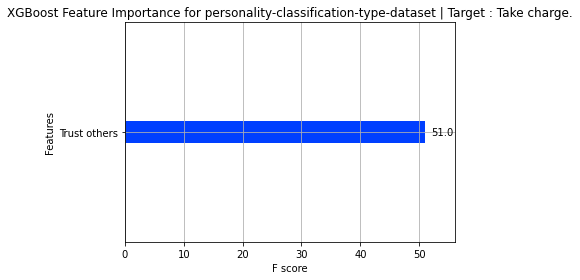

Target Variable: Often feel unhappy.
CATS=====================
['Make friends easily.', 'Have a vivid imagination.', 'Trust others', 'Get angry easily.', 'Love large parties.', 'Would never cheat to get ahead.', 'Like order.', 'Often feel unhappy.', 'Take charge.', 'Make people feel welcome.', 'Try to follow the rules.', 'Am easy to satisfy.', 'Go straight for the goal.', 'Often overindulge.', 'Avoid mistakes.', 'Warm up quickly to others.', 'Get irritated easily.', 'Stick to the rules.', 'Try to lead others.', 'Keep my promises.', "Feel others' emotions", 'Like to visit new places.', 'Work hard.', 'Choose my words with care.', 'I have little to say.']
CONTS=====================
['Worry about things.', 'Am always busy.', 'Panic easily.', 'Become overwhelmed by events.', 'I am quiet around strangers.']
30
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['Worry about things.', 'Am always busy.', 'Panic easily.', 'Become overwhelmed by even

  0%|          | 0/42 [00:00<?, ?it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.014621734619140625}
{'Model': 'BaggingRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.027246952056884766}
{'Model': 'BayesianRidge', 'R-Squared': 0.4615406616481411, 'Adjusted R-Squared': 1.4374982124108853, 'RMSE': 0.5345213918162206, 'Time taken': 0.012443065643310547}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.01077413558959961}
{'Model': 'DummyRegressor', 'R-Squared': -0.10156249999999978, 'Adjusted R-Squared': 1.8950195312499998, 'RMSE': 0.7645276653074159, 'Time taken': 0.009995460510253906}
{'Model': 'ElasticNet', 'R-Squared': 0.01822500008349237, 'Adjusted R-Squared': 1.7976921874321623, 'RMSE': 0.7217630059031787, 'Time taken': 0.010937690734863281}


 24%|██▍       | 10/42 [00:00<00:01, 21.38it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.9314358412840001, 'Adjusted R-Squared': 1.0557083789567498, 'RMSE': 0.19073799352996415, 'Time taken': 0.25761866569519043}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.010790586471557617}
{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.999125, 'Adjusted R-Squared': 1.0007109375, 'RMSE': 0.021547290184283377, 'Time taken': 0.10287189483642578}
{'Model': 'GammaRegressor', 'R-Squared': 0.6191010464753794, 'Adjusted R-Squared': 1.3094803997387543, 'RMSE': 0.4495660672348197, 'Time taken': 0.013344764709472656}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -10.587428753587268, 'Adjusted R-Squared': 10.414785862289655, 'RMSE': 2.4796031100835676, 'Time taken': 0.01934671401977539}


 43%|████▎     | 18/42 [00:00<00:00, 25.83it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.9999999992228389, 'Adjusted R-Squared': 1.0000000006314433, 'RMSE': 2.030692427914932e-05, 'Time taken': 0.08310294151306152}
{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.1997764628844878, 'Adjusted R-Squared': 1.6501816239063536, 'RMSE': 0.6516198335295261, 'Time taken': 0.0731344223022461}
{'Model': 'HuberRegressor', 'R-Squared': 0.44814572233589245, 'Adjusted R-Squared': 1.4483816006020873, 'RMSE': 0.5411290392576376, 'Time taken': 0.03949379920959473}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.8438461538461539, 'Adjusted R-Squared': 1.126875, 'RMSE': 0.28784916685156975, 'Time taken': 0.010681867599487305}
{'Model': 'KernelRidge', 'R-Squared': -8.53476156530676, 'Adjusted R-Squared': 8.746993771811741, 'RMSE': 2.249280160125501, 'Time taken': 0.010337352752685547}
{'Model': 'Lars', 'R-Squared': -25482.669716780845, 'Adjusted R-Squared': 20706.481644884436, 'RMSE': 116.28390772871036, 'Time taken': 0.01572179794

 50%|█████     | 21/42 [00:00<00:01, 20.30it/s]

{'Model': 'LassoLars', 'R-Squared': -0.10156249999999978, 'Adjusted R-Squared': 1.8950195312499998, 'RMSE': 0.7645276653074159, 'Time taken': 0.012791633605957031}
{'Model': 'LassoLarsCV', 'R-Squared': 0.8804354115458365, 'Adjusted R-Squared': 1.0971462281190079, 'RMSE': 0.2518778169866579, 'Time taken': 0.04788827896118164}
{'Model': 'LassoLarsIC', 'R-Squared': 0.4615384615490906, 'Adjusted R-Squared': 1.4374999999913638, 'RMSE': 0.5345224838195731, 'Time taken': 0.02200150489807129}
{'Model': 'LinearRegression', 'R-Squared': 0.46153846153846056, 'Adjusted R-Squared': 1.4375000000000009, 'RMSE': 0.5345224838248492, 'Time taken': 0.010874509811401367}
{'Model': 'LinearSVR', 'R-Squared': 0.8566220384675288, 'Adjusted R-Squared': 1.116494593745133, 'RMSE': 0.27582259160126416, 'Time taken': 0.01587533950805664}


 76%|███████▌  | 32/42 [00:01<00:00, 27.10it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.47201430740437267, 'Adjusted R-Squared': 1.4289883752339472, 'RMSE': 0.5292973395192627, 'Time taken': 0.10401582717895508}
{'Model': 'NuSVR', 'R-Squared': 0.8816658957927155, 'Adjusted R-Squared': 1.0961464596684187, 'RMSE': 0.25057838031525437, 'Time taken': 0.011764764785766602}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.7243773490613121, 'Adjusted R-Squared': 1.223943403887684, 'RMSE': 0.3824248338684398, 'Time taken': 0.010283946990966797}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.8854670404928234, 'Adjusted R-Squared': 1.0930580295995809, 'RMSE': 0.24652097427786956, 'Time taken': 0.015598535537719727}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.8710609268268737, 'Adjusted R-Squared': 1.1047629969531652, 'RMSE': 0.26156576815679594, 'Time taken': 0.010440587997436523}
{'Model': 'PoissonRegressor', 'R-Squared': 0.7512487561737607, 'Adjusted R-Squared': 1.2021103856088193, 'RMSE': 0.3633049076296664, 'Time

 83%|████████▎ | 35/42 [00:01<00:00, 21.03it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.9980211538461539, 'Adjusted R-Squared': 1.0016078125, 'RMSE': 0.032403703492039276, 'Time taken': 0.18412327766418457}
{'Model': 'Ridge', 'R-Squared': 0.9171080908810374, 'Adjusted R-Squared': 1.0673496761591572, 'RMSE': 0.20972234497423106, 'Time taken': 0.01166677474975586}
{'Model': 'RidgeCV', 'R-Squared': 0.9171080908810043, 'Adjusted R-Squared': 1.067349676159184, 'RMSE': 0.20972234497427292, 'Time taken': 0.013005971908569336}
{'Model': 'SGDRegressor', 'R-Squared': 0.8236474020498785, 'Adjusted R-Squared': 1.1432864858344738, 'RMSE': 0.3059000619351052, 'Time taken': 0.010850667953491211}
{'Model': 'SVR', 'R-Squared': 0.8498238061974659, 'Adjusted R-Squared': 1.122018157464559, 'RMSE': 0.28228589643089436, 'Time taken': 0.010399818420410156}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.46153846153846056, 'Adjusted R-Squared': 1.4375000000000009, 'RMSE': 0.5345224838248492, 'Time taken': 0.010857582092285156}
{'Model': 'T

100%|██████████| 42/42 [00:02<00:00, 20.59it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.9999999162658312, 'Adjusted R-Squared': 1.0000000680340122, 'RMSE': 0.00021078515, 'Time taken': 0.35526204109191895}
{'Model': 'LGBMRegressor', 'R-Squared': 0.1997764628844878, 'Adjusted R-Squared': 1.6501816239063536, 'RMSE': 0.6516198335295261, 'Time taken': 0.02648138999938965}
Project: personality-classification-type-dataset
personality-classification-type-dataset
Target: Often feel unhappy.
Often feel unhappy.
Target Standard Deviation: 0.7887522437627777
                               Adjusted R-Squared  R-Squared   RMSE  \
Model                                                                 
Lars                                     20706.48  -25482.67 116.28   
GaussianProcessRegressor                    10.41     -10.59   2.48   
KernelRidge                                  8.75      -8.53   2.25   
QuantileRegressor                            2.09      -0.35   0.85   
LassoLars                                    1.90      -0.10   0.76

Better model found at epoch 0 with _rmse value: 2.1572113037109375.
No improvement since epoch 0: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       2       2.00
1       2       2.00
2       3       3.00
3       2       2.00
4       3       3.00
XGBoost RMSE:  0.00021078515


<Figure size 432x288 with 0 Axes>

<Figure size 720x720 with 0 Axes>

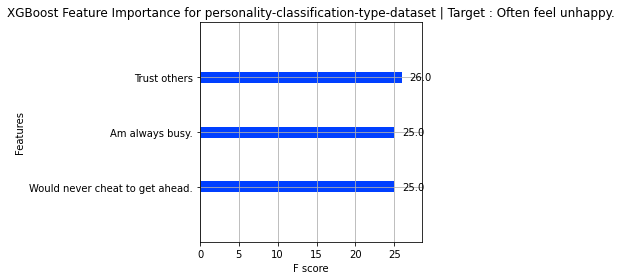

Target Variable: Like order.
CATS=====================
['Make friends easily.', 'Have a vivid imagination.', 'Trust others', 'Get angry easily.', 'Love large parties.', 'Would never cheat to get ahead.', 'Like order.', 'Often feel unhappy.', 'Take charge.', 'Make people feel welcome.', 'Try to follow the rules.', 'Am easy to satisfy.', 'Go straight for the goal.', 'Often overindulge.', 'Avoid mistakes.', 'Warm up quickly to others.', 'Get irritated easily.', 'Stick to the rules.', 'Try to lead others.', 'Keep my promises.', "Feel others' emotions", 'Like to visit new places.', 'Work hard.', 'Choose my words with care.', 'I have little to say.']
CONTS=====================
['Worry about things.', 'Am always busy.', 'Panic easily.', 'Become overwhelmed by events.', 'I am quiet around strangers.']
30
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['Worry about things.', 'Am always busy.', 'Panic easily.', 'Become overwhelmed by events.', 'I

  0%|          | 0/42 [00:00<?, ?it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.014082193374633789}
{'Model': 'BaggingRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.02752089500427246}
{'Model': 'BayesianRidge', 'R-Squared': 0.9999999999818865, 'Adjusted R-Squared': 1.0000000000147171, 'RMSE': 3.3852021405163876e-06, 'Time taken': 0.012024641036987305}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.01065516471862793}
{'Model': 'DummyRegressor', 'R-Squared': -0.008064516129032695, 'Adjusted R-Squared': 1.819052419354839, 'RMSE': 0.7985957062499249, 'Time taken': 0.010103464126586914}
{'Model': 'ElasticNet', 'R-Squared': 0.5046792322663927, 'Adjusted R-Squared': 1.402448123783556, 'RMSE': 0.5597912110731386, 'Time taken': 0.01093602180480957}


 17%|█▋        | 7/42 [00:00<00:00, 42.37it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.9999937904797125, 'Adjusted R-Squared': 1.0000050452352336, 'RMSE': 0.0019820373403654566, 'Time taken': 0.07942318916320801}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.012539863586425781}
{'Model': 'ExtraTreesRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.10713791847229004}
{'Model': 'GammaRegressor', 'R-Squared': 0.9691410244024297, 'Adjusted R-Squared': 1.025072917673026, 'RMSE': 0.1397248201933168, 'Time taken': 0.01410531997680664}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -4.475947846656693, 'Adjusted R-Squared': 5.449207625408563, 'RMSE': 1.8612832047523045, 'Time taken': 0.012639045715332031}


 29%|██▊       | 12/42 [00:00<00:01, 29.61it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.9999999992888025, 'Adjusted R-Squared': 1.000000000577848, 'RMSE': 2.1211819103729174e-05, 'Time taken': 0.07063078880310059}
{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.9626041224569659, 'Adjusted R-Squared': 1.0303841505037152, 'RMSE': 0.15381357678949117, 'Time taken': 0.09130167961120605}


 38%|███▊      | 16/42 [00:00<00:00, 27.92it/s]

{'Model': 'HuberRegressor', 'R-Squared': 0.9998469982787123, 'Adjusted R-Squared': 1.0001243138985463, 'RMSE': 0.009838547013929534, 'Time taken': 0.04198145866394043}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.9548387096774194, 'Adjusted R-Squared': 1.0366935483870967, 'RMSE': 0.16903085094570328, 'Time taken': 0.011350154876708984}
{'Model': 'KernelRidge', 'R-Squared': -4.0528981170178096, 'Adjusted R-Squared': 5.10547972007697, 'RMSE': 1.7879405643887543, 'Time taken': 0.011017084121704102}
{'Model': 'Lars', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 4.566625262115111e-14, 'Time taken': 0.01154184341430664}
{'Model': 'LarsCV', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 4.566625262115111e-14, 'Time taken': 0.01633453369140625}
{'Model': 'Lasso', 'R-Squared': -0.008064516129032695, 'Adjusted R-Squared': 1.819052419354839, 'RMSE': 0.7985957062499249, 'Time taken': 0.010925531387329102}


 48%|████▊     | 20/42 [00:00<00:00, 30.62it/s]

{'Model': 'LassoCV', 'R-Squared': 0.9999989568318055, 'Adjusted R-Squared': 1.000000847574158, 'RMSE': 0.0008123814077089518, 'Time taken': 0.06592941284179688}
{'Model': 'LassoLars', 'R-Squared': -0.008064516129032695, 'Adjusted R-Squared': 1.819052419354839, 'RMSE': 0.7985957062499249, 'Time taken': 0.01201486587524414}
{'Model': 'LassoLarsCV', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 4.566625262115111e-14, 'Time taken': 0.015564918518066406}
{'Model': 'LassoLarsIC', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 4.566625262115111e-14, 'Time taken': 0.011464834213256836}
{'Model': 'LinearRegression', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 1.2937109987328497e-15, 'Time taken': 0.010215282440185547}
{'Model': 'LinearSVR', 'R-Squared': 0.9999786182831313, 'Adjusted R-Squared': 1.000017372644956, 'RMSE': 0.0036779353761619074, 'Time taken': 0.01738572120666504}


 62%|██████▏   | 26/42 [00:00<00:00, 33.65it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.7833847589514942, 'Adjusted R-Squared': 1.175999883351911, 'RMSE': 0.3701922410818708, 'Time taken': 0.08613848686218262}
{'Model': 'NuSVR', 'R-Squared': 0.9650342393288838, 'Adjusted R-Squared': 1.028409680545282, 'RMSE': 0.14873195865927583, 'Time taken': 0.01269674301147461}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 7.506477703676109e-16, 'Time taken': 0.010914802551269531}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 7.506477703676109e-16, 'Time taken': 0.01513361930847168}


 76%|███████▌  | 32/42 [00:00<00:00, 34.48it/s]

{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.9876249000641771, 'Adjusted R-Squared': 1.010054768697856, 'RMSE': 0.08848245508210834, 'Time taken': 0.012414216995239258}
{'Model': 'PoissonRegressor', 'R-Squared': 0.9817212893715722, 'Adjusted R-Squared': 1.0148514523855976, 'RMSE': 0.10753642282646116, 'Time taken': 0.01442575454711914}
{'Model': 'QuantileRegressor', 'R-Squared': -0.12903225806671315, 'Adjusted R-Squared': 1.9173387096792043, 'RMSE': 0.8451542547293388, 'Time taken': 0.09952187538146973}
{'Model': 'RANSACRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 8.1368279342167e-16, 'Time taken': 0.02816009521484375}


 86%|████████▌ | 36/42 [00:01<00:00, 27.01it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.18414020538330078}
{'Model': 'Ridge', 'R-Squared': 0.9995998991060483, 'Adjusted R-Squared': 1.0003250819763359, 'RMSE': 0.015909904316406157, 'Time taken': 0.011214971542358398}
{'Model': 'RidgeCV', 'R-Squared': 0.9995998991060482, 'Adjusted R-Squared': 1.0003250819763359, 'RMSE': 0.015909904316408936, 'Time taken': 0.011211872100830078}
{'Model': 'SGDRegressor', 'R-Squared': 0.9938130828337437, 'Adjusted R-Squared': 1.0050268701975833, 'RMSE': 0.06256334457791071, 'Time taken': 0.012019157409667969}
{'Model': 'SVR', 'R-Squared': 0.9460626404187206, 'Adjusted R-Squared': 1.0438241046597896, 'RMSE': 0.18472583916026064, 'Time taken': 0.011333227157592773}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 1.2937109987328497e-15, 'Time taken': 0.011049032211303711}
{'Model': 'TweedieRegressor', 'R-Squared': 0.9692187115541627, 'Adjusted R

100%|██████████| 42/42 [00:01<00:00, 25.41it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.9999999708460939, 'Adjusted R-Squared': 1.0000000236875486, 'RMSE': 0.00013580982, 'Time taken': 0.3608517646789551}
{'Model': 'LGBMRegressor', 'R-Squared': 0.9626041224569659, 'Adjusted R-Squared': 1.0303841505037152, 'RMSE': 0.15381357678949117, 'Time taken': 0.03199052810668945}
Project: personality-classification-type-dataset
personality-classification-type-dataset
Target: Like order.
Like order.
Target Standard Deviation: 0.7726181304565691
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
GaussianProcessRegressor                     5.45      -4.48  1.86        0.01
KernelRidge                                  5.11      -4.05  1.79        0.01
QuantileRegressor                            1.92      -0.13  0.85        0.10
DummyRegressor                               1.82      -0.01  0.80        0.01
LassoLars                          

Better model found at epoch 0 with _rmse value: 3.861851215362549.
No improvement since epoch 0: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       3       3.00
1       3       3.00
2       1       1.00
3       2       2.00
4       1       1.00
XGBoost RMSE:  0.00013580982


<Figure size 432x288 with 0 Axes>

<Figure size 720x720 with 0 Axes>

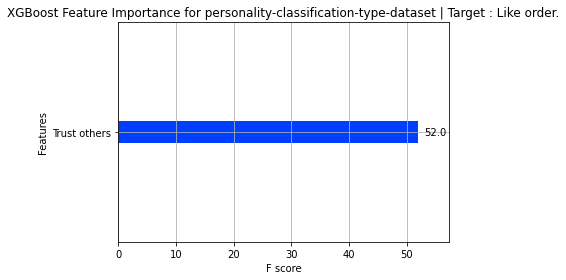

Target Variable: Would never cheat to get ahead.
CATS=====================
['Make friends easily.', 'Have a vivid imagination.', 'Trust others', 'Get angry easily.', 'Love large parties.', 'Would never cheat to get ahead.', 'Like order.', 'Often feel unhappy.', 'Take charge.', 'Make people feel welcome.', 'Try to follow the rules.', 'Am easy to satisfy.', 'Go straight for the goal.', 'Often overindulge.', 'Avoid mistakes.', 'Warm up quickly to others.', 'Get irritated easily.', 'Stick to the rules.', 'Try to lead others.', 'Keep my promises.', "Feel others' emotions", 'Like to visit new places.', 'Work hard.', 'Choose my words with care.', 'I have little to say.']
CONTS=====================
['Worry about things.', 'Am always busy.', 'Panic easily.', 'Become overwhelmed by events.', 'I am quiet around strangers.']
30
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['Worry about things.', 'Am always busy.', 'Panic easily.', 'Become overwhe

 14%|█▍        | 6/42 [00:00<00:00, 54.68it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.036622047424316406}
{'Model': 'BaggingRegressor', 'R-Squared': 0.9345454545454546, 'Adjusted R-Squared': 1.0531818181818182, 'RMSE': 0.1603567451474546, 'Time taken': 0.028209447860717773}
{'Model': 'BayesianRidge', 'R-Squared': 0.8015236864151767, 'Adjusted R-Squared': 1.161262004787669, 'RMSE': 0.2792361679291421, 'Time taken': 0.012499094009399414}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.010957002639770508}
{'Model': 'DummyRegressor', 'R-Squared': -0.0032467532467534976, 'Adjusted R-Squared': 1.8151379870129873, 'RMSE': 0.6277998511159624, 'Time taken': 0.01011514663696289}
{'Model': 'ElasticNet', 'R-Squared': -0.0032467532467534976, 'Adjusted R-Squared': 1.8151379870129873, 'RMSE': 0.6277998511159624, 'Time taken': 0.010951042175292969}
{'Model': 'ElasticNetCV', 'R-Squared': 0.8425139442246592, 'Adjusted R-Squa

 38%|███▊      | 16/42 [00:00<00:01, 25.08it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.991750414248322, 'Adjusted R-Squared': 1.0067027884232385, 'RMSE': 0.05692897933530165, 'Time taken': 0.08813762664794922}
{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.6418113502556326, 'Adjusted R-Squared': 1.2910282779172984, 'RMSE': 0.375122606013594, 'Time taken': 0.07124209403991699}
{'Model': 'HuberRegressor', 'R-Squared': 0.8180714178249358, 'Adjusted R-Squared': 1.1478169730172396, 'RMSE': 0.2673423703742949, 'Time taken': 0.03837299346923828}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.7890909090909092, 'Adjusted R-Squared': 1.1713636363636364, 'RMSE': 0.28784916685156975, 'Time taken': 0.010298967361450195}
{'Model': 'KernelRidge', 'R-Squared': -5.277952432229943, 'Adjusted R-Squared': 6.100836351186829, 'RMSE': 1.5704580400376529, 'Time taken': 0.01010751724243164}
{'Model': 'Lars', 'R-Squared': -8623.848938494375, 'Adjusted R-Squared': 7008.689762526679, 'RMSE': 58.209393671050734, 'Time taken': 0.014850

 48%|████▊     | 20/42 [00:00<00:00, 22.25it/s]

{'Model': 'Lasso', 'R-Squared': -0.0032467532467534976, 'Adjusted R-Squared': 1.8151379870129873, 'RMSE': 0.6277998511159624, 'Time taken': 0.01233363151550293}
{'Model': 'LassoCV', 'R-Squared': 0.8472839473174543, 'Adjusted R-Squared': 1.1240817928045683, 'RMSE': 0.24493997657647845, 'Time taken': 0.14828062057495117}
{'Model': 'LassoLars', 'R-Squared': -0.0032467532467534976, 'Adjusted R-Squared': 1.8151379870129873, 'RMSE': 0.6277998511159624, 'Time taken': 0.0123291015625}
{'Model': 'LassoLarsCV', 'R-Squared': 0.8561380362171616, 'Adjusted R-Squared': 1.1168878455735562, 'RMSE': 0.23773346431990533, 'Time taken': 0.04267430305480957}


 69%|██████▉   | 29/42 [00:01<00:00, 28.42it/s]

{'Model': 'LassoLarsIC', 'R-Squared': 0.8582722077888579, 'Adjusted R-Squared': 1.115153831171553, 'RMSE': 0.23596350461781182, 'Time taken': 0.019663333892822266}
{'Model': 'LinearRegression', 'R-Squared': 0.8573855430111268, 'Adjusted R-Squared': 1.1158742463034594, 'RMSE': 0.23670046071516557, 'Time taken': 0.01183462142944336}
{'Model': 'LinearSVR', 'R-Squared': 0.8181611078779695, 'Adjusted R-Squared': 1.1477440998491497, 'RMSE': 0.267276462898193, 'Time taken': 0.01604747772216797}
{'Model': 'MLPRegressor', 'R-Squared': 0.7269078040337924, 'Adjusted R-Squared': 1.2218874092225436, 'RMSE': 0.3275457522909849, 'Time taken': 0.0941929817199707}
{'Model': 'NuSVR', 'R-Squared': 0.748905815964561, 'Adjusted R-Squared': 1.2040140245287942, 'RMSE': 0.3140766526315004, 'Time taken': 0.012018918991088867}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.6078204545279673, 'Adjusted R-Squared': 1.3186458806960266, 'RMSE': 0.39251819794903225, 'Time taken': 0.010691165924072266}
{'Model'

 79%|███████▊  | 33/42 [00:01<00:00, 23.67it/s]

{'Model': 'QuantileRegressor', 'R-Squared': -0.0014186416994452777, 'Adjusted R-Squared': 1.8136526463807994, 'RMSE': 0.6272276033322552, 'Time taken': 0.1505131721496582}
{'Model': 'RANSACRegressor', 'R-Squared': 0.8181818181818178, 'Adjusted R-Squared': 1.147727272727273, 'RMSE': 0.2672612419124247, 'Time taken': 0.05885910987854004}


 86%|████████▌ | 36/42 [00:01<00:00, 21.08it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.9698909090909091, 'Adjusted R-Squared': 1.0244636363636364, 'RMSE': 0.10875923606099588, 'Time taken': 0.16113901138305664}
{'Model': 'Ridge', 'R-Squared': 0.834358222634384, 'Adjusted R-Squared': 1.134583944109563, 'RMSE': 0.25509518888766763, 'Time taken': 0.012203693389892578}
{'Model': 'RidgeCV', 'R-Squared': 0.8343582226343611, 'Adjusted R-Squared': 1.1345839441095815, 'RMSE': 0.25509518888768534, 'Time taken': 0.01128530502319336}
{'Model': 'SGDRegressor', 'R-Squared': 0.7770651234634443, 'Adjusted R-Squared': 1.1811345871859515, 'RMSE': 0.29594181630746474, 'Time taken': 0.013037443161010742}
{'Model': 'SVR', 'R-Squared': 0.7520403573333223, 'Adjusted R-Squared': 1.2014672096666756, 'RMSE': 0.3121101035883156, 'Time taken': 0.010933399200439453}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.8573855430111268, 'Adjusted R-Squared': 1.1158742463034594, 'RMSE': 0.23670046071516557, 'Time taken': 0.011180877685546875}
{'Model

100%|██████████| 42/42 [00:01<00:00, 21.56it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.9947593333607704, 'Adjusted R-Squared': 1.004258041644374, 'RMSE': 0.045374367, 'Time taken': 0.36215758323669434}
{'Model': 'LGBMRegressor', 'R-Squared': 0.6418113502556326, 'Adjusted R-Squared': 1.2910282779172984, 'RMSE': 0.375122606013594, 'Time taken': 0.04125332832336426}
Project: personality-classification-type-dataset
personality-classification-type-dataset
Target: Would never cheat to get ahead.
Would never cheat to get ahead.
Target Standard Deviation: 0.5658206970626735
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
Lars                                      7008.69   -8623.85 58.21        0.01
KernelRidge                                  6.10      -5.28  1.57        0.01
GaussianProcessRegressor                     6.08      -5.25  1.57        0.01
LassoLars                                    1.82      -0.00  0.63        0.01

Better model found at epoch 0 with _rmse value: 1.7869523763656616.
No improvement since epoch 0: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       1       1.01
1       2       1.93
2       1       1.00
3       1       1.02
4       3       2.85
XGBoost RMSE:  0.045374367


<Figure size 432x288 with 0 Axes>

<Figure size 720x720 with 0 Axes>

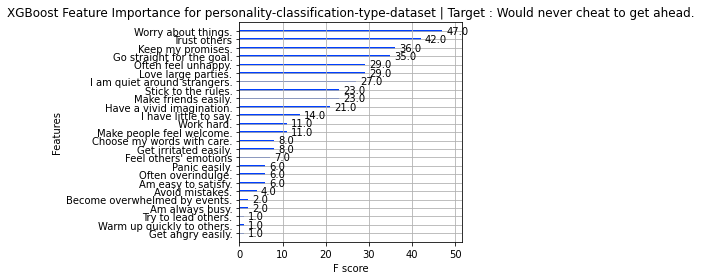

Target Variable: Love large parties.
CATS=====================
['Make friends easily.', 'Have a vivid imagination.', 'Trust others', 'Get angry easily.', 'Love large parties.', 'Would never cheat to get ahead.', 'Like order.', 'Often feel unhappy.', 'Take charge.', 'Make people feel welcome.', 'Try to follow the rules.', 'Am easy to satisfy.', 'Go straight for the goal.', 'Often overindulge.', 'Avoid mistakes.', 'Warm up quickly to others.', 'Get irritated easily.', 'Stick to the rules.', 'Try to lead others.', 'Keep my promises.', "Feel others' emotions", 'Like to visit new places.', 'Work hard.', 'Choose my words with care.', 'I have little to say.']
CONTS=====================
['Worry about things.', 'Am always busy.', 'Panic easily.', 'Become overwhelmed by events.', 'I am quiet around strangers.']
30
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['Worry about things.', 'Am always busy.', 'Panic easily.', 'Become overwhelmed by even

  0%|          | 0/42 [00:00<?, ?it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.013750791549682617}
{'Model': 'BaggingRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.026235580444335938}
{'Model': 'BayesianRidge', 'R-Squared': 0.9839728827919546, 'Adjusted R-Squared': 1.013022032731537, 'RMSE': 0.05790173790745294, 'Time taken': 0.011862754821777344}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.011107921600341797}
{'Model': 'DummyRegressor', 'R-Squared': -0.013719512195121686, 'Adjusted R-Squared': 1.8236471036585362, 'RMSE': 0.46049274850812955, 'Time taken': 0.00993204116821289}
{'Model': 'ElasticNet', 'R-Squared': 0.2870302910523179, 'Adjusted R-Squared': 1.5792878885199917, 'RMSE': 0.38618858448959414, 'Time taken': 0.010774850845336914}


 17%|█▋        | 7/42 [00:00<00:00, 35.01it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.6519026278728662, 'Adjusted R-Squared': 1.2828291148532962, 'RMSE': 0.26984493144506966, 'Time taken': 0.11555719375610352}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.014136075973510742}


 26%|██▌       | 11/42 [00:00<00:00, 31.02it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.10484933853149414}
{'Model': 'GammaRegressor', 'R-Squared': 0.5670545578392192, 'Adjusted R-Squared': 1.3517681717556345, 'RMSE': 0.30094038945116774, 'Time taken': 0.013445377349853516}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -19.655107115072713, 'Adjusted R-Squared': 17.78227453099658, 'RMSE': 2.078632045898119, 'Time taken': 0.013134956359863281}
{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.9999999992848129, 'Adjusted R-Squared': 1.0000000005810896, 'RMSE': 1.2231331578053202e-05, 'Time taken': 0.08903145790100098}
{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.6364778984040498, 'Adjusted R-Squared': 1.2953617075467094, 'RMSE': 0.27575875072090256, 'Time taken': 0.07664132118225098}


 36%|███▌      | 15/42 [00:00<00:01, 24.25it/s]

{'Model': 'HuberRegressor', 'R-Squared': 0.9860911099850128, 'Adjusted R-Squared': 1.0113009731371772, 'RMSE': 0.05393989902861069, 'Time taken': 0.04216885566711426}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.4536585365853659, 'Adjusted R-Squared': 1.4439024390243902, 'RMSE': 0.33806170189140666, 'Time taken': 0.011148691177368164}
{'Model': 'KernelRidge', 'R-Squared': -20.649635818722928, 'Adjusted R-Squared': 18.590329102712378, 'RMSE': 2.1280860766977683, 'Time taken': 0.012509584426879883}
{'Model': 'Lars', 'R-Squared': -47.32038973943987, 'Adjusted R-Squared': 40.260316663294894, 'RMSE': 3.1792824078978175, 'Time taken': 0.015501022338867188}
{'Model': 'LarsCV', 'R-Squared': 0.5439749196416956, 'Adjusted R-Squared': 1.3705203777911223, 'RMSE': 0.30885757478734893, 'Time taken': 0.036657094955444336}


 48%|████▊     | 20/42 [00:00<00:00, 25.19it/s]

{'Model': 'Lasso', 'R-Squared': -0.013719512195121686, 'Adjusted R-Squared': 1.8236471036585362, 'RMSE': 0.46049274850812955, 'Time taken': 0.01270437240600586}
{'Model': 'LassoCV', 'R-Squared': 0.5387949720522641, 'Adjusted R-Squared': 1.3747290852075353, 'RMSE': 0.31060676420300165, 'Time taken': 0.10859107971191406}
{'Model': 'LassoLars', 'R-Squared': -0.013719512195121686, 'Adjusted R-Squared': 1.8236471036585362, 'RMSE': 0.46049274850812955, 'Time taken': 0.014948844909667969}
{'Model': 'LassoLarsCV', 'R-Squared': 0.5439749196416956, 'Adjusted R-Squared': 1.3705203777911223, 'RMSE': 0.30885757478734893, 'Time taken': 0.037328243255615234}
{'Model': 'LassoLarsIC', 'R-Squared': 0.98201603864225, 'Adjusted R-Squared': 1.0146119686031718, 'RMSE': 0.06133474627277489, 'Time taken': 0.0172576904296875}
{'Model': 'LinearRegression', 'R-Squared': 0.9846729785157662, 'Adjusted R-Squared': 1.01245320495594, 'RMSE': 0.05662298700542262, 'Time taken': 0.011141300201416016}
{'Model': 'LinearSV

 62%|██████▏   | 26/42 [00:00<00:00, 27.84it/s]

{'Model': 'MLPRegressor', 'R-Squared': -0.32690563663264616, 'Adjusted R-Squared': 2.078110829764025, 'RMSE': 0.5268462730418177, 'Time taken': 0.08714461326599121}
{'Model': 'NuSVR', 'R-Squared': 0.7574470632434427, 'Adjusted R-Squared': 1.197074261114703, 'RMSE': 0.22525122490571448, 'Time taken': 0.012310981750488281}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.4977877459195791, 'Adjusted R-Squared': 1.408047456440342, 'RMSE': 0.3241212800324656, 'Time taken': 0.011152505874633789}


 76%|███████▌  | 32/42 [00:01<00:00, 32.21it/s]

{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.43683481136585556, 'Adjusted R-Squared': 1.4575717157652424, 'RMSE': 0.3432272759099589, 'Time taken': 0.01853799819946289}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.9341251447376795, 'Adjusted R-Squared': 1.0535233199006355, 'RMSE': 0.11738800710905874, 'Time taken': 0.011746644973754883}
{'Model': 'PoissonRegressor', 'R-Squared': 0.6758190765662134, 'Adjusted R-Squared': 1.2633970002899515, 'RMSE': 0.26040997759797496, 'Time taken': 0.012788534164428711}
{'Model': 'QuantileRegressor', 'R-Squared': -0.024390243897829844, 'Adjusted R-Squared': 1.8323170731669869, 'RMSE': 0.4629100498852344, 'Time taken': 0.06873703002929688}
{'Model': 'RANSACRegressor', 'R-Squared': 0.9846729785157661, 'Adjusted R-Squared': 1.01245320495594, 'RMSE': 0.0566229870054228, 'Time taken': 0.02995610237121582}


 86%|████████▌ | 36/42 [00:01<00:00, 25.94it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.9996243902439025, 'Adjusted R-Squared': 1.0003051829268292, 'RMSE': 0.008864052604279192, 'Time taken': 0.18244314193725586}
{'Model': 'Ridge', 'R-Squared': 0.9466426730429436, 'Adjusted R-Squared': 1.0433528281526083, 'RMSE': 0.10564791365372178, 'Time taken': 0.012466907501220703}
{'Model': 'RidgeCV', 'R-Squared': 0.9796644389477078, 'Adjusted R-Squared': 1.0165226433549874, 'RMSE': 0.06522167862742793, 'Time taken': 0.011517763137817383}
{'Model': 'SGDRegressor', 'R-Squared': 0.8123923841915883, 'Adjusted R-Squared': 1.1524311878443345, 'RMSE': 0.1981021207499737, 'Time taken': 0.013473272323608398}
{'Model': 'SVR', 'R-Squared': 0.7387281330586166, 'Adjusted R-Squared': 1.212283391889874, 'RMSE': 0.23378154097576584, 'Time taken': 0.011537551879882812}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.9846729785157662, 'Adjusted R-Squared': 1.01245320495594, 'RMSE': 0.05662298700542262, 'Time taken': 0.011651277542114258}
{'Mode

100%|██████████| 42/42 [00:01<00:00, 23.82it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.9999999557683584, 'Adjusted R-Squared': 1.0000000359382089, 'RMSE': 9.619011e-05, 'Time taken': 0.35378146171569824}
{'Model': 'LGBMRegressor', 'R-Squared': 0.6364778984040498, 'Adjusted R-Squared': 1.2953617075467094, 'RMSE': 0.27575875072090256, 'Time taken': 0.04193925857543945}
Project: personality-classification-type-dataset
personality-classification-type-dataset
Target: Love large parties.
Love large parties.
Target Standard Deviation: 0.708683386892301
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
Lars                                        40.26     -47.32  3.18        0.02
KernelRidge                                 18.59     -20.65  2.13        0.01
GaussianProcessRegressor                    17.78     -19.66  2.08        0.01
MLPRegressor                                 2.08      -0.33  0.53        0.09
QuantileRegressor   

Better model found at epoch 0 with _rmse value: 4.862521171569824.
No improvement since epoch 0: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       2       2.00
1       2       2.00
2       2       2.00
3       1       1.00
4       2       2.00
XGBoost RMSE:  9.619011e-05


<Figure size 432x288 with 0 Axes>

<Figure size 720x720 with 0 Axes>

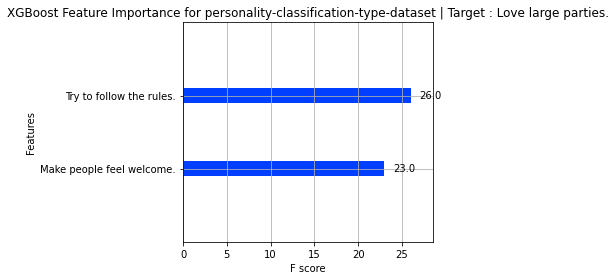

Target Variable: Get angry easily.
CATS=====================
['Make friends easily.', 'Have a vivid imagination.', 'Trust others', 'Get angry easily.', 'Love large parties.', 'Would never cheat to get ahead.', 'Like order.', 'Often feel unhappy.', 'Take charge.', 'Make people feel welcome.', 'Try to follow the rules.', 'Am easy to satisfy.', 'Go straight for the goal.', 'Often overindulge.', 'Avoid mistakes.', 'Warm up quickly to others.', 'Get irritated easily.', 'Stick to the rules.', 'Try to lead others.', 'Keep my promises.', "Feel others' emotions", 'Like to visit new places.', 'Work hard.', 'Choose my words with care.', 'I have little to say.']
CONTS=====================
['Worry about things.', 'Am always busy.', 'Panic easily.', 'Become overwhelmed by events.', 'I am quiet around strangers.']
30
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['Worry about things.', 'Am always busy.', 'Panic easily.', 'Become overwhelmed by events

  5%|▍         | 2/42 [00:00<00:02, 19.16it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.9571648595460414, 'Adjusted R-Squared': 1.0348035516188414, 'RMSE': 0.1288780208478445, 'Time taken': 0.07733821868896484}
{'Model': 'BaggingRegressor', 'R-Squared': 0.9926315789473684, 'Adjusted R-Squared': 1.0059868421052631, 'RMSE': 0.053452248382484926, 'Time taken': 0.026888370513916016}
{'Model': 'BayesianRidge', 'R-Squared': 0.832145162350041, 'Adjusted R-Squared': 1.1363820555905917, 'RMSE': 0.2551206963399962, 'Time taken': 0.01324462890625}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.011651754379272461}
{'Model': 'DummyRegressor', 'R-Squared': -0.013157894736841813, 'Adjusted R-Squared': 1.823190789473684, 'RMSE': 0.6267831705280087, 'Time taken': 0.010078668594360352}
{'Model': 'ElasticNet', 'R-Squared': 0.04093124979492291, 'Adjusted R-Squared': 1.779243359541625, 'RMSE': 0.6098227620382236, 'Time taken': 0.010524511337280273}


 17%|█▋        | 7/42 [00:00<00:01, 24.60it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.7316516195370143, 'Adjusted R-Squared': 1.2180330591261759, 'RMSE': 0.32257317564997995, 'Time taken': 0.14026975631713867}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.01112675666809082}


 24%|██▍       | 10/42 [00:00<00:01, 23.95it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.9623842105263157, 'Adjusted R-Squared': 1.0305628289473685, 'RMSE': 0.12077133056199346, 'Time taken': 0.10447287559509277}
{'Model': 'GammaRegressor', 'R-Squared': 0.8098098873489632, 'Adjusted R-Squared': 1.1545294665289674, 'RMSE': 0.27156433222748, 'Time taken': 0.01344156265258789}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -6.210863349063348, 'Adjusted R-Squared': 6.85882647111397, 'RMSE': 1.6721390653048094, 'Time taken': 0.013764619827270508}
{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.9572888616841817, 'Adjusted R-Squared': 1.0347027998816023, 'RMSE': 0.12869134312738195, 'Time taken': 0.08748030662536621}


 43%|████▎     | 18/42 [00:00<00:01, 20.80it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.8676116949581857, 'Adjusted R-Squared': 1.1075654978464742, 'RMSE': 0.22657060870840998, 'Time taken': 0.23394131660461426}
{'Model': 'HuberRegressor', 'R-Squared': 0.6057508844393896, 'Adjusted R-Squared': 1.320327406392996, 'RMSE': 0.3909886264761496, 'Time taken': 0.040418148040771484}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.7936842105263158, 'Adjusted R-Squared': 1.1676315789473684, 'RMSE': 0.282842712474619, 'Time taken': 0.013833999633789062}
{'Model': 'KernelRidge', 'R-Squared': -6.341200522956197, 'Adjusted R-Squared': 6.964725424901911, 'RMSE': 1.6871834393097196, 'Time taken': 0.014632701873779297}
{'Model': 'Lars', 'R-Squared': -585.8770945174982, 'Adjusted R-Squared': 477.8376392954673, 'RMSE': 15.085244037470867, 'Time taken': 0.015763282775878906}
{'Model': 'LarsCV', 'R-Squared': 0.8834741896454861, 'Adjusted R-Squared': 1.0946772209130426, 'RMSE': 0.21256405501496092, 'Time taken': 0.04035496711730957}
{'M

 57%|█████▋    | 24/42 [00:01<00:00, 22.60it/s]

{'Model': 'LassoCV', 'R-Squared': 0.8341195197839028, 'Adjusted R-Squared': 1.134777890175579, 'RMSE': 0.25361585623295, 'Time taken': 0.11540842056274414}
{'Model': 'LassoLars', 'R-Squared': -0.013157894736841813, 'Adjusted R-Squared': 1.823190789473684, 'RMSE': 0.6267831705280087, 'Time taken': 0.010719060897827148}
{'Model': 'LassoLarsCV', 'R-Squared': 0.8532018632390261, 'Adjusted R-Squared': 1.1192734861182914, 'RMSE': 0.23858274560234474, 'Time taken': 0.057024240493774414}
{'Model': 'LassoLarsIC', 'R-Squared': 0.8360343882596944, 'Adjusted R-Squared': 1.1332220595389983, 'RMSE': 0.2521477791128588, 'Time taken': 0.03252720832824707}
{'Model': 'LinearRegression', 'R-Squared': 0.6418878840374966, 'Adjusted R-Squared': 1.290966094219534, 'RMSE': 0.3726389674565626, 'Time taken': 0.016213417053222656}
{'Model': 'LinearSVR', 'R-Squared': 0.44350752698895324, 'Adjusted R-Squared': 1.4521501343214755, 'RMSE': 0.4645242681037716, 'Time taken': 0.020894527435302734}


 64%|██████▍   | 27/42 [00:01<00:00, 22.38it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.4094313791509703, 'Adjusted R-Squared': 1.4798370044398368, 'RMSE': 0.4785352608109665, 'Time taken': 0.1016535758972168}
{'Model': 'NuSVR', 'R-Squared': 0.884700378823128, 'Adjusted R-Squared': 1.0936809422062086, 'RMSE': 0.21144270234440693, 'Time taken': 0.012800216674804688}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.8585760162462606, 'Adjusted R-Squared': 1.1149069867999133, 'RMSE': 0.23417487322821381, 'Time taken': 0.012246131896972656}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.9503519754033345, 'Adjusted R-Squared': 1.0403390199847906, 'RMSE': 0.13874896339650616, 'Time taken': 0.015983104705810547}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.831841015757786, 'Adjusted R-Squared': 1.136629174696799, 'RMSE': 0.2553517262403365, 'Time taken': 0.011312246322631836}
{'Model': 'PoissonRegressor', 'R-Squared': 0.8454265313736826, 'Adjusted R-Squared': 1.1255909432588829, 'RMSE': 0.24481962972768467, 'Time ta

 76%|███████▌  | 32/42 [00:01<00:00, 21.48it/s]

{'Model': 'QuantileRegressor', 'R-Squared': -0.4736842103251966, 'Adjusted R-Squared': 2.197368420889222, 'RMSE': 0.7559289459668722, 'Time taken': 0.19296693801879883}
{'Model': 'RANSACRegressor', 'R-Squared': 0.16817434210526383, 'Adjusted R-Squared': 1.675858347039473, 'RMSE': 0.5679301390639017, 'Time taken': 0.07522296905517578}


 83%|████████▎ | 35/42 [00:01<00:00, 17.77it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.9772315789473685, 'Adjusted R-Squared': 1.018499342105263, 'RMSE': 0.0939604780137448, 'Time taken': 0.1605391502380371}
{'Model': 'Ridge', 'R-Squared': 0.7944438807635619, 'Adjusted R-Squared': 1.167014346879606, 'RMSE': 0.28232150819524765, 'Time taken': 0.012362241744995117}
{'Model': 'RidgeCV', 'R-Squared': 0.7074049878998907, 'Adjusted R-Squared': 1.2377334473313388, 'RMSE': 0.33683112797589204, 'Time taken': 0.013849496841430664}
{'Model': 'SGDRegressor', 'R-Squared': 0.8736399808392572, 'Adjusted R-Squared': 1.1026675155681036, 'RMSE': 0.2213520772966753, 'Time taken': 0.010899543762207031}
{'Model': 'SVR', 'R-Squared': 0.8439131996257301, 'Adjusted R-Squared': 1.1268205253040944, 'RMSE': 0.2460151483269873, 'Time taken': 0.01086735725402832}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.6418878840374966, 'Adjusted R-Squared': 1.290966094219534, 'RMSE': 0.3726389674565626, 'Time taken': 0.011252164840698242}
{'Model': 'T

100%|██████████| 42/42 [00:02<00:00, 18.66it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.9602423196239297, 'Adjusted R-Squared': 1.032303115305557, 'RMSE': 0.12416217, 'Time taken': 0.37621569633483887}
{'Model': 'LGBMRegressor', 'R-Squared': 0.8676116949581857, 'Adjusted R-Squared': 1.1075654978464742, 'RMSE': 0.22657060870840998, 'Time taken': 0.04261589050292969}
Project: personality-classification-type-dataset
personality-classification-type-dataset
Target: Get angry easily.
Get angry easily.
Target Standard Deviation: 0.6102859818083951
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
Lars                                       477.84    -585.88 15.09        0.02
KernelRidge                                  6.96      -6.34  1.69        0.01
GaussianProcessRegressor                     6.86      -6.21  1.67        0.01
QuantileRegressor                            2.20      -0.47  0.76        0.19
DummyRegressor            

Better model found at epoch 0 with _rmse value: 1.8984299898147583.
No improvement since epoch 0: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       1       1.00
1       2       2.00
2       1       1.00
3       1       1.00
4       1       1.00
XGBoost RMSE:  0.12416217


<Figure size 432x288 with 0 Axes>

<Figure size 720x720 with 0 Axes>

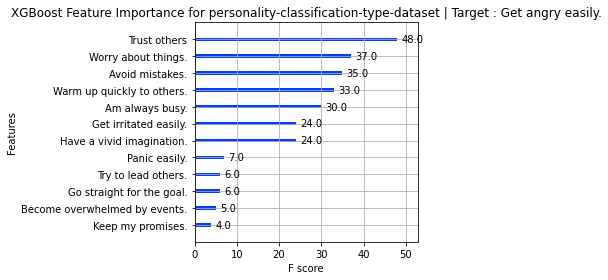

Target Variable: Trust others
CATS=====================
['Make friends easily.', 'Have a vivid imagination.', 'Trust others', 'Get angry easily.', 'Love large parties.', 'Would never cheat to get ahead.', 'Like order.', 'Often feel unhappy.', 'Take charge.', 'Make people feel welcome.', 'Try to follow the rules.', 'Am easy to satisfy.', 'Go straight for the goal.', 'Often overindulge.', 'Avoid mistakes.', 'Warm up quickly to others.', 'Get irritated easily.', 'Stick to the rules.', 'Try to lead others.', 'Keep my promises.', "Feel others' emotions", 'Like to visit new places.', 'Work hard.', 'Choose my words with care.', 'I have little to say.']
CONTS=====================
['Worry about things.', 'Am always busy.', 'Panic easily.', 'Become overwhelmed by events.', 'I am quiet around strangers.']
30
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['Worry about things.', 'Am always busy.', 'Panic easily.', 'Become overwhelmed by events.', '

 17%|█▋        | 7/42 [00:00<00:00, 44.28it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.014112234115600586}
{'Model': 'BaggingRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.02669358253479004}
{'Model': 'BayesianRidge', 'R-Squared': 0.9813222428236639, 'Adjusted R-Squared': 1.015175677705773, 'RMSE': 0.06548481179784837, 'Time taken': 0.011610269546508789}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 0.0, 'Time taken': 0.010906696319580078}
{'Model': 'DummyRegressor', 'R-Squared': -1.168055555555556, 'Adjusted R-Squared': 2.761545138888889, 'RMSE': 0.7055266523263718, 'Time taken': 0.010059595108032227}
{'Model': 'ElasticNet', 'R-Squared': -0.0013841987360321273, 'Adjusted R-Squared': 1.813624661473026, 'RMSE': 0.47948893362089734, 'Time taken': 0.011051177978515625}
{'Model': 'ElasticNetCV', 'R-Squared': 0.9955795571313338, 'Adjusted R-Squared': 1.0035916098307913, 'RMSE': 0.0318574574848

 29%|██▊       | 12/42 [00:00<00:01, 29.94it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.9835422222222222, 'Adjusted R-Squared': 1.0133719444444445, 'RMSE': 0.0614700856398576, 'Time taken': 0.10313010215759277}
{'Model': 'GammaRegressor', 'R-Squared': 0.87639811958038, 'Adjusted R-Squared': 1.1004265278409413, 'RMSE': 0.16845765862495696, 'Time taken': 0.013624906539916992}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -7.638095932547991, 'Adjusted R-Squared': 8.018452945195243, 'RMSE': 1.4082742314777263, 'Time taken': 0.013550043106079102}
{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.9582073148330329, 'Adjusted R-Squared': 1.0339565566981608, 'RMSE': 0.09795539469349693, 'Time taken': 0.0759727954864502}
{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.8634398919712398, 'Adjusted R-Squared': 1.1109550877733676, 'RMSE': 0.17706802655197598, 'Time taken': 0.08354449272155762}


 48%|████▊     | 20/42 [00:00<00:00, 31.21it/s]

{'Model': 'HuberRegressor', 'R-Squared': 0.9763726881776036, 'Adjusted R-Squared': 1.0191971908556972, 'RMSE': 0.07365214130225498, 'Time taken': 0.04221606254577637}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.5395555555555555, 'Adjusted R-Squared': 1.374111111111111, 'RMSE': 0.32513733362117264, 'Time taken': 0.011729240417480469}
{'Model': 'KernelRidge', 'R-Squared': -13.981288718733262, 'Adjusted R-Squared': 13.172297083970776, 'RMSE': 1.8546109008594545, 'Time taken': 0.010874509811401367}
{'Model': 'Lars', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 4.450793765416312e-16, 'Time taken': 0.012228250503540039}
{'Model': 'LarsCV', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 4.450793765416312e-16, 'Time taken': 0.015691757202148438}
{'Model': 'Lasso', 'R-Squared': -1.168055555555556, 'Adjusted R-Squared': 2.761545138888889, 'RMSE': 0.7055266523263718, 'Time taken': 0.010935783386230469}
{'Model': 'LassoCV', 'R-Squared': 0.9993267507216744, 'Adjusted R-Squared': 1

 76%|███████▌  | 32/42 [00:00<00:00, 35.71it/s]

{'Model': 'MLPRegressor', 'R-Squared': -0.3794469720321536, 'Adjusted R-Squared': 2.120800664776125, 'RMSE': 0.5627697255423163, 'Time taken': 0.09384703636169434}
{'Model': 'NuSVR', 'R-Squared': 0.9367538277926077, 'Adjusted R-Squared': 1.0513875149185061, 'RMSE': 0.12050230223333463, 'Time taken': 0.013005971908569336}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 1.0681905036999148e-15, 'Time taken': 0.010846376419067383}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 1.0681905036999148e-15, 'Time taken': 0.014867782592773438}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.8981090765427494, 'Adjusted R-Squared': 1.0827863753090161, 'RMSE': 0.15294876352277018, 'Time taken': 0.010613203048706055}
{'Model': 'PoissonRegressor', 'R-Squared': 0.8835474170693856, 'Adjusted R-Squared': 1.0946177236311243, 'RMSE': 0.16351318725882338, 'Time taken': 0.01230764389038086}
{'Model': 'QuantileReg

 86%|████████▌ | 36/42 [00:01<00:00, 27.62it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.98208, 'Adjusted R-Squared': 1.0145600000000001, 'RMSE': 0.06414269805898186, 'Time taken': 0.18248772621154785}
{'Model': 'Ridge', 'R-Squared': 0.9789073411716918, 'Adjusted R-Squared': 1.0171377852980004, 'RMSE': 0.06958952710005675, 'Time taken': 0.010972738265991211}
{'Model': 'RidgeCV', 'R-Squared': 0.9797723625360127, 'Adjusted R-Squared': 1.0164349554394896, 'RMSE': 0.06814763706952964, 'Time taken': 0.011225223541259766}
{'Model': 'SGDRegressor', 'R-Squared': 0.9584557984093962, 'Adjusted R-Squared': 1.0337546637923656, 'RMSE': 0.0976637576015951, 'Time taken': 0.011646747589111328}
{'Model': 'SVR', 'R-Squared': 0.8878114537644649, 'Adjusted R-Squared': 1.0911531938163723, 'RMSE': 0.16049166455243594, 'Time taken': 0.010584354400634766}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.9813222112980403, 'Adjusted R-Squared': 1.0151757033203423, 'RMSE': 0.06548486706274535, 'Time taken': 0.011543750762939453}
{'Model': 'Twee

100%|██████████| 42/42 [00:01<00:00, 25.82it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.9999999234102619, 'Adjusted R-Squared': 1.0000000622291623, 'RMSE': 0.0001326061, 'Time taken': 0.35060548782348633}
{'Model': 'LGBMRegressor', 'R-Squared': 0.8634398919712398, 'Adjusted R-Squared': 1.1109550877733676, 'RMSE': 0.17706802655197598, 'Time taken': 0.04323744773864746}
Project: personality-classification-type-dataset
personality-classification-type-dataset
Target: Trust others
Trust others
Target Standard Deviation: 0.8031745051446079
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
KernelRidge                                 13.17     -13.98  1.85        0.01
GaussianProcessRegressor                     8.02      -7.64  1.41        0.01
QuantileRegressor                            3.27      -1.80  0.80        0.08
LassoLars                                    2.76      -1.17  0.71        0.01
DummyRegressor                   

Better model found at epoch 0 with _rmse value: 1.1765100955963135.
No improvement since epoch 0: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       2       2.00
1       1       1.00
2       1       1.00
3       1       1.00
4       1       1.00
XGBoost RMSE:  0.0001326061


<Figure size 432x288 with 0 Axes>

<Figure size 720x720 with 0 Axes>

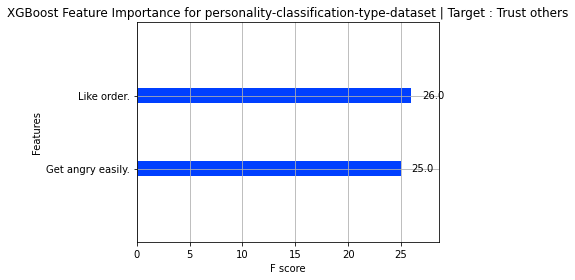

Target Variable: Have a vivid imagination.
CATS=====================
['Make friends easily.', 'Have a vivid imagination.', 'Trust others', 'Get angry easily.', 'Love large parties.', 'Would never cheat to get ahead.', 'Like order.', 'Often feel unhappy.', 'Take charge.', 'Make people feel welcome.', 'Try to follow the rules.', 'Am easy to satisfy.', 'Go straight for the goal.', 'Often overindulge.', 'Avoid mistakes.', 'Warm up quickly to others.', 'Get irritated easily.', 'Stick to the rules.', 'Try to lead others.', 'Keep my promises.', "Feel others' emotions", 'Like to visit new places.', 'Work hard.', 'Choose my words with care.', 'I have little to say.']
CONTS=====================
['Worry about things.', 'Am always busy.', 'Panic easily.', 'Become overwhelmed by events.', 'I am quiet around strangers.']
30
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['Worry about things.', 'Am always busy.', 'Panic easily.', 'Become overwhelmed b

  5%|▍         | 2/42 [00:00<00:02, 19.33it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.1816012113546298, 'Adjusted R-Squared': 1.6649490157743632, 'RMSE': 0.44768760663842555, 'Time taken': 0.07632565498352051}
{'Model': 'BaggingRegressor', 'R-Squared': 0.12208333333333321, 'Adjusted R-Squared': 1.7133072916666667, 'RMSE': 0.46368092477478523, 'Time taken': 0.026640892028808594}
{'Model': 'BayesianRidge', 'R-Squared': 0.2020139483730059, 'Adjusted R-Squared': 1.6483636669469326, 'RMSE': 0.44206917501731374, 'Time taken': 0.012510299682617188}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.41666666666666663, 'Adjusted R-Squared': 1.4739583333333335, 'RMSE': 0.3779644730092272, 'Time taken': 0.012127161026000977}
{'Model': 'DummyRegressor', 'R-Squared': -0.020833333333333037, 'Adjusted R-Squared': 1.829427083333333, 'RMSE': 0.4999999999999999, 'Time taken': 0.01019430160522461}
{'Model': 'ElasticNet', 'R-Squared': -0.020833333333333037, 'Adjusted R-Squared': 1.829427083333333, 'RMSE': 0.4999999999999999, 'Time taken': 0.0102

 21%|██▏       | 9/42 [00:00<00:01, 17.76it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.06950526034524707, 'Adjusted R-Squared': 1.7560269759694869, 'RMSE': 0.47736386831492866, 'Time taken': 0.23089838027954102}
{'Model': 'ExtraTreeRegressor', 'R-Squared': -0.16666666666666674, 'Adjusted R-Squared': 1.9479166666666667, 'RMSE': 0.5345224838248488, 'Time taken': 0.011813640594482422}
{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.41305000000000003, 'Adjusted R-Squared': 1.476896875, 'RMSE': 0.37913435236451093, 'Time taken': 0.10677504539489746}
{'Model': 'GammaRegressor', 'R-Squared': 0.18740403177352483, 'Adjusted R-Squared': 1.6602342241840111, 'RMSE': 0.44609762861905566, 'Time taken': 0.013802289962768555}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -9.468226206870517, 'Adjusted R-Squared': 9.505433793082295, 'RMSE': 1.6011393550642732, 'Time taken': 0.014148950576782227}


 36%|███▌      | 15/42 [00:00<00:01, 21.44it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.550054623365873, 'Adjusted R-Squared': 1.3655806185152282, 'RMSE': 0.33194985236000185, 'Time taken': 0.0911409854888916}
{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.07528993409118179, 'Adjusted R-Squared': 1.7513269285509148, 'RMSE': 0.47587772376700904, 'Time taken': 0.06798577308654785}
{'Model': 'HuberRegressor', 'R-Squared': -0.46147577359338054, 'Adjusted R-Squared': 2.1874490660446217, 'RMSE': 0.5982578326686574, 'Time taken': 0.041312217712402344}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.43999999999999995, 'Adjusted R-Squared': 1.455, 'RMSE': 0.3703280399090206, 'Time taken': 0.010924339294433594}
{'Model': 'KernelRidge', 'R-Squared': -9.36719629222524, 'Adjusted R-Squared': 9.423346987433007, 'RMSE': 1.5933942432500838, 'Time taken': 0.012302398681640625}
{'Model': 'Lars', 'R-Squared': -1.2478574598145271, 'Adjusted R-Squared': 2.826384186099303, 'RMSE': 0.741953977308818, 'Time taken': 0.01652503013610

 60%|█████▉    | 25/42 [00:01<00:00, 23.55it/s]

{'Model': 'LassoCV', 'R-Squared': 0.04161592608836773, 'Adjusted R-Squared': 1.7786870600532012, 'RMSE': 0.48446496655082666, 'Time taken': 0.24469542503356934}
{'Model': 'LassoLars', 'R-Squared': -0.020833333333333037, 'Adjusted R-Squared': 1.829427083333333, 'RMSE': 0.4999999999999999, 'Time taken': 0.016065597534179688}
{'Model': 'LassoLarsCV', 'R-Squared': 0.028362027614300844, 'Adjusted R-Squared': 1.7894558525633806, 'RMSE': 0.487803399437335, 'Time taken': 0.05052304267883301}
{'Model': 'LassoLarsIC', 'R-Squared': 0.0630227371299662, 'Adjusted R-Squared': 1.7612940260819023, 'RMSE': 0.4790238193225631, 'Time taken': 0.018761157989501953}
{'Model': 'LinearRegression', 'R-Squared': -8.132000004940037, 'Adjusted R-Squared': 8.41975000401378, 'RMSE': 1.49546252526605, 'Time taken': 0.010863780975341797}
{'Model': 'LinearSVR', 'R-Squared': -0.2695877257349548, 'Adjusted R-Squared': 2.031540027159651, 'RMSE': 0.5576015091775952, 'Time taken': 0.014394044876098633}


 76%|███████▌  | 32/42 [00:01<00:00, 25.48it/s]

{'Model': 'MLPRegressor', 'R-Squared': -0.16361645220614007, 'Adjusted R-Squared': 1.9454383674174887, 'RMSE': 0.5338232801385026, 'Time taken': 0.10906815528869629}
{'Model': 'NuSVR', 'R-Squared': 0.3415424027426214, 'Adjusted R-Squared': 1.5349967977716201, 'RMSE': 0.40156558838789613, 'Time taken': 0.012573719024658203}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': -0.042632963004879176, 'Adjusted R-Squared': 1.8471392824414643, 'RMSE': 0.5053104835816504, 'Time taken': 0.011286258697509766}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': -0.16004995802706778, 'Adjusted R-Squared': 1.9425405908969926, 'RMSE': 0.5330045659015831, 'Time taken': 0.017567157745361328}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -0.06375054211192288, 'Adjusted R-Squared': 1.8642973154659375, 'RMSE': 0.5104021324835313, 'Time taken': 0.010636329650878906}
{'Model': 'PoissonRegressor', 'R-Squared': 0.19095981972260123, 'Adjusted R-Squared': 1.6573451464753866, 'RMSE': 0.445120533167732

 83%|████████▎ | 35/42 [00:01<00:00, 18.18it/s]

{'Model': 'RANSACRegressor', 'R-Squared': -0.75, 'Adjusted R-Squared': 2.421875, 'RMSE': 0.6546536707079771, 'Time taken': 0.14829230308532715}
{'Model': 'RandomForestRegressor', 'R-Squared': 0.36778333333333335, 'Adjusted R-Squared': 1.5136760416666668, 'RMSE': 0.39348261896629105, 'Time taken': 0.13852429389953613}
{'Model': 'Ridge', 'R-Squared': 0.3096505484679478, 'Adjusted R-Squared': 1.5609089293697924, 'RMSE': 0.4111753540811607, 'Time taken': 0.011271238327026367}
{'Model': 'RidgeCV', 'R-Squared': 0.23350269392865008, 'Adjusted R-Squared': 1.6227790611829718, 'RMSE': 0.43325930570116683, 'Time taken': 0.014201641082763672}
{'Model': 'SGDRegressor', 'R-Squared': 0.22817775963690856, 'Adjusted R-Squared': 1.627105570295012, 'RMSE': 0.4347616490877407, 'Time taken': 0.011304616928100586}
{'Model': 'SVR', 'R-Squared': 0.37892680830641834, 'Adjusted R-Squared': 1.5046219682510351, 'RMSE': 0.3899994322424695, 'Time taken': 0.010988712310791016}
{'Model': 'TransformedTargetRegressor',

100%|██████████| 42/42 [00:02<00:00, 18.98it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.5214816861448146, 'Adjusted R-Squared': 1.3887961300073381, 'RMSE': 0.34232754, 'Time taken': 0.37084317207336426}
{'Model': 'LGBMRegressor', 'R-Squared': 0.07528993409118179, 'Adjusted R-Squared': 1.7513269285509148, 'RMSE': 0.47587772376700904, 'Time taken': 0.027034521102905273}
Project: personality-classification-type-dataset
personality-classification-type-dataset
Target: Have a vivid imagination.
Have a vivid imagination.
Target Standard Deviation: 0.47915742374995496
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
GaussianProcessRegressor                     9.51      -9.47  1.60        0.01
KernelRidge                                  9.42      -9.37  1.59        0.01
TransformedTargetRegressor                   8.42      -8.13  1.50        0.01
LinearRegression                             8.42      -8.13  1.50        0.01
Lars  

Better model found at epoch 0 with _rmse value: 1.993874192237854.
No improvement since epoch 0: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       1       1.53
1       1       1.06
2       2       1.68
3       2       1.97
4       1       1.03
XGBoost RMSE:  0.34232754


<Figure size 432x288 with 0 Axes>

<Figure size 720x720 with 0 Axes>

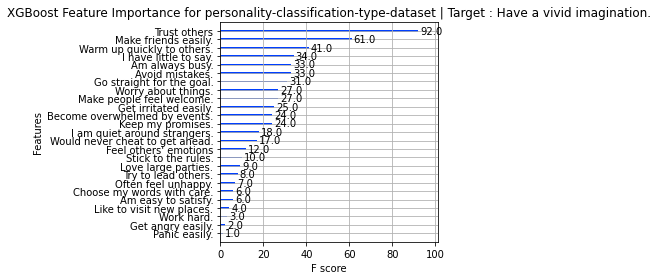

Target Variable: Make friends easily.
CATS=====================
['Make friends easily.', 'Have a vivid imagination.', 'Trust others', 'Get angry easily.', 'Love large parties.', 'Would never cheat to get ahead.', 'Like order.', 'Often feel unhappy.', 'Take charge.', 'Make people feel welcome.', 'Try to follow the rules.', 'Am easy to satisfy.', 'Go straight for the goal.', 'Often overindulge.', 'Avoid mistakes.', 'Warm up quickly to others.', 'Get irritated easily.', 'Stick to the rules.', 'Try to lead others.', 'Keep my promises.', "Feel others' emotions", 'Like to visit new places.', 'Work hard.', 'Choose my words with care.', 'I have little to say.']
CONTS=====================
['Worry about things.', 'Am always busy.', 'Panic easily.', 'Become overwhelmed by events.', 'I am quiet around strangers.']
30
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['Worry about things.', 'Am always busy.', 'Panic easily.', 'Become overwhelmed by eve

  5%|▍         | 2/42 [00:00<00:02, 18.83it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': -0.4149338794753239, 'Adjusted R-Squared': 2.1496337770737006, 'RMSE': 0.5373658122912677, 'Time taken': 0.07854509353637695}
{'Model': 'BaggingRegressor', 'R-Squared': -0.5399999999999998, 'Adjusted R-Squared': 2.2512499999999998, 'RMSE': 0.5606119105813882, 'Time taken': 0.027475595474243164}
{'Model': 'BayesianRidge', 'R-Squared': -0.14753867054451542, 'Adjusted R-Squared': 1.9323751698174187, 'RMSE': 0.4839334307704398, 'Time taken': 0.014758586883544922}
{'Model': 'DecisionTreeRegressor', 'R-Squared': -1.4499999999999997, 'Adjusted R-Squared': 2.9906249999999996, 'RMSE': 0.7071067811865476, 'Time taken': 0.011441707611083984}
{'Model': 'DummyRegressor', 'R-Squared': -0.014062499999999867, 'Adjusted R-Squared': 1.8239257812499998, 'RMSE': 0.45491925724489274, 'Time taken': 0.010136842727661133}
{'Model': 'ElasticNet', 'R-Squared': -0.014062499999999867, 'Adjusted R-Squared': 1.8239257812499998, 'RMSE': 0.45491925724489274, 'Time taken': 0

 21%|██▏       | 9/42 [00:00<00:01, 18.16it/s]

{'Model': 'ElasticNetCV', 'R-Squared': -0.22910883856776465, 'Adjusted R-Squared': 1.9986509313363088, 'RMSE': 0.5008378365131945, 'Time taken': 0.21639108657836914}
{'Model': 'ExtraTreeRegressor', 'R-Squared': -1.0999999999999996, 'Adjusted R-Squared': 2.70625, 'RMSE': 0.6546536707079771, 'Time taken': 0.01181340217590332}
{'Model': 'ExtraTreesRegressor', 'R-Squared': -0.2627999999999997, 'Adjusted R-Squared': 2.0260249999999997, 'RMSE': 0.5076556763341524, 'Time taken': 0.10629653930664062}
{'Model': 'GammaRegressor', 'R-Squared': -0.1343981883893719, 'Adjusted R-Squared': 1.9216985280663645, 'RMSE': 0.48115468860354876, 'Time taken': 0.014176607131958008}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -12.529100986869214, 'Adjusted R-Squared': 11.992394551831236, 'RMSE': 1.6616380525639185, 'Time taken': 0.012171030044555664}


 36%|███▌      | 15/42 [00:00<00:01, 21.97it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': -0.9226311346045764, 'Adjusted R-Squared': 2.5621377968662182, 'RMSE': 0.6263973985735489, 'Time taken': 0.07764697074890137}
{'Model': 'HistGradientBoostingRegressor', 'R-Squared': -0.44988317096994335, 'Adjusted R-Squared': 2.178030076413079, 'RMSE': 0.5439618779728443, 'Time taken': 0.07866311073303223}
{'Model': 'HuberRegressor', 'R-Squared': -1.1486464252389808, 'Adjusted R-Squared': 2.7457752205066717, 'RMSE': 0.6621927743919703, 'Time taken': 0.03764176368713379}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.005999999999999894, 'Adjusted R-Squared': 1.807625, 'RMSE': 0.4503966505838414, 'Time taken': 0.010477066040039062}
{'Model': 'KernelRidge', 'R-Squared': -14.71549704698378, 'Adjusted R-Squared': 13.768841350674322, 'RMSE': 1.7908780794076444, 'Time taken': 0.011623859405517578}
{'Model': 'Lars', 'R-Squared': -71.95929275627131, 'Adjusted R-Squared': 60.27942536447044, 'RMSE': 3.8587111297572556, 'Time taken': 0.014801979

 60%|█████▉    | 25/42 [00:01<00:00, 25.41it/s]

{'Model': 'LassoCV', 'R-Squared': -0.23943837127831835, 'Adjusted R-Squared': 2.007043676663634, 'RMSE': 0.5029379746880627, 'Time taken': 0.21087884902954102}
{'Model': 'LassoLars', 'R-Squared': -0.014062499999999867, 'Adjusted R-Squared': 1.8239257812499998, 'RMSE': 0.45491925724489274, 'Time taken': 0.011281728744506836}
{'Model': 'LassoLarsCV', 'R-Squared': -0.3034858615930023, 'Adjusted R-Squared': 2.0590822625443144, 'RMSE': 0.5157688656501884, 'Time taken': 0.046564340591430664}
{'Model': 'LassoLarsIC', 'R-Squared': -0.43115177108031877, 'Adjusted R-Squared': 2.162810814002759, 'RMSE': 0.5404366660547669, 'Time taken': 0.018494129180908203}
{'Model': 'LinearRegression', 'R-Squared': -1.0844796227832822, 'Adjusted R-Squared': 2.693639693511417, 'RMSE': 0.6522300243393043, 'Time taken': 0.010868549346923828}
{'Model': 'LinearSVR', 'R-Squared': -1.1504848184705874, 'Adjusted R-Squared': 2.747268915007352, 'RMSE': 0.6624760016401345, 'Time taken': 0.015037775039672852}


 76%|███████▌  | 32/42 [00:01<00:00, 27.10it/s]

{'Model': 'MLPRegressor', 'R-Squared': -1.943636124531705, 'Adjusted R-Squared': 3.3917043511820104, 'RMSE': 0.7750755229208057, 'Time taken': 0.10278105735778809}
{'Model': 'NuSVR', 'R-Squared': -0.15166218592125458, 'Adjusted R-Squared': 1.9357255260610193, 'RMSE': 0.48480212372431186, 'Time taken': 0.011663675308227539}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': -0.6380936043845418, 'Adjusted R-Squared': 2.3309510535624405, 'RMSE': 0.5781909868039583, 'Time taken': 0.010691165924072266}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': -0.6069990855329708, 'Adjusted R-Squared': 2.305686756995539, 'RMSE': 0.5726770442819802, 'Time taken': 0.016379356384277344}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -1.2384935939781023, 'Adjusted R-Squared': 2.8187760451072084, 'RMSE': 0.6758960181436712, 'Time taken': 0.010440826416015625}
{'Model': 'PoissonRegressor', 'R-Squared': -0.14140642723088948, 'Adjusted R-Squared': 1.9273927221250977, 'RMSE': 0.48263867146135053, 

 83%|████████▎ | 35/42 [00:01<00:00, 18.45it/s]

{'Model': 'RANSACRegressor', 'R-Squared': -0.3999999999999997, 'Adjusted R-Squared': 2.1374999999999997, 'RMSE': 0.5345224838248488, 'Time taken': 0.15494108200073242}
{'Model': 'RandomForestRegressor', 'R-Squared': -0.4354899999999997, 'Adjusted R-Squared': 2.166335625, 'RMSE': 0.541255155039786, 'Time taken': 0.14205050468444824}
{'Model': 'Ridge', 'R-Squared': -0.7996654649648154, 'Adjusted R-Squared': 2.4622281902839127, 'RMSE': 0.6060352022113485, 'Time taken': 0.011254310607910156}
{'Model': 'RidgeCV', 'R-Squared': -0.2708120430991712, 'Adjusted R-Squared': 2.0325347850180764, 'RMSE': 0.5092635825884778, 'Time taken': 0.014171123504638672}
{'Model': 'SGDRegressor', 'R-Squared': -0.2851987721199576, 'Adjusted R-Squared': 2.0442240023474656, 'RMSE': 0.5121381295099503, 'Time taken': 0.01117563247680664}
{'Model': 'SVR', 'R-Squared': -0.09311570731521002, 'Adjusted R-Squared': 1.8881565121936081, 'RMSE': 0.47231857705111907, 'Time taken': 0.011049747467041016}
{'Model': 'Transformed

100%|██████████| 42/42 [00:02<00:00, 18.80it/s]

{'Model': 'XGBRegressor', 'R-Squared': -0.3007298295065082, 'Adjusted R-Squared': 2.056842986474038, 'RMSE': 0.51522326, 'Time taken': 0.4498322010040283}
{'Model': 'LGBMRegressor', 'R-Squared': -0.44988317096994335, 'Adjusted R-Squared': 2.178030076413079, 'RMSE': 0.5439618779728443, 'Time taken': 0.03827929496765137}
Project: personality-classification-type-dataset
personality-classification-type-dataset
Target: Make friends easily.
Make friends easily.
Target Standard Deviation: 0.47346691369867333
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
Lars                                        60.28     -71.96  3.86        0.01
KernelRidge                                 13.77     -14.72  1.79        0.01
GaussianProcessRegressor                    11.99     -12.53  1.66        0.01
MLPRegressor                                 3.39      -1.94  0.78        0.10
DecisionTreeRegress

Better model found at epoch 0 with _rmse value: 1.7846384048461914.
No improvement since epoch 0: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       2       1.97
1       2       2.00
2       1       2.00
3       2       1.72
4       1       2.01
XGBoost RMSE:  0.51522326


<Figure size 432x288 with 0 Axes>

<Figure size 720x720 with 0 Axes>

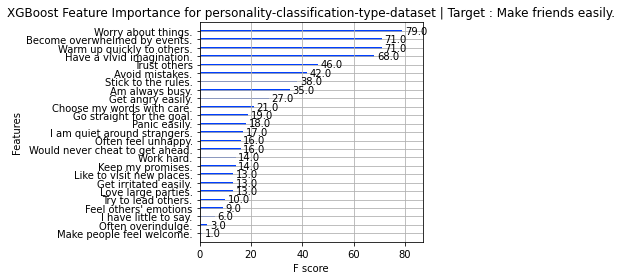

<Figure size 432x288 with 0 Axes>

In [21]:
target = ''
target_str = ''
#The column closest to the end isPARAM_DIR the target variable that can be represented as a float is the target variable
targets = []
#Loop through every possible target column (Continuous)
for i in range(len(df.columns)-1, 0, -1):
    try:
        df[df.columns[i]] = df[df.columns[i]].apply(pd.to_numeric, errors='coerce').dropna()
        target = df.columns[i]
        target_str = target.replace('/', '-')
    except:
        continue
    print(f'Target Variable: {target}')
    #Will be determined by the file name


    #===================================================================================================

    #Create project config files if they don't exist.
    if not os.path.exists(param_dir):
        #create param_dir
        os.makedirs(PARAM_DIR)
    if not os.path.exists(f'{PARAM_DIR}/cats.txt'):
        #create param_dir
        with open(f'{PARAM_DIR}/cats.txt', 'w') as f:
            f.write('')
    if not os.path.exists(f'{PARAM_DIR}/conts.txt'):
        #create param_dir
        with open(f'{PARAM_DIR}/conts.txt', 'w') as f:
            f.write('')
    if not os.path.exists(f'{PARAM_DIR}/cols_to_delete.txt'):
        with open(f'{PARAM_DIR}/cols_to_delete.txt', 'w') as f:
            f.write('')

    df = df.drop_duplicates()
    if SHUFFLE_DATA:
        df = df.sample(frac=1).reset_index(drop=True)

    # workaround for fastai/pytorch bug where bool is treated as object and thus erroring out.
    for n in df:
        if pd.api.types.is_bool_dtype(df[n]):
            df[n] = df[n].astype('uint8')

    with open(f'{PARAM_DIR}/cols_to_delete.txt', 'r') as f:
        cols_to_delete = f.read().splitlines()
    for col in cols_to_delete:
        try:
            del(df[col])
        except:
            pass
    #try to fill in missing values now, otherwise FastAI will do it for us later
    try:
        df = df.fillna(0)
    except:
        pass
    #print missing values
    #print(df.isna().sum().sort_values(ascending=False))
    #shrink df as much as possible
    df = df_shrink(df)


    #print types inside of df
    #print(df.dtypes)


    #Auto detect categorical and continuous variables
    #==============================================================================
    likely_cat = {}
    for var in df.columns:
        likely_cat[var] = 1.*df[var].nunique()/df[var].count() < 0.05 #or some other threshold

    cats = [var for var in df.columns if likely_cat[var]]
    conts = [var for var in df.columns if not likely_cat[var]]

    #remove target from lists
    try:
        conts.remove(target)
        cats.remove(target)
    except:
        pass
    #Convert target to float
    df[target] = df[target].apply(pd.to_numeric, errors='coerce').dropna()

    print('CATS=====================')
    print(cats)
    print('CONTS=====================')
    print(conts)

    #Populate categorical and continuous lists
    #==============================================================================

    if VARIABLE_FILES == True:
        with open(f'{PARAM_DIR}/cats.txt', 'r') as f:
            cats = f.read().splitlines()

        with open(f'{PARAM_DIR}/conts.txt', 'r') as f:
            conts = f.read().splitlines()

    #==============================================================================

    #==============================================================================
    procs = [Categorify, FillMissing, Normalize]
    #print(df.describe().T)
    df = df[0:SAMPLE_COUNT]
    splits = RandomSplitter()(range_of(df))

    print((len(cats)) + len(conts))
    #conts = []

    #Convert cont variables to floats
    #==============================================================================

    #Convert cont variables to floats
    #==============================================================================

    for var in conts:
        try:
            df[var] = df[var].apply(pd.to_numeric, errors='coerce').dropna()
        except:
            print(f'Could not convert {var} to float.')
            pass

    #==============================================================================

    #Experimental logic to add columns one-by-one to find a breakpoint
    #==============================================================================
    if ENABLE_BREAKPOINT == True:
        temp_procs = [Categorify, FillMissing]
        print('Looping through continuous variables to find breakpoint')
        cont_list = []
        for cont in conts:
            focus_cont = cont
            cont_list.append(cont)
            #print(focus_cont)
            try:
                to = TabularPandas(df, procs=procs, cat_names=cats, cont_names=cont_list, y_names=target, y_block=RegressionBlock(), splits=splits)
                del(to)
            except:
                print('Error with ', focus_cont)
                #remove focus_cont from list
                cont_list.remove(focus_cont)
                #traceback.print_exc()
                continue
        #convert all continuous variables to floats
        for var in cont_list:
            try:
                df[var] = df[var].apply(pd.to_numeric, errors='coerce').dropna()
            except:
                print(f'Could not convert {var} to float.')
                cont_list.remove(var)
                if CONVERT_TO_CAT == True:
                    cats.append(var)
                pass
        print(f'Continuous variables that made the cut : {cont_list}')
        print(f'Categorical variables that made the cut : {cats}')
        #shrink df as much as possible
        df = df_shrink(df)
        #print(df.dtypes)

    #==============================================================================

    #Creating tabular object + quick preprocessing
    #==============================================================================
    to = None
    if REGRESSOR == True:
        try:
            to = TabularPandas(df, procs, cats, conts, target, y_block=RegressionBlock(), splits=splits)
        except:
            conts = []
            to = TabularPandas(df, procs, cats, conts, target, y_block=RegressionBlock(), splits=splits)
    else:
        try:
            to = TabularPandas(df, procs, cats, conts, target, splits=splits)
        except:
            conts = []
            to = TabularPandas(df, procs, cats, conts, target, splits=splits)

    #print(dir(to))
    #print(to.xs)
    dls = to.dataloaders()
    print(f'Tabular Object size: {len(to)}')
    try:
        dls.one_batch()
    except:
        print(f'problem with getting one batch of {PROJECT_NAME}')
    #==============================================================================

    #Extracting train and test sets from tabular object
    #==============================================================================

    X_train, y_train = to.train.xs, to.train.ys.values.ravel()
    X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()

    #Make sure target isn't in independent columns
    if target in X_train and target in X_test:
        del(X_train[target])
        del(X_test[target])
    #create dataframe from X_train and y_train
    #export tabular object to csv
    pd.DataFrame(X_train).to_csv(f'{PARAM_DIR}/X_train_{target_str}.csv', index=False)
    pd.DataFrame(X_test).to_csv(f'{PARAM_DIR}/X_test_{target_str}.csv', index=False)
    pd.DataFrame(y_train).to_csv(f'{PARAM_DIR}/y_train_{target_str}.csv', index=False)
    pd.DataFrame(y_test).to_csv(f'{PARAM_DIR}/y_test_{target_str}.csv', index=False)

    #==============================================================================

    #==============================================================================

    #Ready for model selection!

    if REGRESSOR == True:
        try:
            reg = LazyRegressor(verbose=2, ignore_warnings=False, custom_metric=None)
            models, predictions = reg.fit(X_train, X_test, y_train, y_test)
            print(f'Project: {PROJECT_NAME}')
            print(PROJECT_NAME)
            print(f'Target: {target}')
            print(target)
            target_std = y_train.std()
            print(f'Target Standard Deviation: {target_std}')
            print(models)
            models['project'] = PROJECT_NAME
            models['target'] = target
            models['target_std'] = target_std
            #rename index of 
            models.to_csv(f'{PARAM_DIR}/regression_results_{target_str}.csv', mode='a', header=True, index=True)
        except:
            print('Issue during lazypredict analysis')
    else:
        #TODO: remove this
        try:
            clf = LazyClassifier(verbose=2, ignore_warnings=False, custom_metric=None)
            models, predictions = clf.fit(X_train, X_test, y_train, y_test)
            print(f'Project: {PROJECT_NAME}')
            print(PROJECT_NAME)
            print(f'Target: {target}')
            print(target)
            print(f'Target Standard Deviation: {y_train.std()}')
            print(models)
            models.to_csv(f'{PARAM_DIR}/classification_results.csv', mode='a', header=False)
        except:
            print('Issue during lazypredict analysis')

    model_name = 'tabnet'

    # FastAI + pre-trained TabNet
    #==============================================================================
    learn = None
    i = 0
    while True:
        try:
            del learn
        except:
            pass
        try:
            learn = 0
            model = TabNetModel(get_emb_sz(to), len(to.cont_names), dls.c, n_d=64, n_a=64, n_steps=5, virtual_batch_size=256)
            # save the best model so far, determined by early stopping
            cbs = [SaveModelCallback(monitor='_rmse', comp=np.less, fname=f'{model_name}_{PROJECT_NAME}_{target_str}_best'), EarlyStoppingCallback()]
            learn = Learner(dls, model, loss_func=MSELossFlat(), metrics=rmse, cbs=cbs)
            #learn = get_learner(to)
            if(learn != 0):
                break
            if i > 50:
                break
        except:
            i += 1
            print('Error in FastAI TabNet')
            traceback.print_exc()
            continue
    try:
        #display learning rate finder results
        x = learn.lr_find()
    except:
        pass
    if AUTO_ADJUST_LEARNING_RATE == True:
        FASTAI_LEARNING_RATE = x.valley
    print(f'LEARNING RATE: {FASTAI_LEARNING_RATE}')
    try:
        if i < 50:
            learn.fit_one_cycle(20, FASTAI_LEARNING_RATE)
            plt.figure(figsize=(10, 10))
            try:
                ax = learn.show_results()
                plt.show(block=True)
            except:
                print('Could not show results')
                pass
    except:
        print('Could not fit model')
        traceback.print_exc()
        pass

    #==============================================================================

    #fit an xgboost model
    #==============================================================================
    if REGRESSOR == True:
        xgb = XGBRegressor()
    else:
        xgb = XGBClassifier()
    try:
        xgb = XGBRegressor()
        xgb.fit(X_train, y_train)
        y_pred = xgb.predict(X_test)
        print('XGBoost Predictions vs Actual==========')
        print(pd.DataFrame({'actual': y_test, 'predicted': y_pred}).head())
        print('XGBoost RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred)))
        #save feature importance plot to file
        plot_importance(xgb)
        plt.title(f'XGBoost Feature Importance for {PROJECT_NAME} | Target : {target}', wrap=True)
        plt.tight_layout()
        plt.show()
        plt.savefig(f'{PARAM_DIR}/xgb_feature_importance_{target_str}.png')
        fi_df = pd.DataFrame([xgb.get_booster().get_score()]).T
        fi_df.columns = ['importance']
        #create a column based off the index called feature
        fi_df['feature'] = fi_df.index
        #create a dataframe of feature importance
        fi_df = fi_df[['feature', 'importance']]
        fi_df.to_csv(f'{PARAM_DIR}/xgb_feature_importance_{target_str}.csv', index=False)
        #xgb_fi = pd.DataFrame(xgb.feature_importances_, index=X_train.columns, columns=['importance'])
        #xgb_fi.to_csv(f'{PARAM_DIR}/xgb_feature_importance_{target_str}.csv')
        #print('XGBoost AUC: ', roc_auc_score(y_test, y_pred))
    except:
        traceback.print_exc()
        print('XGBoost failed')

# <div style="text-align: center; background-color: blue; color: white; padding: 14px; line-height: 1;border-radius:20px">**Overall Feature Importance**</div>

                           feature  importance
0        Have a vivid imagination.       68.00
1                     Trust others       46.00
2                Get angry easily.       27.00
3              Love large parties.       13.00
4  Would never cheat to get ahead.       16.00


<AxesSubplot:title={'center':'XGBoost Overall Feature Importance'}, xlabel='feature'>

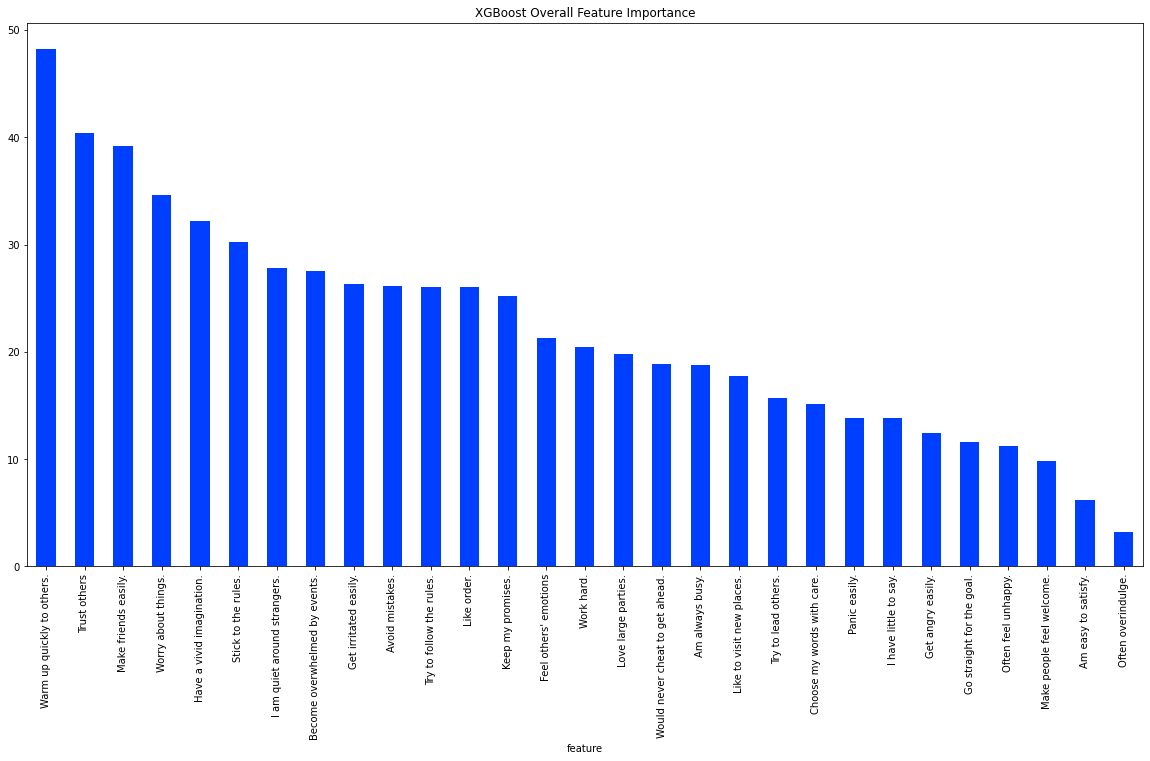

In [22]:
out_dir = f'./{PROJECT_NAME}'
xgb_feature_importance_csvs = []

for file in os.listdir(out_dir):
    if 'xgb_feature_importance' in file and '.csv' in file:
        xgb_feature_importance_csvs.append(pd.read_csv(os.path.join(out_dir, file)))

xgb_feature_importance = pd.concat(xgb_feature_importance_csvs,axis=0)
xgb_feature_importance.rename(columns={'Unnamed: 0': 'feature'}, inplace=True)
print(xgb_feature_importance.head())
xgb_feature_importance.groupby('feature')['importance'].mean().sort_values(ascending=False).plot(kind='bar', title='XGBoost Overall Feature Importance', figsize=(20, 10))

In [23]:
df.isna().sum()

Worry about things.                0
Make friends easily.               0
Have a vivid imagination.          0
Trust others                       0
Get angry easily.                  0
Love large parties.                0
Would never cheat to get ahead.    0
Like order.                        0
Often feel unhappy.                0
Take charge.                       0
Make people feel welcome.          0
Try to follow the rules.           0
Am always busy.                    0
Am easy to satisfy.                0
Go straight for the goal.          0
Often overindulge.                 0
Panic easily.                      0
Avoid mistakes.                    0
Warm up quickly to others.         0
Get irritated easily.              0
Stick to the rules.                0
Try to lead others.                0
Keep my promises.                  0
Feel others' emotions              0
Like to visit new places.          0
Work hard.                         0
Become overwhelmed by events.      0
C

# **To Be Continued...**